<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/liver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1490, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 1490 (delta 22), reused 25 (delta 10), pack-reused 1444 (from 1)
Receiving objects: 100% (1490/1490), 15.42 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (1005/1005), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.00% complete (down: 0.2 kB/s up: 0.1 kB/s peers: 4) downloading LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
0.60% complete (down: 8822.3 kB/s up: 259.8 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreach

## Load data

In [7]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="liver")
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

## Training

In [9]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [10]:
criterion = DiceLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    loss_epochs,
    trains_epoch,
    ious_liver,
    precisions_liver,
    recalls_liver,
    time_tmp
) = trainer_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="liver"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.6717 time 5.65s
Epoch 1/100 2/105 loss: 0.5836 time 0.68s
Epoch 1/100 3/105 loss: 0.5718 time 0.63s
Epoch 1/100 4/105 loss: 0.5457 time 4.15s
Epoch 1/100 5/105 loss: 0.5354 time 7.42s
Epoch 1/100 6/105 loss: 0.5471 time 4.67s
Epoch 1/100 7/105 loss: 0.5136 time 1.09s
Epoch 1/100 8/105 loss: 0.4851 time 5.44s
Epoch 1/100 9/105 loss: 0.4750 time 4.43s
Epoch 1/100 10/105 loss: 0.4637 time 1.45s
Epoch 1/100 11/105 loss: 0.4437 time 4.97s
Epoch 1/100 12/105 loss: 0.4285 time 4.34s
Epoch 1/100 13/105 loss: 0.4228 time 0.83s
Epoch 1/100 14/105 loss: 0.4221 time 1.10s
Epoch 1/100 15/105 loss: 0.4115 time 2.03s
Epoch 1/100 16/105 loss: 0.4032 time 5.31s
Epoch 1/100 17/105 loss: 0.4146 time 1.88s
Epoch 1/100 18/105 loss: 0.4263 time 6.82s
Epoch 1/100 19/105 loss: 0.4318 time 2.03s
Epoch 1/100 20/105 loss: 0.4221 time 5.23s
Epoch 1/100 21/105 loss: 0.4178 time 7.07s
Epoch 1/100 22/105 loss: 0.4158 time 5.50s
Epoch 1/100 23/105 loss: 0.4122 time 2.35s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.2296] ---[time 391.15s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.2296] ---[time 391.15s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.2296 time 5.04s


Val 1/100 1/26, Dice_Liver: 0.847300, time 4.47s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.847300, time 4.47s
Val 1/100 2/26, Dice_Liver: 0.910175, time 0.18s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.910175, time 0.18s
Val 1/100 3/26, Dice_Liver: 0.898597, time 4.59s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.898597, time 4.59s
Val 1/100 4/26, Dice_Liver: 0.872643, time 6.63s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.872643, time 6.63s
Val 1/100 5/26, Dice_Liver: 0.892710, time 0.68s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.892710, time 0.68s
Val 1/100 6/26, Dice_Liver: 0.875914, time 4.90s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Liver: 0.875914, time 4.90s
Val 1/100 7/26, Dice_Liver: 0.922641, time 5.08s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Liver: 0.922641, time 5.08s
Val 1/100 8/26, Dice_Liver: 0.821192, time 3.96s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Liver: 0.821192, time 3.96s
Val 1/100 9/26, Dice_Liver: 0.90

New best (0.000000 --> 0.864276). At epoch 1


Epoch 1/100 ---[loss: 0.2296] ---[val_dice: 0.864276] ---[time 88.79s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.2296] ---[val_dice: 0.864276] ---[time 88.79s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.1673 time 5.73s
Epoch 2/100 2/105 loss: 0.1489 time 5.46s
Epoch 2/100 3/105 loss: 0.1687 time 2.63s
Epoch 2/100 4/105 loss: 0.1604 time 6.14s
Epoch 2/100 5/105 loss: 0.1525 time 1.21s
Epoch 2/100 6/105 loss: 0.1498 time 5.79s
Epoch 2/100 7/105 loss: 0.1510 time 1.94s
Epoch 2/100 8/105 loss: 0.1432 time 5.26s
Epoch 2/100 9/105 loss: 0.1398 time 2.67s
Epoch 2/100 10/105 loss: 0.1506 time 2.83s
Epoch 2/100 11/105 loss: 0.1463 time 4.22s
Epoch 2/100 12/105 loss: 0.1438 time 5.13s
Epoch 2/100 13/105 loss: 0.1411 time 0.87s
Epoch 2/100 14/105 loss: 0.1384 time 1.16s
Epoch 2/100 15/105 loss: 0.1358 time 4.97s
Epoch 2/100 16/105 loss: 0.1363 time 5.85s
Epoch 2/100 17/105 loss: 0.1347 time 4.81s
Epoch 2/100 18/105 loss: 0.1351 time 5.46s
Epoch 2/100 19/105 loss: 0.1330 time 1.97s
Epoch 2/100 20/105 loss: 0.1324 time 5.48s
Epoch 2/100 21/105 loss: 0.1353 time 2.40s
Epoch 2/100 22/105 loss: 0.1339 time 4.63s
Epoch 2/100 23/105 loss: 0.1323 time 6.35s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.1261] ---[time 384.63s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.1261] ---[time 384.63s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.1261 time 4.42s


Val 2/100 1/26, Dice_Liver: 0.866666, time 1.20s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.866666, time 1.20s
Val 2/100 2/26, Dice_Liver: 0.934042, time 0.76s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.934042, time 0.76s
Val 2/100 3/26, Dice_Liver: 0.908993, time 5.99s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.908993, time 5.99s
Val 2/100 4/26, Dice_Liver: 0.927189, time 6.70s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.927189, time 6.70s
Val 2/100 5/26, Dice_Liver: 0.933099, time 0.70s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.933099, time 0.70s
Val 2/100 6/26, Dice_Liver: 0.931896, time 5.17s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Liver: 0.931896, time 5.17s
Val 2/100 7/26, Dice_Liver: 0.919732, time 5.19s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Liver: 0.919732, time 5.19s
Val 2/100 8/26, Dice_Liver: 0.897361, time 4.59s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Liver: 0.897361, time 4.59s
Val 2/100 9/26, Dice_Liver: 0.89

New best (0.864276 --> 0.890122). At epoch 2
Epoch 3/100 1/105 loss: 0.1622 time 5.40s
Epoch 3/100 2/105 loss: 0.1113 time 5.68s
Epoch 3/100 3/105 loss: 0.1222 time 3.92s
Epoch 3/100 4/105 loss: 0.1315 time 1.90s
Epoch 3/100 5/105 loss: 0.1283 time 5.47s
Epoch 3/100 6/105 loss: 0.1185 time 4.50s
Epoch 3/100 7/105 loss: 0.1214 time 1.10s
Epoch 3/100 8/105 loss: 0.1172 time 7.70s
Epoch 3/100 9/105 loss: 0.1142 time 5.71s
Epoch 3/100 10/105 loss: 0.1142 time 4.58s
Epoch 3/100 11/105 loss: 0.1140 time 5.39s
Epoch 3/100 12/105 loss: 0.1119 time 5.31s
Epoch 3/100 13/105 loss: 0.1113 time 0.95s
Epoch 3/100 14/105 loss: 0.1149 time 1.09s
Epoch 3/100 15/105 loss: 0.1143 time 4.96s
Epoch 3/100 16/105 loss: 0.1123 time 3.96s
Epoch 3/100 17/105 loss: 0.1118 time 4.70s
Epoch 3/100 18/105 loss: 0.1102 time 2.37s
Epoch 3/100 19/105 loss: 0.1133 time 2.06s
Epoch 3/100 20/105 loss: 0.1136 time 1.46s
Epoch 3/100 21/105 loss: 0.1131 time 5.69s
Epoch 3/100 22/105 loss: 0.1108 time 5.11s
Epoch 3/100 23/105

Final training epochs: 3/100 ---[loss: 0.1048] ---[time 381.22s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.1048] ---[time 381.22s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.1048 time 4.50s


Val 3/100 1/26, Dice_Liver: 0.900458, time 1.35s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.900458, time 1.35s
Val 3/100 2/26, Dice_Liver: 0.946428, time 0.91s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.946428, time 0.91s
Val 3/100 3/26, Dice_Liver: 0.896830, time 5.88s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.896830, time 5.88s
Val 3/100 4/26, Dice_Liver: 0.935333, time 7.23s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.935333, time 7.23s
Val 3/100 5/26, Dice_Liver: 0.945341, time 0.84s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.945341, time 0.84s
Val 3/100 6/26, Dice_Liver: 0.913019, time 4.60s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Liver: 0.913019, time 4.60s
Val 3/100 7/26, Dice_Liver: 0.928120, time 4.45s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Liver: 0.928120, time 4.45s
Val 3/100 8/26, Dice_Liver: 0.890835, time 4.56s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Liver: 0.890835, time 4.56s
Val 3/100 9/26, Dice_Liver: 0.91

New best (0.890122 --> 0.899951). At epoch 3
Epoch 4/100 1/105 loss: 0.0537 time 7.62s
Epoch 4/100 2/105 loss: 0.1460 time 9.79s
Epoch 4/100 3/105 loss: 0.1142 time 1.64s
Epoch 4/100 4/105 loss: 0.1090 time 5.42s
Epoch 4/100 5/105 loss: 0.0964 time 1.18s
Epoch 4/100 6/105 loss: 0.0913 time 4.39s
Epoch 4/100 7/105 loss: 0.0904 time 1.71s
Epoch 4/100 8/105 loss: 0.0918 time 1.15s
Epoch 4/100 9/105 loss: 0.0927 time 4.18s
Epoch 4/100 10/105 loss: 0.0918 time 0.83s
Epoch 4/100 11/105 loss: 0.0934 time 1.63s
Epoch 4/100 12/105 loss: 0.0930 time 1.86s
Epoch 4/100 13/105 loss: 0.0939 time 4.80s
Epoch 4/100 14/105 loss: 0.0939 time 4.74s
Epoch 4/100 15/105 loss: 0.0958 time 3.86s
Epoch 4/100 16/105 loss: 0.0980 time 4.78s
Epoch 4/100 17/105 loss: 0.0964 time 1.17s
Epoch 4/100 18/105 loss: 0.0946 time 5.25s
Epoch 4/100 19/105 loss: 0.0936 time 0.69s
Epoch 4/100 20/105 loss: 0.0942 time 5.37s
Epoch 4/100 21/105 loss: 0.0939 time 0.81s
Epoch 4/100 22/105 loss: 0.0929 time 4.40s
Epoch 4/100 23/105

Final training epochs: 4/100 ---[loss: 0.0959] ---[time 371.40s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.0959] ---[time 371.40s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.0959 time 3.60s


Val 4/100 1/26, Dice_Liver: 0.881245, time 1.40s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.881245, time 1.40s
Val 4/100 2/26, Dice_Liver: 0.952439, time 0.87s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.952439, time 0.87s
Val 4/100 3/26, Dice_Liver: 0.928300, time 5.56s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.928300, time 5.56s
Val 4/100 4/26, Dice_Liver: 0.939728, time 7.61s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.939728, time 7.61s
Val 4/100 5/26, Dice_Liver: 0.934096, time 0.65s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.934096, time 0.65s
Val 4/100 6/26, Dice_Liver: 0.940280, time 4.74s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Liver: 0.940280, time 4.74s
Val 4/100 7/26, Dice_Liver: 0.934772, time 4.82s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Liver: 0.934772, time 4.82s
Val 4/100 8/26, Dice_Liver: 0.912184, time 3.96s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Liver: 0.912184, time 3.96s
Val 4/100 9/26, Dice_Liver: 0.91

New best (0.899951 --> 0.916083). At epoch 4
Epoch 5/100 1/105 loss: 0.1155 time 2.17s
Epoch 5/100 2/105 loss: 0.1031 time 5.61s
Epoch 5/100 3/105 loss: 0.0972 time 1.19s
Epoch 5/100 4/105 loss: 0.0910 time 2.88s
Epoch 5/100 5/105 loss: 0.0854 time 5.97s
Epoch 5/100 6/105 loss: 0.0799 time 6.82s
Epoch 5/100 7/105 loss: 0.0787 time 5.14s
Epoch 5/100 8/105 loss: 0.0784 time 0.78s
Epoch 5/100 9/105 loss: 0.0801 time 0.80s
Epoch 5/100 10/105 loss: 0.0789 time 5.95s
Epoch 5/100 11/105 loss: 0.0837 time 3.96s
Epoch 5/100 12/105 loss: 0.0874 time 6.03s
Epoch 5/100 13/105 loss: 0.0870 time 2.20s
Epoch 5/100 14/105 loss: 0.0866 time 0.95s
Epoch 5/100 15/105 loss: 0.0865 time 4.84s
Epoch 5/100 16/105 loss: 0.0870 time 0.79s
Epoch 5/100 17/105 loss: 0.0877 time 1.86s
Epoch 5/100 18/105 loss: 0.0929 time 5.75s
Epoch 5/100 19/105 loss: 0.0942 time 1.13s
Epoch 5/100 20/105 loss: 0.0931 time 6.00s
Epoch 5/100 21/105 loss: 0.0950 time 2.97s
Epoch 5/100 22/105 loss: 0.0974 time 1.61s
Epoch 5/100 23/105

Final training epochs: 5/100 ---[loss: 0.0908] ---[time 378.15s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.0908] ---[time 378.15s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.0908 time 3.00s


Val 5/100 1/26, Dice_Liver: 0.922636, time 1.34s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.922636, time 1.34s
Val 5/100 2/26, Dice_Liver: 0.950369, time 0.81s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.950369, time 0.81s
Val 5/100 3/26, Dice_Liver: 0.956296, time 6.55s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.956296, time 6.55s
Val 5/100 4/26, Dice_Liver: 0.952100, time 6.78s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.952100, time 6.78s
Val 5/100 5/26, Dice_Liver: 0.938879, time 0.92s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.938879, time 0.92s
Val 5/100 6/26, Dice_Liver: 0.953577, time 4.95s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Liver: 0.953577, time 4.95s
Val 5/100 7/26, Dice_Liver: 0.949769, time 5.27s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Liver: 0.949769, time 5.27s
Val 5/100 8/26, Dice_Liver: 0.940875, time 4.55s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Liver: 0.940875, time 4.55s
Val 5/100 9/26, Dice_Liver: 0.91

New best (0.916083 --> 0.927687). At epoch 5
Epoch 6/100 1/105 loss: 0.0445 time 5.96s
Epoch 6/100 2/105 loss: 0.0656 time 0.71s
Epoch 6/100 3/105 loss: 0.0628 time 2.05s
Epoch 6/100 4/105 loss: 0.0840 time 2.89s
Epoch 6/100 5/105 loss: 0.0844 time 3.14s
Epoch 6/100 6/105 loss: 0.0904 time 1.57s
Epoch 6/100 7/105 loss: 0.0878 time 3.40s
Epoch 6/100 8/105 loss: 0.0834 time 5.57s
Epoch 6/100 9/105 loss: 0.0827 time 0.90s
Epoch 6/100 10/105 loss: 0.0819 time 6.22s
Epoch 6/100 11/105 loss: 0.0802 time 0.86s
Epoch 6/100 12/105 loss: 0.0806 time 1.19s
Epoch 6/100 13/105 loss: 0.0814 time 1.43s
Epoch 6/100 14/105 loss: 0.0809 time 8.92s
Epoch 6/100 15/105 loss: 0.0796 time 5.32s
Epoch 6/100 16/105 loss: 0.0775 time 5.63s
Epoch 6/100 17/105 loss: 0.0772 time 4.95s
Epoch 6/100 18/105 loss: 0.0826 time 5.55s
Epoch 6/100 19/105 loss: 0.0838 time 5.04s
Epoch 6/100 20/105 loss: 0.0817 time 5.20s
Epoch 6/100 21/105 loss: 0.0809 time 7.13s
Epoch 6/100 22/105 loss: 0.0799 time 1.61s
Epoch 6/100 23/105

Final training epochs: 6/100 ---[loss: 0.0788] ---[time 400.94s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.0788] ---[time 400.94s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.0788 time 2.97s


Val 6/100 1/26, Dice_Liver: 0.893540, time 1.47s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.893540, time 1.47s
Val 6/100 2/26, Dice_Liver: 0.946236, time 1.23s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.946236, time 1.23s
Val 6/100 3/26, Dice_Liver: 0.924064, time 6.00s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.924064, time 6.00s
Val 6/100 4/26, Dice_Liver: 0.956340, time 7.85s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.956340, time 7.85s
Val 6/100 5/26, Dice_Liver: 0.937067, time 0.79s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.937067, time 0.79s
Val 6/100 6/26, Dice_Liver: 0.943621, time 4.99s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Liver: 0.943621, time 4.99s
Val 6/100 7/26, Dice_Liver: 0.956802, time 5.61s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Liver: 0.956802, time 5.61s
Val 6/100 8/26, Dice_Liver: 0.933330, time 4.39s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Liver: 0.933330, time 4.39s
Val 6/100 9/26, Dice_Liver: 0.90

New best (0.927687 --> 0.928001). At epoch 6
Epoch 7/100 1/105 loss: 0.1395 time 2.97s
Epoch 7/100 2/105 loss: 0.0878 time 1.49s
Epoch 7/100 3/105 loss: 0.0795 time 4.56s
Epoch 7/100 4/105 loss: 0.0817 time 5.98s
Epoch 7/100 5/105 loss: 0.0892 time 1.36s
Epoch 7/100 6/105 loss: 0.0845 time 6.16s
Epoch 7/100 7/105 loss: 0.0887 time 1.21s
Epoch 7/100 8/105 loss: 0.0846 time 3.76s
Epoch 7/100 9/105 loss: 0.0833 time 6.07s
Epoch 7/100 10/105 loss: 0.0819 time 5.00s
Epoch 7/100 11/105 loss: 0.0798 time 4.81s
Epoch 7/100 12/105 loss: 0.0779 time 5.62s
Epoch 7/100 13/105 loss: 0.0788 time 0.89s
Epoch 7/100 14/105 loss: 0.0763 time 7.00s
Epoch 7/100 15/105 loss: 0.0763 time 0.85s
Epoch 7/100 16/105 loss: 0.0750 time 4.73s
Epoch 7/100 17/105 loss: 0.0759 time 2.15s
Epoch 7/100 18/105 loss: 0.0773 time 1.20s
Epoch 7/100 19/105 loss: 0.0766 time 1.39s
Epoch 7/100 20/105 loss: 0.0764 time 5.72s
Epoch 7/100 21/105 loss: 0.0787 time 5.20s
Epoch 7/100 22/105 loss: 0.0795 time 1.39s
Epoch 7/100 23/105

Final training epochs: 7/100 ---[loss: 0.0793] ---[time 409.10s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.0793] ---[time 409.10s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.0793 time 0.69s


Val 7/100 1/26, Dice_Liver: 0.913692, time 1.35s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.913692, time 1.35s
Val 7/100 2/26, Dice_Liver: 0.949855, time 0.92s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.949855, time 0.92s
Val 7/100 3/26, Dice_Liver: 0.926621, time 6.72s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.926621, time 6.72s
Val 7/100 4/26, Dice_Liver: 0.955726, time 7.31s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.955726, time 7.31s
Val 7/100 5/26, Dice_Liver: 0.948864, time 0.87s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.948864, time 0.87s
Val 7/100 6/26, Dice_Liver: 0.951084, time 5.40s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Liver: 0.951084, time 5.40s
Val 7/100 7/26, Dice_Liver: 0.953409, time 5.41s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Liver: 0.953409, time 5.41s
Val 7/100 8/26, Dice_Liver: 0.939454, time 4.80s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Liver: 0.939454, time 4.80s
Val 7/100 9/26, Dice_Liver: 0.93

New best (0.928001 --> 0.935236). At epoch 7
Epoch 8/100 1/105 loss: 0.0522 time 5.23s
Epoch 8/100 2/105 loss: 0.0564 time 0.88s
Epoch 8/100 3/105 loss: 0.0616 time 2.86s
Epoch 8/100 4/105 loss: 0.0710 time 5.28s
Epoch 8/100 5/105 loss: 0.0687 time 4.75s
Epoch 8/100 6/105 loss: 0.0685 time 0.90s
Epoch 8/100 7/105 loss: 0.0665 time 6.39s
Epoch 8/100 8/105 loss: 0.0693 time 2.04s
Epoch 8/100 9/105 loss: 0.0692 time 2.05s
Epoch 8/100 10/105 loss: 0.0674 time 6.66s
Epoch 8/100 11/105 loss: 0.0654 time 6.14s
Epoch 8/100 12/105 loss: 0.0653 time 2.41s
Epoch 8/100 13/105 loss: 0.0703 time 2.84s
Epoch 8/100 14/105 loss: 0.0691 time 2.11s
Epoch 8/100 15/105 loss: 0.0707 time 1.06s
Epoch 8/100 16/105 loss: 0.0692 time 5.64s
Epoch 8/100 17/105 loss: 0.0686 time 0.95s
Epoch 8/100 18/105 loss: 0.0678 time 4.44s
Epoch 8/100 19/105 loss: 0.0668 time 6.10s
Epoch 8/100 20/105 loss: 0.0670 time 5.49s
Epoch 8/100 21/105 loss: 0.0683 time 6.25s
Epoch 8/100 22/105 loss: 0.0672 time 5.44s
Epoch 8/100 23/105

Final training epochs: 8/100 ---[loss: 0.0714] ---[time 395.99s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.0714] ---[time 395.99s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.0714 time 1.09s


Val 8/100 1/26, Dice_Liver: 0.923571, time 1.36s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.923571, time 1.36s
Val 8/100 2/26, Dice_Liver: 0.948349, time 0.92s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.948349, time 0.92s
Val 8/100 3/26, Dice_Liver: 0.961549, time 6.43s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.961549, time 6.43s
Val 8/100 4/26, Dice_Liver: 0.949861, time 7.24s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.949861, time 7.24s
Val 8/100 5/26, Dice_Liver: 0.939497, time 0.93s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.939497, time 0.93s
Val 8/100 6/26, Dice_Liver: 0.958703, time 5.06s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Liver: 0.958703, time 5.06s
Val 8/100 7/26, Dice_Liver: 0.945932, time 5.20s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Liver: 0.945932, time 5.20s
Val 8/100 8/26, Dice_Liver: 0.959401, time 4.64s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Liver: 0.959401, time 4.64s
Val 8/100 9/26, Dice_Liver: 0.92

Epoch 9/100 1/105 loss: 0.0466 time 5.25s
Epoch 9/100 2/105 loss: 0.0512 time 1.44s
Epoch 9/100 3/105 loss: 0.0577 time 3.94s
Epoch 9/100 4/105 loss: 0.0548 time 7.55s
Epoch 9/100 5/105 loss: 0.0550 time 4.06s
Epoch 9/100 6/105 loss: 0.0570 time 4.21s
Epoch 9/100 7/105 loss: 0.0585 time 5.34s
Epoch 9/100 8/105 loss: 0.0613 time 1.26s
Epoch 9/100 9/105 loss: 0.0588 time 6.90s
Epoch 9/100 10/105 loss: 0.0591 time 4.88s
Epoch 9/100 11/105 loss: 0.0651 time 1.92s
Epoch 9/100 12/105 loss: 0.0675 time 0.88s
Epoch 9/100 13/105 loss: 0.0659 time 1.86s
Epoch 9/100 14/105 loss: 0.0656 time 1.43s
Epoch 9/100 15/105 loss: 0.0664 time 9.80s
Epoch 9/100 16/105 loss: 0.0681 time 3.70s
Epoch 9/100 17/105 loss: 0.0666 time 9.24s
Epoch 9/100 18/105 loss: 0.0657 time 1.04s
Epoch 9/100 19/105 loss: 0.0661 time 1.03s
Epoch 9/100 20/105 loss: 0.0664 time 6.15s
Epoch 9/100 21/105 loss: 0.0668 time 5.15s
Epoch 9/100 22/105 loss: 0.0663 time 5.55s
Epoch 9/100 23/105 loss: 0.0657 time 3.09s
Epoch 9/100 24/105 l

Final training epochs: 9/100 ---[loss: 0.0639] ---[time 402.43s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.0639] ---[time 402.43s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.0639 time 6.43s


Val 9/100 1/26, Dice_Liver: 0.922766, time 1.37s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.922766, time 1.37s
Val 9/100 2/26, Dice_Liver: 0.956423, time 0.85s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.956423, time 0.85s
Val 9/100 3/26, Dice_Liver: 0.963750, time 6.95s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.963750, time 6.95s
Val 9/100 4/26, Dice_Liver: 0.959455, time 6.92s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.959455, time 6.92s
Val 9/100 5/26, Dice_Liver: 0.956643, time 0.75s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.956643, time 0.75s
Val 9/100 6/26, Dice_Liver: 0.951535, time 5.96s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Liver: 0.951535, time 5.96s
Val 9/100 7/26, Dice_Liver: 0.957420, time 5.14s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Liver: 0.957420, time 5.14s
Val 9/100 8/26, Dice_Liver: 0.948185, time 4.26s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Liver: 0.948185, time 4.26s
Val 9/100 9/26, Dice_Liver: 0.93

New best (0.935236 --> 0.935929). At epoch 9
Epoch 10/100 1/105 loss: 0.0488 time 4.94s
Epoch 10/100 2/105 loss: 0.0457 time 7.35s
Epoch 10/100 3/105 loss: 0.0457 time 1.17s
Epoch 10/100 4/105 loss: 0.0477 time 1.32s
Epoch 10/100 5/105 loss: 0.0604 time 4.64s
Epoch 10/100 6/105 loss: 0.0766 time 4.56s
Epoch 10/100 7/105 loss: 0.0794 time 1.86s
Epoch 10/100 8/105 loss: 0.0848 time 1.54s
Epoch 10/100 9/105 loss: 0.0801 time 6.31s
Epoch 10/100 10/105 loss: 0.0816 time 1.00s
Epoch 10/100 11/105 loss: 0.0805 time 6.20s
Epoch 10/100 12/105 loss: 0.0778 time 0.93s
Epoch 10/100 13/105 loss: 0.0765 time 7.56s
Epoch 10/100 14/105 loss: 0.0744 time 4.84s
Epoch 10/100 15/105 loss: 0.0735 time 5.64s
Epoch 10/100 16/105 loss: 0.0786 time 2.94s
Epoch 10/100 17/105 loss: 0.0780 time 5.14s
Epoch 10/100 18/105 loss: 0.0785 time 0.82s
Epoch 10/100 19/105 loss: 0.0818 time 2.89s
Epoch 10/100 20/105 loss: 0.0805 time 1.53s
Epoch 10/100 21/105 loss: 0.0811 time 5.14s
Epoch 10/100 22/105 loss: 0.0799 time 3.

Final training epochs: 10/100 ---[loss: 0.0691] ---[time 398.99s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.0691] ---[time 398.99s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.0691 time 4.28s


Val 10/100 1/26, Dice_Liver: 0.930525, time 1.36s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.930525, time 1.36s
Val 10/100 2/26, Dice_Liver: 0.951402, time 0.84s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.951402, time 0.84s
Val 10/100 3/26, Dice_Liver: 0.964601, time 7.08s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.964601, time 7.08s
Val 10/100 4/26, Dice_Liver: 0.957289, time 6.89s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.957289, time 6.89s
Val 10/100 5/26, Dice_Liver: 0.947542, time 0.72s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.947542, time 0.72s
Val 10/100 6/26, Dice_Liver: 0.957926, time 5.94s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Liver: 0.957926, time 5.94s
Val 10/100 7/26, Dice_Liver: 0.957697, time 5.03s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Liver: 0.957697, time 5.03s
Val 10/100 8/26, Dice_Liver: 0.953061, time 3.78s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Liver: 0.953061, time 3.78s
Val 10/100 9/26,

New best (0.935929 --> 0.944637). At epoch 10
Epoch 11/100 1/105 loss: 0.0467 time 2.43s
Epoch 11/100 2/105 loss: 0.0522 time 3.66s
Epoch 11/100 3/105 loss: 0.0480 time 6.77s
Epoch 11/100 4/105 loss: 0.0506 time 1.70s
Epoch 11/100 5/105 loss: 0.0506 time 0.87s
Epoch 11/100 6/105 loss: 0.0559 time 1.48s
Epoch 11/100 7/105 loss: 0.0570 time 5.67s
Epoch 11/100 8/105 loss: 0.0610 time 2.78s
Epoch 11/100 9/105 loss: 0.0601 time 1.64s
Epoch 11/100 10/105 loss: 0.0597 time 1.49s
Epoch 11/100 11/105 loss: 0.0606 time 0.76s
Epoch 11/100 12/105 loss: 0.0592 time 6.93s
Epoch 11/100 13/105 loss: 0.0606 time 0.95s
Epoch 11/100 14/105 loss: 0.0633 time 2.20s
Epoch 11/100 15/105 loss: 0.0619 time 1.06s
Epoch 11/100 16/105 loss: 0.0635 time 6.59s
Epoch 11/100 17/105 loss: 0.0622 time 5.65s
Epoch 11/100 18/105 loss: 0.0640 time 1.22s
Epoch 11/100 19/105 loss: 0.0630 time 5.16s
Epoch 11/100 20/105 loss: 0.0617 time 1.27s
Epoch 11/100 21/105 loss: 0.0608 time 4.56s
Epoch 11/100 22/105 loss: 0.0599 time 6

Final training epochs: 11/100 ---[loss: 0.0640] ---[time 410.03s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.0640] ---[time 410.03s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.0640 time 10.72s


Val 11/100 1/26, Dice_Liver: 0.924707, time 1.36s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.924707, time 1.36s
Val 11/100 2/26, Dice_Liver: 0.951050, time 0.84s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.951050, time 0.84s
Val 11/100 3/26, Dice_Liver: 0.965029, time 6.74s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.965029, time 6.74s
Val 11/100 4/26, Dice_Liver: 0.957228, time 7.75s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.957228, time 7.75s
Val 11/100 5/26, Dice_Liver: 0.949628, time 0.77s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.949628, time 0.77s
Val 11/100 6/26, Dice_Liver: 0.953636, time 6.55s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Liver: 0.953636, time 6.55s
Val 11/100 7/26, Dice_Liver: 0.957430, time 5.06s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Liver: 0.957430, time 5.06s
Val 11/100 8/26, Dice_Liver: 0.952236, time 4.06s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Liver: 0.952236, time 4.06s
Val 11/100 9/26,

Epoch 12/100 1/105 loss: 0.0984 time 2.01s
Epoch 12/100 2/105 loss: 0.0741 time 5.87s
Epoch 12/100 3/105 loss: 0.0635 time 4.39s
Epoch 12/100 4/105 loss: 0.0589 time 5.04s
Epoch 12/100 5/105 loss: 0.0556 time 5.66s
Epoch 12/100 6/105 loss: 0.0539 time 5.46s
Epoch 12/100 7/105 loss: 0.0570 time 6.59s
Epoch 12/100 8/105 loss: 0.0574 time 3.74s
Epoch 12/100 9/105 loss: 0.0559 time 5.60s
Epoch 12/100 10/105 loss: 0.0560 time 6.49s
Epoch 12/100 11/105 loss: 0.0556 time 5.29s
Epoch 12/100 12/105 loss: 0.0586 time 2.12s
Epoch 12/100 13/105 loss: 0.0603 time 1.58s
Epoch 12/100 14/105 loss: 0.0654 time 5.40s
Epoch 12/100 15/105 loss: 0.0675 time 5.00s
Epoch 12/100 16/105 loss: 0.0663 time 5.42s
Epoch 12/100 17/105 loss: 0.0661 time 1.98s
Epoch 12/100 18/105 loss: 0.0644 time 7.83s
Epoch 12/100 19/105 loss: 0.0638 time 3.84s
Epoch 12/100 20/105 loss: 0.0634 time 0.91s
Epoch 12/100 21/105 loss: 0.0621 time 1.29s
Epoch 12/100 22/105 loss: 0.0640 time 1.58s
Epoch 12/100 23/105 loss: 0.0633 time 5.6

Final training epochs: 12/100 ---[loss: 0.0623] ---[time 396.01s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.0623] ---[time 396.01s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.0623 time 0.67s


Val 12/100 1/26, Dice_Liver: 0.926299, time 1.35s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.926299, time 1.35s
Val 12/100 2/26, Dice_Liver: 0.963034, time 0.82s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.963034, time 0.82s
Val 12/100 3/26, Dice_Liver: 0.931864, time 6.13s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.931864, time 6.13s
Val 12/100 4/26, Dice_Liver: 0.962189, time 7.49s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.962189, time 7.49s
Val 12/100 5/26, Dice_Liver: 0.950249, time 0.75s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.950249, time 0.75s
Val 12/100 6/26, Dice_Liver: 0.955050, time 5.47s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Liver: 0.955050, time 5.47s
Val 12/100 7/26, Dice_Liver: 0.958045, time 5.14s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Liver: 0.958045, time 5.14s
Val 12/100 8/26, Dice_Liver: 0.944977, time 4.05s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Liver: 0.944977, time 4.05s
Val 12/100 9/26,

Epoch 13/100 1/105 loss: 0.0269 time 2.14s
Epoch 13/100 2/105 loss: 0.0413 time 5.60s
Epoch 13/100 3/105 loss: 0.0482 time 4.57s
Epoch 13/100 4/105 loss: 0.0585 time 3.15s
Epoch 13/100 5/105 loss: 0.0566 time 7.48s
Epoch 13/100 6/105 loss: 0.0550 time 1.08s
Epoch 13/100 7/105 loss: 0.0546 time 1.33s
Epoch 13/100 8/105 loss: 0.0562 time 1.35s
Epoch 13/100 9/105 loss: 0.0538 time 3.11s
Epoch 13/100 10/105 loss: 0.0544 time 5.34s
Epoch 13/100 11/105 loss: 0.0581 time 5.63s
Epoch 13/100 12/105 loss: 0.0595 time 0.93s
Epoch 13/100 13/105 loss: 0.0580 time 8.11s
Epoch 13/100 14/105 loss: 0.0571 time 1.61s
Epoch 13/100 15/105 loss: 0.0573 time 8.00s
Epoch 13/100 16/105 loss: 0.0574 time 2.08s
Epoch 13/100 17/105 loss: 0.0584 time 5.77s
Epoch 13/100 18/105 loss: 0.0602 time 4.64s
Epoch 13/100 19/105 loss: 0.0598 time 5.78s
Epoch 13/100 20/105 loss: 0.0604 time 4.70s
Epoch 13/100 21/105 loss: 0.0620 time 5.20s
Epoch 13/100 22/105 loss: 0.0612 time 5.58s
Epoch 13/100 23/105 loss: 0.0615 time 1.0

Final training epochs: 13/100 ---[loss: 0.0606] ---[time 390.13s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.0606] ---[time 390.13s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.0606 time 1.21s


Val 13/100 1/26, Dice_Liver: 0.927923, time 1.45s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.927923, time 1.45s
Val 13/100 2/26, Dice_Liver: 0.955246, time 1.02s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.955246, time 1.02s
Val 13/100 3/26, Dice_Liver: 0.960735, time 6.52s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.960735, time 6.52s
Val 13/100 4/26, Dice_Liver: 0.958316, time 7.08s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.958316, time 7.08s
Val 13/100 5/26, Dice_Liver: 0.956025, time 0.77s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.956025, time 0.77s
Val 13/100 6/26, Dice_Liver: 0.962604, time 5.37s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Liver: 0.962604, time 5.37s
Val 13/100 7/26, Dice_Liver: 0.959461, time 4.75s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Liver: 0.959461, time 4.75s
Val 13/100 8/26, Dice_Liver: 0.948488, time 4.10s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Liver: 0.948488, time 4.10s
Val 13/100 9/26,

New best (0.944637 --> 0.945496). At epoch 13
Epoch 14/100 1/105 loss: 0.0442 time 1.37s
Epoch 14/100 2/105 loss: 0.0480 time 6.08s
Epoch 14/100 3/105 loss: 0.0466 time 7.34s
Epoch 14/100 4/105 loss: 0.0444 time 1.61s
Epoch 14/100 5/105 loss: 0.0443 time 6.69s
Epoch 14/100 6/105 loss: 0.0472 time 4.45s
Epoch 14/100 7/105 loss: 0.0541 time 3.70s
Epoch 14/100 8/105 loss: 0.0533 time 1.07s
Epoch 14/100 9/105 loss: 0.0533 time 1.25s
Epoch 14/100 10/105 loss: 0.0570 time 4.40s
Epoch 14/100 11/105 loss: 0.0564 time 4.75s
Epoch 14/100 12/105 loss: 0.0571 time 0.82s
Epoch 14/100 13/105 loss: 0.0572 time 6.17s
Epoch 14/100 14/105 loss: 0.0562 time 8.87s
Epoch 14/100 15/105 loss: 0.0552 time 7.18s
Epoch 14/100 16/105 loss: 0.0546 time 4.96s
Epoch 14/100 17/105 loss: 0.0546 time 5.45s
Epoch 14/100 18/105 loss: 0.0554 time 2.44s
Epoch 14/100 19/105 loss: 0.0549 time 5.66s
Epoch 14/100 20/105 loss: 0.0549 time 2.78s
Epoch 14/100 21/105 loss: 0.0549 time 1.33s
Epoch 14/100 22/105 loss: 0.0552 time 1

Final training epochs: 14/100 ---[loss: 0.0570] ---[time 402.62s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.0570] ---[time 402.62s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.0570 time 4.58s


Val 14/100 1/26, Dice_Liver: 0.923330, time 1.53s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.923330, time 1.53s
Val 14/100 2/26, Dice_Liver: 0.958730, time 1.00s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.958730, time 1.00s
Val 14/100 3/26, Dice_Liver: 0.957052, time 6.13s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.957052, time 6.13s
Val 14/100 4/26, Dice_Liver: 0.960278, time 7.49s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.960278, time 7.49s
Val 14/100 5/26, Dice_Liver: 0.942013, time 0.75s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.942013, time 0.75s
Val 14/100 6/26, Dice_Liver: 0.963336, time 5.50s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Liver: 0.963336, time 5.50s
Val 14/100 7/26, Dice_Liver: 0.954202, time 5.60s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Liver: 0.954202, time 5.60s
Val 14/100 8/26, Dice_Liver: 0.960894, time 4.15s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Liver: 0.960894, time 4.15s
Val 14/100 9/26,

Epoch 15/100 1/105 loss: 0.0549 time 5.55s
Epoch 15/100 2/105 loss: 0.0621 time 4.38s
Epoch 15/100 3/105 loss: 0.0522 time 5.87s
Epoch 15/100 4/105 loss: 0.0503 time 3.04s
Epoch 15/100 5/105 loss: 0.0474 time 4.54s
Epoch 15/100 6/105 loss: 0.0485 time 6.52s
Epoch 15/100 7/105 loss: 0.0512 time 5.94s
Epoch 15/100 8/105 loss: 0.0479 time 1.33s
Epoch 15/100 9/105 loss: 0.0489 time 5.34s
Epoch 15/100 10/105 loss: 0.0511 time 2.83s
Epoch 15/100 11/105 loss: 0.0502 time 5.16s
Epoch 15/100 12/105 loss: 0.0490 time 5.48s
Epoch 15/100 13/105 loss: 0.0492 time 0.69s
Epoch 15/100 14/105 loss: 0.0493 time 5.26s
Epoch 15/100 15/105 loss: 0.0491 time 3.02s
Epoch 15/100 16/105 loss: 0.0497 time 4.86s
Epoch 15/100 17/105 loss: 0.0498 time 5.25s
Epoch 15/100 18/105 loss: 0.0500 time 1.18s
Epoch 15/100 19/105 loss: 0.0522 time 4.53s
Epoch 15/100 20/105 loss: 0.0529 time 2.05s
Epoch 15/100 21/105 loss: 0.0543 time 5.02s
Epoch 15/100 22/105 loss: 0.0535 time 6.89s
Epoch 15/100 23/105 loss: 0.0550 time 1.0

Final training epochs: 15/100 ---[loss: 0.0583] ---[time 405.92s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.0583] ---[time 405.92s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.0583 time 3.21s


Val 15/100 1/26, Dice_Liver: 0.816660, time 1.35s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.816660, time 1.35s
Val 15/100 2/26, Dice_Liver: 0.942932, time 0.98s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.942932, time 0.98s
Val 15/100 3/26, Dice_Liver: 0.868037, time 6.42s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.868037, time 6.42s
Val 15/100 4/26, Dice_Liver: 0.918347, time 7.22s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.918347, time 7.22s
Val 15/100 5/26, Dice_Liver: 0.935722, time 0.71s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.935722, time 0.71s
Val 15/100 6/26, Dice_Liver: 0.900144, time 5.34s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Liver: 0.900144, time 5.34s
Val 15/100 7/26, Dice_Liver: 0.908458, time 5.35s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Liver: 0.908458, time 5.35s
Val 15/100 8/26, Dice_Liver: 0.881907, time 4.82s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Liver: 0.881907, time 4.82s
Val 15/100 9/26,

Epoch 16/100 1/105 loss: 0.1476 time 1.81s
Epoch 16/100 2/105 loss: 0.1737 time 0.82s
Epoch 16/100 3/105 loss: 0.1431 time 1.03s
Epoch 16/100 4/105 loss: 0.1233 time 5.17s
Epoch 16/100 5/105 loss: 0.1275 time 4.17s
Epoch 16/100 6/105 loss: 0.1178 time 0.86s
Epoch 16/100 7/105 loss: 0.1198 time 6.64s
Epoch 16/100 8/105 loss: 0.1120 time 6.73s
Epoch 16/100 9/105 loss: 0.1203 time 1.39s
Epoch 16/100 10/105 loss: 0.1203 time 4.55s
Epoch 16/100 11/105 loss: 0.1234 time 5.78s
Epoch 16/100 12/105 loss: 0.1210 time 1.63s
Epoch 16/100 13/105 loss: 0.1212 time 6.15s
Epoch 16/100 14/105 loss: 0.1165 time 6.70s
Epoch 16/100 15/105 loss: 0.1138 time 0.75s
Epoch 16/100 16/105 loss: 0.1110 time 1.78s
Epoch 16/100 17/105 loss: 0.1081 time 3.28s
Epoch 16/100 18/105 loss: 0.1063 time 0.68s
Epoch 16/100 19/105 loss: 0.1053 time 2.69s
Epoch 16/100 20/105 loss: 0.1041 time 0.97s
Epoch 16/100 21/105 loss: 0.1035 time 3.20s
Epoch 16/100 22/105 loss: 0.1040 time 2.26s
Epoch 16/100 23/105 loss: 0.1017 time 6.3

Final training epochs: 16/100 ---[loss: 0.0834] ---[time 409.70s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.0834] ---[time 409.70s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.0834 time 5.10s


Val 16/100 1/26, Dice_Liver: 0.922207, time 1.36s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.922207, time 1.36s
Val 16/100 2/26, Dice_Liver: 0.953849, time 0.82s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.953849, time 0.82s
Val 16/100 3/26, Dice_Liver: 0.947880, time 6.52s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.947880, time 6.52s
Val 16/100 4/26, Dice_Liver: 0.952590, time 6.43s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.952590, time 6.43s
Val 16/100 5/26, Dice_Liver: 0.953004, time 0.74s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.953004, time 0.74s
Val 16/100 6/26, Dice_Liver: 0.949215, time 5.46s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Liver: 0.949215, time 5.46s
Val 16/100 7/26, Dice_Liver: 0.952301, time 5.35s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Liver: 0.952301, time 5.35s
Val 16/100 8/26, Dice_Liver: 0.943318, time 4.56s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Liver: 0.943318, time 4.56s
Val 16/100 9/26,

Epoch 17/100 1/105 loss: 0.0510 time 6.21s
Epoch 17/100 2/105 loss: 0.0663 time 1.38s
Epoch 17/100 3/105 loss: 0.0601 time 1.12s
Epoch 17/100 4/105 loss: 0.0754 time 2.15s
Epoch 17/100 5/105 loss: 0.0793 time 1.68s
Epoch 17/100 6/105 loss: 0.0748 time 6.19s
Epoch 17/100 7/105 loss: 0.0755 time 5.47s
Epoch 17/100 8/105 loss: 0.0786 time 1.40s
Epoch 17/100 9/105 loss: 0.0777 time 5.70s
Epoch 17/100 10/105 loss: 0.0750 time 6.54s
Epoch 17/100 11/105 loss: 0.0762 time 5.92s
Epoch 17/100 12/105 loss: 0.0762 time 1.33s
Epoch 17/100 13/105 loss: 0.0775 time 1.25s
Epoch 17/100 14/105 loss: 0.0763 time 5.95s
Epoch 17/100 15/105 loss: 0.0748 time 5.64s
Epoch 17/100 16/105 loss: 0.0762 time 0.73s
Epoch 17/100 17/105 loss: 0.0759 time 0.93s
Epoch 17/100 18/105 loss: 0.0756 time 1.37s
Epoch 17/100 19/105 loss: 0.0760 time 4.18s
Epoch 17/100 20/105 loss: 0.0749 time 5.03s
Epoch 17/100 21/105 loss: 0.0745 time 4.05s
Epoch 17/100 22/105 loss: 0.0733 time 0.99s
Epoch 17/100 23/105 loss: 0.0732 time 1.8

Final training epochs: 17/100 ---[loss: 0.0641] ---[time 408.27s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.0641] ---[time 408.27s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.0641 time 2.79s


Val 17/100 1/26, Dice_Liver: 0.923598, time 1.39s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.923598, time 1.39s
Val 17/100 2/26, Dice_Liver: 0.956564, time 0.88s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.956564, time 0.88s
Val 17/100 3/26, Dice_Liver: 0.958085, time 6.99s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.958085, time 6.99s
Val 17/100 4/26, Dice_Liver: 0.957525, time 7.38s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.957525, time 7.38s
Val 17/100 5/26, Dice_Liver: 0.959297, time 0.95s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.959297, time 0.95s
Val 17/100 6/26, Dice_Liver: 0.957741, time 5.28s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Liver: 0.957741, time 5.28s
Val 17/100 7/26, Dice_Liver: 0.959417, time 4.90s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Liver: 0.959417, time 4.90s
Val 17/100 8/26, Dice_Liver: 0.948180, time 4.52s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Liver: 0.948180, time 4.52s
Val 17/100 9/26,

Epoch 18/100 1/105 loss: 0.0560 time 1.75s
Epoch 18/100 2/105 loss: 0.0550 time 1.20s
Epoch 18/100 3/105 loss: 0.0639 time 5.61s
Epoch 18/100 4/105 loss: 0.0670 time 0.84s
Epoch 18/100 5/105 loss: 0.0721 time 1.29s
Epoch 18/100 6/105 loss: 0.0687 time 3.15s
Epoch 18/100 7/105 loss: 0.0660 time 2.50s
Epoch 18/100 8/105 loss: 0.0642 time 1.96s
Epoch 18/100 9/105 loss: 0.0608 time 4.39s
Epoch 18/100 10/105 loss: 0.0584 time 4.41s
Epoch 18/100 11/105 loss: 0.0600 time 1.17s
Epoch 18/100 12/105 loss: 0.0585 time 5.57s
Epoch 18/100 13/105 loss: 0.0571 time 6.68s
Epoch 18/100 14/105 loss: 0.0550 time 1.64s
Epoch 18/100 15/105 loss: 0.0537 time 6.98s
Epoch 18/100 16/105 loss: 0.0540 time 7.33s
Epoch 18/100 17/105 loss: 0.0532 time 5.73s
Epoch 18/100 18/105 loss: 0.0565 time 1.31s
Epoch 18/100 19/105 loss: 0.0571 time 2.18s
Epoch 18/100 20/105 loss: 0.0581 time 1.79s
Epoch 18/100 21/105 loss: 0.0585 time 1.67s
Epoch 18/100 22/105 loss: 0.0592 time 1.54s
Epoch 18/100 23/105 loss: 0.0591 time 2.7

Final training epochs: 18/100 ---[loss: 0.0593] ---[time 409.54s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.0593] ---[time 409.54s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.0593 time 2.88s


Val 18/100 1/26, Dice_Liver: 0.917667, time 1.35s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.917667, time 1.35s
Val 18/100 2/26, Dice_Liver: 0.962310, time 0.98s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.962310, time 0.98s
Val 18/100 3/26, Dice_Liver: 0.954882, time 6.77s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.954882, time 6.77s
Val 18/100 4/26, Dice_Liver: 0.957136, time 7.47s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.957136, time 7.47s
Val 18/100 5/26, Dice_Liver: 0.951264, time 0.92s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.951264, time 0.92s
Val 18/100 6/26, Dice_Liver: 0.961837, time 5.20s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Liver: 0.961837, time 5.20s
Val 18/100 7/26, Dice_Liver: 0.953393, time 5.18s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Liver: 0.953393, time 5.18s
Val 18/100 8/26, Dice_Liver: 0.950805, time 4.54s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Liver: 0.950805, time 4.54s
Val 18/100 9/26,

Epoch 19/100 1/105 loss: 0.0501 time 1.48s
Epoch 19/100 2/105 loss: 0.0494 time 7.05s
Epoch 19/100 3/105 loss: 0.0642 time 2.74s
Epoch 19/100 4/105 loss: 0.0701 time 6.91s
Epoch 19/100 5/105 loss: 0.0653 time 5.29s
Epoch 19/100 6/105 loss: 0.0626 time 5.58s
Epoch 19/100 7/105 loss: 0.0619 time 1.24s
Epoch 19/100 8/105 loss: 0.0582 time 7.17s
Epoch 19/100 9/105 loss: 0.0588 time 5.25s
Epoch 19/100 10/105 loss: 0.0567 time 5.19s
Epoch 19/100 11/105 loss: 0.0563 time 5.54s
Epoch 19/100 12/105 loss: 0.0554 time 5.58s
Epoch 19/100 13/105 loss: 0.0548 time 4.84s
Epoch 19/100 14/105 loss: 0.0579 time 1.30s
Epoch 19/100 15/105 loss: 0.0566 time 1.50s
Epoch 19/100 16/105 loss: 0.0550 time 5.67s
Epoch 19/100 17/105 loss: 0.0540 time 5.12s
Epoch 19/100 18/105 loss: 0.0534 time 6.05s
Epoch 19/100 19/105 loss: 0.0532 time 2.05s
Epoch 19/100 20/105 loss: 0.0534 time 2.01s
Epoch 19/100 21/105 loss: 0.0548 time 2.92s
Epoch 19/100 22/105 loss: 0.0540 time 5.56s
Epoch 19/100 23/105 loss: 0.0534 time 5.4

Final training epochs: 19/100 ---[loss: 0.0555] ---[time 406.64s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.0555] ---[time 406.64s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.0555 time 5.74s


Val 19/100 1/26, Dice_Liver: 0.925603, time 1.34s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.925603, time 1.34s
Val 19/100 2/26, Dice_Liver: 0.956994, time 0.82s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.956994, time 0.82s
Val 19/100 3/26, Dice_Liver: 0.965848, time 7.29s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.965848, time 7.29s
Val 19/100 4/26, Dice_Liver: 0.957152, time 7.16s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.957152, time 7.16s
Val 19/100 5/26, Dice_Liver: 0.956776, time 0.70s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.956776, time 0.70s
Val 19/100 6/26, Dice_Liver: 0.966883, time 5.96s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Liver: 0.966883, time 5.96s
Val 19/100 7/26, Dice_Liver: 0.963312, time 4.94s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Liver: 0.963312, time 4.94s
Val 19/100 8/26, Dice_Liver: 0.957292, time 3.68s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Liver: 0.957292, time 3.68s
Val 19/100 9/26,

New best (0.945496 --> 0.949138). At epoch 19
Epoch 20/100 1/105 loss: 0.0451 time 5.96s
Epoch 20/100 2/105 loss: 0.0429 time 5.84s
Epoch 20/100 3/105 loss: 0.0437 time 4.25s
Epoch 20/100 4/105 loss: 0.0422 time 6.25s
Epoch 20/100 5/105 loss: 0.0432 time 0.71s
Epoch 20/100 6/105 loss: 0.0468 time 5.01s
Epoch 20/100 7/105 loss: 0.0464 time 0.92s
Epoch 20/100 8/105 loss: 0.0463 time 6.53s
Epoch 20/100 9/105 loss: 0.0443 time 4.76s
Epoch 20/100 10/105 loss: 0.0442 time 4.50s
Epoch 20/100 11/105 loss: 0.0475 time 1.58s
Epoch 20/100 12/105 loss: 0.0471 time 6.24s
Epoch 20/100 13/105 loss: 0.0458 time 5.67s
Epoch 20/100 14/105 loss: 0.0457 time 1.55s
Epoch 20/100 15/105 loss: 0.0452 time 5.28s
Epoch 20/100 16/105 loss: 0.0463 time 4.03s
Epoch 20/100 17/105 loss: 0.0472 time 0.83s
Epoch 20/100 18/105 loss: 0.0477 time 5.75s
Epoch 20/100 19/105 loss: 0.0474 time 5.57s
Epoch 20/100 20/105 loss: 0.0479 time 1.14s
Epoch 20/100 21/105 loss: 0.0475 time 5.84s
Epoch 20/100 22/105 loss: 0.0493 time 1

Final training epochs: 20/100 ---[loss: 0.0551] ---[time 408.30s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.0551] ---[time 408.30s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.0551 time 8.65s


Val 20/100 1/26, Dice_Liver: 0.927601, time 1.45s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.927601, time 1.45s
Val 20/100 2/26, Dice_Liver: 0.957611, time 0.80s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.957611, time 0.80s
Val 20/100 3/26, Dice_Liver: 0.962818, time 5.87s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.962818, time 5.87s
Val 20/100 4/26, Dice_Liver: 0.964309, time 7.27s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.964309, time 7.27s
Val 20/100 5/26, Dice_Liver: 0.961240, time 0.70s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.961240, time 0.70s
Val 20/100 6/26, Dice_Liver: 0.962748, time 4.98s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Liver: 0.962748, time 4.98s
Val 20/100 7/26, Dice_Liver: 0.965175, time 5.89s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Liver: 0.965175, time 5.89s
Val 20/100 8/26, Dice_Liver: 0.957218, time 4.10s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Liver: 0.957218, time 4.10s
Val 20/100 9/26,

New best (0.949138 --> 0.950692). At epoch 20
Epoch 21/100 1/105 loss: 0.0522 time 1.88s
Epoch 21/100 2/105 loss: 0.0527 time 5.57s
Epoch 21/100 3/105 loss: 0.0504 time 5.68s
Epoch 21/100 4/105 loss: 0.0531 time 1.98s
Epoch 21/100 5/105 loss: 0.0532 time 5.86s
Epoch 21/100 6/105 loss: 0.0548 time 9.76s
Epoch 21/100 7/105 loss: 0.0572 time 5.02s
Epoch 21/100 8/105 loss: 0.0556 time 8.06s
Epoch 21/100 9/105 loss: 0.0544 time 4.20s
Epoch 21/100 10/105 loss: 0.0530 time 1.29s
Epoch 21/100 11/105 loss: 0.0526 time 6.55s
Epoch 21/100 12/105 loss: 0.0545 time 4.77s
Epoch 21/100 13/105 loss: 0.0532 time 1.97s
Epoch 21/100 14/105 loss: 0.0519 time 6.70s
Epoch 21/100 15/105 loss: 0.0525 time 1.45s
Epoch 21/100 16/105 loss: 0.0524 time 6.51s
Epoch 21/100 17/105 loss: 0.0515 time 5.74s
Epoch 21/100 18/105 loss: 0.0510 time 0.90s
Epoch 21/100 19/105 loss: 0.0521 time 1.35s
Epoch 21/100 20/105 loss: 0.0524 time 2.41s
Epoch 21/100 21/105 loss: 0.0531 time 0.87s
Epoch 21/100 22/105 loss: 0.0540 time 4

Final training epochs: 21/100 ---[loss: 0.0547] ---[time 393.28s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.0547] ---[time 393.28s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.0547 time 3.93s


Val 21/100 1/26, Dice_Liver: 0.937155, time 1.31s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.937155, time 1.31s
Val 21/100 2/26, Dice_Liver: 0.956493, time 0.81s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.956493, time 0.81s
Val 21/100 3/26, Dice_Liver: 0.961603, time 6.41s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.961603, time 6.41s
Val 21/100 4/26, Dice_Liver: 0.961228, time 7.17s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.961228, time 7.17s
Val 21/100 5/26, Dice_Liver: 0.961800, time 0.80s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.961800, time 0.80s
Val 21/100 6/26, Dice_Liver: 0.965859, time 5.50s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Liver: 0.965859, time 5.50s
Val 21/100 7/26, Dice_Liver: 0.961517, time 5.31s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Liver: 0.961517, time 5.31s
Val 21/100 8/26, Dice_Liver: 0.958699, time 4.38s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Liver: 0.958699, time 4.38s
Val 21/100 9/26,

Epoch 22/100 1/105 loss: 0.0615 time 7.03s
Epoch 22/100 2/105 loss: 0.0836 time 4.22s
Epoch 22/100 3/105 loss: 0.0721 time 4.67s
Epoch 22/100 4/105 loss: 0.0629 time 7.59s
Epoch 22/100 5/105 loss: 0.0578 time 2.24s
Epoch 22/100 6/105 loss: 0.0720 time 1.22s
Epoch 22/100 7/105 loss: 0.0676 time 5.80s
Epoch 22/100 8/105 loss: 0.0641 time 5.57s
Epoch 22/100 9/105 loss: 0.0603 time 2.65s
Epoch 22/100 10/105 loss: 0.0581 time 5.61s
Epoch 22/100 11/105 loss: 0.0600 time 1.23s
Epoch 22/100 12/105 loss: 0.0599 time 1.05s
Epoch 22/100 13/105 loss: 0.0618 time 10.59s
Epoch 22/100 14/105 loss: 0.0613 time 1.56s
Epoch 22/100 15/105 loss: 0.0632 time 4.51s
Epoch 22/100 16/105 loss: 0.0635 time 6.35s
Epoch 22/100 17/105 loss: 0.0623 time 3.78s
Epoch 22/100 18/105 loss: 0.0609 time 7.39s
Epoch 22/100 19/105 loss: 0.0603 time 7.07s
Epoch 22/100 20/105 loss: 0.0594 time 9.77s
Epoch 22/100 21/105 loss: 0.0623 time 4.04s
Epoch 22/100 22/105 loss: 0.0612 time 7.13s
Epoch 22/100 23/105 loss: 0.0605 time 5.

Final training epochs: 22/100 ---[loss: 0.0560] ---[time 401.74s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.0560] ---[time 401.74s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.0560 time 5.18s


Val 22/100 1/26, Dice_Liver: 0.943376, time 1.50s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.943376, time 1.50s
Val 22/100 2/26, Dice_Liver: 0.961020, time 0.97s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.961020, time 0.97s
Val 22/100 3/26, Dice_Liver: 0.964076, time 6.28s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.964076, time 6.28s
Val 22/100 4/26, Dice_Liver: 0.962995, time 8.19s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.962995, time 8.19s
Val 22/100 5/26, Dice_Liver: 0.956602, time 0.73s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.956602, time 0.73s
Val 22/100 6/26, Dice_Liver: 0.962578, time 5.55s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Liver: 0.962578, time 5.55s
Val 22/100 7/26, Dice_Liver: 0.962392, time 6.12s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Liver: 0.962392, time 6.12s
Val 22/100 8/26, Dice_Liver: 0.957641, time 4.14s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Liver: 0.957641, time 4.14s
Val 22/100 9/26,

Epoch 23/100 1/105 loss: 0.0309 time 5.93s
Epoch 23/100 2/105 loss: 0.0393 time 6.43s
Epoch 23/100 3/105 loss: 0.0416 time 1.07s
Epoch 23/100 4/105 loss: 0.0490 time 1.63s
Epoch 23/100 5/105 loss: 0.0491 time 1.11s
Epoch 23/100 6/105 loss: 0.0474 time 1.47s
Epoch 23/100 7/105 loss: 0.0481 time 1.23s
Epoch 23/100 8/105 loss: 0.0470 time 7.83s
Epoch 23/100 9/105 loss: 0.0470 time 1.70s
Epoch 23/100 10/105 loss: 0.0498 time 1.40s
Epoch 23/100 11/105 loss: 0.0495 time 1.21s
Epoch 23/100 12/105 loss: 0.0518 time 2.19s
Epoch 23/100 13/105 loss: 0.0526 time 2.36s
Epoch 23/100 14/105 loss: 0.0523 time 1.25s
Epoch 23/100 15/105 loss: 0.0507 time 3.24s
Epoch 23/100 16/105 loss: 0.0516 time 1.20s
Epoch 23/100 17/105 loss: 0.0509 time 5.55s
Epoch 23/100 18/105 loss: 0.0505 time 6.09s
Epoch 23/100 19/105 loss: 0.0499 time 5.38s
Epoch 23/100 20/105 loss: 0.0509 time 6.51s
Epoch 23/100 21/105 loss: 0.0506 time 4.12s
Epoch 23/100 22/105 loss: 0.0506 time 2.77s
Epoch 23/100 23/105 loss: 0.0520 time 4.7

Final training epochs: 23/100 ---[loss: 0.0533] ---[time 404.28s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.0533] ---[time 404.28s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.0533 time 5.63s


Val 23/100 1/26, Dice_Liver: 0.938116, time 1.35s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.938116, time 1.35s
Val 23/100 2/26, Dice_Liver: 0.957002, time 0.80s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.957002, time 0.80s
Val 23/100 3/26, Dice_Liver: 0.961032, time 6.68s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.961032, time 6.68s
Val 23/100 4/26, Dice_Liver: 0.959299, time 6.91s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.959299, time 6.91s
Val 23/100 5/26, Dice_Liver: 0.954605, time 0.77s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.954605, time 0.77s
Val 23/100 6/26, Dice_Liver: 0.936908, time 5.84s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Liver: 0.936908, time 5.84s
Val 23/100 7/26, Dice_Liver: 0.961208, time 5.04s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Liver: 0.961208, time 5.04s
Val 23/100 8/26, Dice_Liver: 0.956115, time 4.18s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Liver: 0.956115, time 4.18s
Val 23/100 9/26,

Epoch 24/100 1/105 loss: 0.0403 time 6.83s
Epoch 24/100 2/105 loss: 0.0395 time 1.11s
Epoch 24/100 3/105 loss: 0.0421 time 4.86s
Epoch 24/100 4/105 loss: 0.0471 time 1.76s
Epoch 24/100 5/105 loss: 0.0449 time 5.81s
Epoch 24/100 6/105 loss: 0.0483 time 4.82s
Epoch 24/100 7/105 loss: 0.0537 time 1.06s
Epoch 24/100 8/105 loss: 0.0525 time 9.13s
Epoch 24/100 9/105 loss: 0.0503 time 1.25s
Epoch 24/100 10/105 loss: 0.0498 time 3.42s
Epoch 24/100 11/105 loss: 0.0493 time 8.96s
Epoch 24/100 12/105 loss: 0.0525 time 0.93s
Epoch 24/100 13/105 loss: 0.0516 time 3.06s
Epoch 24/100 14/105 loss: 0.0504 time 7.75s
Epoch 24/100 15/105 loss: 0.0503 time 5.64s
Epoch 24/100 16/105 loss: 0.0538 time 1.87s
Epoch 24/100 17/105 loss: 0.0539 time 3.83s
Epoch 24/100 18/105 loss: 0.0531 time 4.07s
Epoch 24/100 19/105 loss: 0.0546 time 5.68s
Epoch 24/100 20/105 loss: 0.0545 time 4.83s
Epoch 24/100 21/105 loss: 0.0551 time 2.10s
Epoch 24/100 22/105 loss: 0.0551 time 0.91s
Epoch 24/100 23/105 loss: 0.0545 time 4.4

Final training epochs: 24/100 ---[loss: 0.0529] ---[time 403.88s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.0529] ---[time 403.88s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.0529 time 5.95s


Val 24/100 1/26, Dice_Liver: 0.930135, time 1.41s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.930135, time 1.41s
Val 24/100 2/26, Dice_Liver: 0.958665, time 0.81s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.958665, time 0.81s
Val 24/100 3/26, Dice_Liver: 0.966481, time 6.00s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.966481, time 6.00s
Val 24/100 4/26, Dice_Liver: 0.961578, time 7.61s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.961578, time 7.61s
Val 24/100 5/26, Dice_Liver: 0.962056, time 0.73s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.962056, time 0.73s
Val 24/100 6/26, Dice_Liver: 0.968879, time 5.37s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Liver: 0.968879, time 5.37s
Val 24/100 7/26, Dice_Liver: 0.968392, time 6.03s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Liver: 0.968392, time 6.03s
Val 24/100 8/26, Dice_Liver: 0.960142, time 4.31s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Liver: 0.960142, time 4.31s
Val 24/100 9/26,

New best (0.950692 --> 0.951602). At epoch 24
Epoch 25/100 1/105 loss: 0.0626 time 5.10s
Epoch 25/100 2/105 loss: 0.0633 time 0.77s
Epoch 25/100 3/105 loss: 0.0541 time 6.00s
Epoch 25/100 4/105 loss: 0.0507 time 5.02s
Epoch 25/100 5/105 loss: 0.0495 time 0.93s
Epoch 25/100 6/105 loss: 0.0536 time 1.41s
Epoch 25/100 7/105 loss: 0.0576 time 4.93s
Epoch 25/100 8/105 loss: 0.0549 time 5.68s
Epoch 25/100 9/105 loss: 0.0553 time 4.80s
Epoch 25/100 10/105 loss: 0.0554 time 9.46s
Epoch 25/100 11/105 loss: 0.0551 time 4.21s
Epoch 25/100 12/105 loss: 0.0552 time 2.18s
Epoch 25/100 13/105 loss: 0.0538 time 6.56s
Epoch 25/100 14/105 loss: 0.0535 time 7.12s
Epoch 25/100 15/105 loss: 0.0525 time 3.39s
Epoch 25/100 16/105 loss: 0.0511 time 4.82s
Epoch 25/100 17/105 loss: 0.0518 time 6.13s
Epoch 25/100 18/105 loss: 0.0510 time 4.21s
Epoch 25/100 19/105 loss: 0.0517 time 0.68s
Epoch 25/100 20/105 loss: 0.0527 time 2.06s
Epoch 25/100 21/105 loss: 0.0527 time 0.91s
Epoch 25/100 22/105 loss: 0.0519 time 5

Final training epochs: 25/100 ---[loss: 0.0491] ---[time 407.15s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.0491] ---[time 407.15s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.0491 time 1.00s


Val 25/100 1/26, Dice_Liver: 0.938272, time 1.36s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.938272, time 1.36s
Val 25/100 2/26, Dice_Liver: 0.960235, time 0.99s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.960235, time 0.99s
Val 25/100 3/26, Dice_Liver: 0.967330, time 6.77s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.967330, time 6.77s
Val 25/100 4/26, Dice_Liver: 0.963199, time 7.97s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.963199, time 7.97s
Val 25/100 5/26, Dice_Liver: 0.957909, time 0.75s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.957909, time 0.75s
Val 25/100 6/26, Dice_Liver: 0.971087, time 4.97s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Liver: 0.971087, time 4.97s
Val 25/100 7/26, Dice_Liver: 0.964396, time 4.60s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Liver: 0.964396, time 4.60s
Val 25/100 8/26, Dice_Liver: 0.964899, time 4.09s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Liver: 0.964899, time 4.09s
Val 25/100 9/26,

Epoch 26/100 1/105 loss: 0.0475 time 1.88s
Epoch 26/100 2/105 loss: 0.0432 time 5.13s
Epoch 26/100 3/105 loss: 0.0422 time 5.06s
Epoch 26/100 4/105 loss: 0.0562 time 10.26s
Epoch 26/100 5/105 loss: 0.0552 time 7.88s
Epoch 26/100 6/105 loss: 0.0529 time 2.26s
Epoch 26/100 7/105 loss: 0.0508 time 0.72s
Epoch 26/100 8/105 loss: 0.0502 time 2.90s
Epoch 26/100 9/105 loss: 0.0489 time 0.95s
Epoch 26/100 10/105 loss: 0.0500 time 1.18s
Epoch 26/100 11/105 loss: 0.0506 time 2.52s
Epoch 26/100 12/105 loss: 0.0496 time 5.56s
Epoch 26/100 13/105 loss: 0.0478 time 1.32s
Epoch 26/100 14/105 loss: 0.0463 time 4.67s
Epoch 26/100 15/105 loss: 0.0465 time 1.18s
Epoch 26/100 16/105 loss: 0.0457 time 5.54s
Epoch 26/100 17/105 loss: 0.0478 time 1.98s
Epoch 26/100 18/105 loss: 0.0475 time 1.26s
Epoch 26/100 19/105 loss: 0.0469 time 7.40s
Epoch 26/100 20/105 loss: 0.0466 time 1.77s
Epoch 26/100 21/105 loss: 0.0458 time 7.51s
Epoch 26/100 22/105 loss: 0.0466 time 5.30s
Epoch 26/100 23/105 loss: 0.0462 time 4.

Final training epochs: 26/100 ---[loss: 0.0482] ---[time 401.97s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.0482] ---[time 401.97s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.0482 time 5.85s


Val 26/100 1/26, Dice_Liver: 0.935520, time 1.38s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.935520, time 1.38s
Val 26/100 2/26, Dice_Liver: 0.960156, time 0.81s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.960156, time 0.81s
Val 26/100 3/26, Dice_Liver: 0.965359, time 6.11s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.965359, time 6.11s
Val 26/100 4/26, Dice_Liver: 0.962824, time 6.80s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.962824, time 6.80s
Val 26/100 5/26, Dice_Liver: 0.962242, time 0.73s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.962242, time 0.73s
Val 26/100 6/26, Dice_Liver: 0.964499, time 5.23s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Liver: 0.964499, time 5.23s
Val 26/100 7/26, Dice_Liver: 0.964913, time 6.02s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Liver: 0.964913, time 6.02s
Val 26/100 8/26, Dice_Liver: 0.962632, time 4.13s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Liver: 0.962632, time 4.13s
Val 26/100 9/26,

Epoch 27/100 1/105 loss: 0.0407 time 1.58s
Epoch 27/100 2/105 loss: 0.0463 time 0.94s
Epoch 27/100 3/105 loss: 0.0417 time 5.67s
Epoch 27/100 4/105 loss: 0.0384 time 1.33s
Epoch 27/100 5/105 loss: 0.0372 time 7.06s
Epoch 27/100 6/105 loss: 0.0394 time 1.24s
Epoch 27/100 7/105 loss: 0.0405 time 5.24s
Epoch 27/100 8/105 loss: 0.0467 time 6.00s
Epoch 27/100 9/105 loss: 0.0568 time 1.74s
Epoch 27/100 10/105 loss: 0.0574 time 2.00s
Epoch 27/100 11/105 loss: 0.0569 time 1.05s
Epoch 27/100 12/105 loss: 0.0568 time 1.92s
Epoch 27/100 13/105 loss: 0.0556 time 5.16s
Epoch 27/100 14/105 loss: 0.0591 time 1.95s
Epoch 27/100 15/105 loss: 0.0621 time 2.93s
Epoch 27/100 16/105 loss: 0.0623 time 6.27s
Epoch 27/100 17/105 loss: 0.0610 time 1.44s
Epoch 27/100 18/105 loss: 0.0599 time 5.26s
Epoch 27/100 19/105 loss: 0.0589 time 1.23s
Epoch 27/100 20/105 loss: 0.0578 time 5.04s
Epoch 27/100 21/105 loss: 0.0595 time 0.93s
Epoch 27/100 22/105 loss: 0.0590 time 4.37s
Epoch 27/100 23/105 loss: 0.0584 time 3.1

Final training epochs: 27/100 ---[loss: 0.0517] ---[time 407.15s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.0517] ---[time 407.15s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.0517 time 4.88s


Val 27/100 1/26, Dice_Liver: 0.915902, time 1.31s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.915902, time 1.31s
Val 27/100 2/26, Dice_Liver: 0.960004, time 0.81s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.960004, time 0.81s
Val 27/100 3/26, Dice_Liver: 0.966308, time 6.29s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.966308, time 6.29s
Val 27/100 4/26, Dice_Liver: 0.967007, time 7.18s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.967007, time 7.18s
Val 27/100 5/26, Dice_Liver: 0.965564, time 0.70s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.965564, time 0.70s
Val 27/100 6/26, Dice_Liver: 0.967395, time 5.36s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Liver: 0.967395, time 5.36s
Val 27/100 7/26, Dice_Liver: 0.968749, time 4.95s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Liver: 0.968749, time 4.95s
Val 27/100 8/26, Dice_Liver: 0.959540, time 4.44s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Liver: 0.959540, time 4.44s
Val 27/100 9/26,

New best (0.951602 --> 0.953521). At epoch 27
Epoch 28/100 1/105 loss: 0.0400 time 6.69s
Epoch 28/100 2/105 loss: 0.0396 time 1.09s
Epoch 28/100 3/105 loss: 0.0447 time 1.65s
Epoch 28/100 4/105 loss: 0.0479 time 6.06s
Epoch 28/100 5/105 loss: 0.0467 time 6.12s
Epoch 28/100 6/105 loss: 0.0463 time 0.96s
Epoch 28/100 7/105 loss: 0.0463 time 2.58s
Epoch 28/100 8/105 loss: 0.0481 time 1.41s
Epoch 28/100 9/105 loss: 0.0468 time 7.42s
Epoch 28/100 10/105 loss: 0.0486 time 0.96s
Epoch 28/100 11/105 loss: 0.0479 time 1.14s
Epoch 28/100 12/105 loss: 0.0471 time 1.46s
Epoch 28/100 13/105 loss: 0.0468 time 4.23s
Epoch 28/100 14/105 loss: 0.0472 time 5.18s
Epoch 28/100 15/105 loss: 0.0480 time 2.86s
Epoch 28/100 16/105 loss: 0.0476 time 4.90s
Epoch 28/100 17/105 loss: 0.0474 time 5.87s
Epoch 28/100 18/105 loss: 0.0468 time 6.02s
Epoch 28/100 19/105 loss: 0.0460 time 6.87s
Epoch 28/100 20/105 loss: 0.0460 time 0.85s
Epoch 28/100 21/105 loss: 0.0479 time 1.89s
Epoch 28/100 22/105 loss: 0.0471 time 1

Final training epochs: 28/100 ---[loss: 0.0473] ---[time 405.47s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.0473] ---[time 405.47s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.0473 time 5.55s


Val 28/100 1/26, Dice_Liver: 0.908831, time 1.54s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.908831, time 1.54s
Val 28/100 2/26, Dice_Liver: 0.953753, time 0.95s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.953753, time 0.95s
Val 28/100 3/26, Dice_Liver: 0.923153, time 5.96s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.923153, time 5.96s
Val 28/100 4/26, Dice_Liver: 0.960319, time 7.62s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.960319, time 7.62s
Val 28/100 5/26, Dice_Liver: 0.963692, time 0.71s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.963692, time 0.71s
Val 28/100 6/26, Dice_Liver: 0.954997, time 5.09s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Liver: 0.954997, time 5.09s
Val 28/100 7/26, Dice_Liver: 0.965316, time 6.22s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Liver: 0.965316, time 6.22s
Val 28/100 8/26, Dice_Liver: 0.948853, time 3.96s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Liver: 0.948853, time 3.96s
Val 28/100 9/26,

Epoch 29/100 1/105 loss: 0.0595 time 2.82s
Epoch 29/100 2/105 loss: 0.0482 time 4.72s
Epoch 29/100 3/105 loss: 0.0477 time 0.82s
Epoch 29/100 4/105 loss: 0.0447 time 5.46s
Epoch 29/100 5/105 loss: 0.0485 time 2.16s
Epoch 29/100 6/105 loss: 0.0476 time 4.71s
Epoch 29/100 7/105 loss: 0.0469 time 4.58s
Epoch 29/100 8/105 loss: 0.0466 time 1.26s
Epoch 29/100 9/105 loss: 0.0452 time 4.68s
Epoch 29/100 10/105 loss: 0.0447 time 1.25s
Epoch 29/100 11/105 loss: 0.0448 time 4.51s
Epoch 29/100 12/105 loss: 0.0461 time 3.23s
Epoch 29/100 13/105 loss: 0.0467 time 1.93s
Epoch 29/100 14/105 loss: 0.0482 time 4.34s
Epoch 29/100 15/105 loss: 0.0488 time 5.30s
Epoch 29/100 16/105 loss: 0.0503 time 2.65s
Epoch 29/100 17/105 loss: 0.0499 time 0.82s
Epoch 29/100 18/105 loss: 0.0492 time 4.40s
Epoch 29/100 19/105 loss: 0.0496 time 4.08s
Epoch 29/100 20/105 loss: 0.0495 time 1.09s
Epoch 29/100 21/105 loss: 0.0482 time 1.95s
Epoch 29/100 22/105 loss: 0.0482 time 7.73s
Epoch 29/100 23/105 loss: 0.0479 time 5.9

Final training epochs: 29/100 ---[loss: 0.0471] ---[time 400.14s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.0471] ---[time 400.14s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.0471 time 1.26s


Val 29/100 1/26, Dice_Liver: 0.924214, time 1.75s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.924214, time 1.75s
Val 29/100 2/26, Dice_Liver: 0.962999, time 0.95s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.962999, time 0.95s
Val 29/100 3/26, Dice_Liver: 0.965062, time 6.20s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.965062, time 6.20s
Val 29/100 4/26, Dice_Liver: 0.965658, time 6.90s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.965658, time 6.90s
Val 29/100 5/26, Dice_Liver: 0.962617, time 0.70s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.962617, time 0.70s
Val 29/100 6/26, Dice_Liver: 0.966728, time 4.94s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Liver: 0.966728, time 4.94s
Val 29/100 7/26, Dice_Liver: 0.965828, time 6.36s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Liver: 0.965828, time 6.36s
Val 29/100 8/26, Dice_Liver: 0.961128, time 4.01s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Liver: 0.961128, time 4.01s
Val 29/100 9/26,

Epoch 30/100 1/105 loss: 0.0363 time 6.16s
Epoch 30/100 2/105 loss: 0.0443 time 4.26s
Epoch 30/100 3/105 loss: 0.0406 time 5.95s
Epoch 30/100 4/105 loss: 0.0393 time 8.09s
Epoch 30/100 5/105 loss: 0.0535 time 2.30s
Epoch 30/100 6/105 loss: 0.0509 time 1.08s
Epoch 30/100 7/105 loss: 0.0517 time 5.01s
Epoch 30/100 8/105 loss: 0.0520 time 2.65s
Epoch 30/100 9/105 loss: 0.0519 time 2.15s
Epoch 30/100 10/105 loss: 0.0533 time 4.72s
Epoch 30/100 11/105 loss: 0.0517 time 6.21s
Epoch 30/100 12/105 loss: 0.0507 time 1.04s
Epoch 30/100 13/105 loss: 0.0504 time 0.92s
Epoch 30/100 14/105 loss: 0.0503 time 3.64s
Epoch 30/100 15/105 loss: 0.0501 time 2.61s
Epoch 30/100 16/105 loss: 0.0503 time 1.04s
Epoch 30/100 17/105 loss: 0.0525 time 1.43s
Epoch 30/100 18/105 loss: 0.0524 time 1.98s
Epoch 30/100 19/105 loss: 0.0515 time 4.47s
Epoch 30/100 20/105 loss: 0.0511 time 1.86s
Epoch 30/100 21/105 loss: 0.0505 time 6.95s
Epoch 30/100 22/105 loss: 0.0504 time 0.94s
Epoch 30/100 23/105 loss: 0.0505 time 1.3

Final training epochs: 30/100 ---[loss: 0.0448] ---[time 402.37s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.0448] ---[time 402.37s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.0448 time 5.80s


Val 30/100 1/26, Dice_Liver: 0.935892, time 1.33s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.935892, time 1.33s
Val 30/100 2/26, Dice_Liver: 0.960317, time 0.82s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.960317, time 0.82s
Val 30/100 3/26, Dice_Liver: 0.965331, time 6.20s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.965331, time 6.20s
Val 30/100 4/26, Dice_Liver: 0.965386, time 6.94s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.965386, time 6.94s
Val 30/100 5/26, Dice_Liver: 0.967357, time 0.72s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.967357, time 0.72s
Val 30/100 6/26, Dice_Liver: 0.965402, time 5.12s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Liver: 0.965402, time 5.12s
Val 30/100 7/26, Dice_Liver: 0.963993, time 5.22s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Liver: 0.963993, time 5.22s
Val 30/100 8/26, Dice_Liver: 0.963655, time 3.68s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Liver: 0.963655, time 3.68s
Val 30/100 9/26,

Epoch 31/100 1/105 loss: 0.0310 time 7.43s
Epoch 31/100 2/105 loss: 0.0399 time 6.25s
Epoch 31/100 3/105 loss: 0.0527 time 2.88s
Epoch 31/100 4/105 loss: 0.0513 time 0.99s
Epoch 31/100 5/105 loss: 0.0487 time 1.14s
Epoch 31/100 6/105 loss: 0.0473 time 7.07s
Epoch 31/100 7/105 loss: 0.0496 time 1.98s
Epoch 31/100 8/105 loss: 0.0478 time 5.80s
Epoch 31/100 9/105 loss: 0.0480 time 4.68s
Epoch 31/100 10/105 loss: 0.0467 time 0.85s
Epoch 31/100 11/105 loss: 0.0463 time 1.81s
Epoch 31/100 12/105 loss: 0.0479 time 4.78s
Epoch 31/100 13/105 loss: 0.0489 time 1.22s
Epoch 31/100 14/105 loss: 0.0477 time 5.60s
Epoch 31/100 15/105 loss: 0.0470 time 1.01s
Epoch 31/100 16/105 loss: 0.0474 time 1.29s
Epoch 31/100 17/105 loss: 0.0487 time 1.46s
Epoch 31/100 18/105 loss: 0.0491 time 1.44s
Epoch 31/100 19/105 loss: 0.0484 time 6.06s
Epoch 31/100 20/105 loss: 0.0477 time 5.62s
Epoch 31/100 21/105 loss: 0.0470 time 1.24s
Epoch 31/100 22/105 loss: 0.0464 time 5.18s
Epoch 31/100 23/105 loss: 0.0465 time 7.7

Final training epochs: 31/100 ---[loss: 0.0469] ---[time 406.57s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.0469] ---[time 406.57s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.0469 time 4.82s


Val 31/100 1/26, Dice_Liver: 0.943211, time 1.55s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.943211, time 1.55s
Val 31/100 2/26, Dice_Liver: 0.959078, time 1.00s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.959078, time 1.00s
Val 31/100 3/26, Dice_Liver: 0.968822, time 6.28s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.968822, time 6.28s
Val 31/100 4/26, Dice_Liver: 0.964273, time 7.38s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.964273, time 7.38s
Val 31/100 5/26, Dice_Liver: 0.959908, time 0.71s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.959908, time 0.71s
Val 31/100 6/26, Dice_Liver: 0.970621, time 5.10s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Liver: 0.970621, time 5.10s
Val 31/100 7/26, Dice_Liver: 0.966320, time 6.31s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Liver: 0.966320, time 6.31s
Val 31/100 8/26, Dice_Liver: 0.965597, time 3.76s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Liver: 0.965597, time 3.76s
Val 31/100 9/26,

Epoch 32/100 1/105 loss: 0.0508 time 5.34s
Epoch 32/100 2/105 loss: 0.0396 time 5.00s
Epoch 32/100 3/105 loss: 0.0371 time 6.26s
Epoch 32/100 4/105 loss: 0.0437 time 4.16s
Epoch 32/100 5/105 loss: 0.0468 time 1.91s
Epoch 32/100 6/105 loss: 0.0476 time 5.01s
Epoch 32/100 7/105 loss: 0.0454 time 5.36s
Epoch 32/100 8/105 loss: 0.0442 time 1.25s
Epoch 32/100 9/105 loss: 0.0425 time 6.65s
Epoch 32/100 10/105 loss: 0.0425 time 0.97s
Epoch 32/100 11/105 loss: 0.0441 time 5.74s
Epoch 32/100 12/105 loss: 0.0446 time 0.83s
Epoch 32/100 13/105 loss: 0.0459 time 5.62s
Epoch 32/100 14/105 loss: 0.0457 time 2.45s
Epoch 32/100 15/105 loss: 0.0454 time 5.17s
Epoch 32/100 16/105 loss: 0.0478 time 1.26s
Epoch 32/100 17/105 loss: 0.0498 time 1.33s
Epoch 32/100 18/105 loss: 0.0487 time 1.86s
Epoch 32/100 19/105 loss: 0.0483 time 3.04s
Epoch 32/100 20/105 loss: 0.0479 time 4.30s
Epoch 32/100 21/105 loss: 0.0495 time 0.68s
Epoch 32/100 22/105 loss: 0.0504 time 1.91s
Epoch 32/100 23/105 loss: 0.0499 time 5.2

Final training epochs: 32/100 ---[loss: 0.0465] ---[time 398.52s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.0465] ---[time 398.52s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.0465 time 6.56s


Val 32/100 1/26, Dice_Liver: 0.944022, time 1.53s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.944022, time 1.53s
Val 32/100 2/26, Dice_Liver: 0.965055, time 0.92s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.965055, time 0.92s
Val 32/100 3/26, Dice_Liver: 0.965318, time 5.82s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.965318, time 5.82s
Val 32/100 4/26, Dice_Liver: 0.966304, time 7.54s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.966304, time 7.54s
Val 32/100 5/26, Dice_Liver: 0.961133, time 0.74s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.961133, time 0.74s
Val 32/100 6/26, Dice_Liver: 0.967006, time 5.12s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Liver: 0.967006, time 5.12s
Val 32/100 7/26, Dice_Liver: 0.963846, time 5.86s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Liver: 0.963846, time 5.86s
Val 32/100 8/26, Dice_Liver: 0.966433, time 3.63s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Liver: 0.966433, time 3.63s
Val 32/100 9/26,

New best (0.953521 --> 0.954002). At epoch 32
Epoch 33/100 1/105 loss: 0.0414 time 5.92s
Epoch 33/100 2/105 loss: 0.0359 time 6.31s
Epoch 33/100 3/105 loss: 0.0385 time 7.73s
Epoch 33/100 4/105 loss: 0.0448 time 0.67s
Epoch 33/100 5/105 loss: 0.0445 time 1.43s
Epoch 33/100 6/105 loss: 0.0474 time 4.53s
Epoch 33/100 7/105 loss: 0.0505 time 1.49s
Epoch 33/100 8/105 loss: 0.0503 time 0.86s
Epoch 33/100 9/105 loss: 0.0477 time 6.77s
Epoch 33/100 10/105 loss: 0.0461 time 7.03s
Epoch 33/100 11/105 loss: 0.0471 time 1.28s
Epoch 33/100 12/105 loss: 0.0455 time 5.26s
Epoch 33/100 13/105 loss: 0.0442 time 6.09s
Epoch 33/100 14/105 loss: 0.0458 time 1.19s
Epoch 33/100 15/105 loss: 0.0445 time 6.66s
Epoch 33/100 16/105 loss: 0.0441 time 1.24s
Epoch 33/100 17/105 loss: 0.0438 time 1.42s
Epoch 33/100 18/105 loss: 0.0440 time 4.12s
Epoch 33/100 19/105 loss: 0.0432 time 6.48s
Epoch 33/100 20/105 loss: 0.0439 time 5.00s
Epoch 33/100 21/105 loss: 0.0444 time 2.89s
Epoch 33/100 22/105 loss: 0.0439 time 6

Final training epochs: 33/100 ---[loss: 0.0463] ---[time 393.82s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.0463] ---[time 393.82s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.0463 time 1.17s


Val 33/100 1/26, Dice_Liver: 0.927893, time 1.33s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.927893, time 1.33s
Val 33/100 2/26, Dice_Liver: 0.958940, time 0.93s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.958940, time 0.93s
Val 33/100 3/26, Dice_Liver: 0.965723, time 6.67s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.965723, time 6.67s
Val 33/100 4/26, Dice_Liver: 0.953303, time 7.21s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.953303, time 7.21s
Val 33/100 5/26, Dice_Liver: 0.960538, time 0.73s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.960538, time 0.73s
Val 33/100 6/26, Dice_Liver: 0.969421, time 5.38s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Liver: 0.969421, time 5.38s
Val 33/100 7/26, Dice_Liver: 0.965416, time 5.02s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Liver: 0.965416, time 5.02s
Val 33/100 8/26, Dice_Liver: 0.961427, time 3.99s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Liver: 0.961427, time 3.99s
Val 33/100 9/26,

Epoch 34/100 1/105 loss: 0.0481 time 2.34s
Epoch 34/100 2/105 loss: 0.0405 time 7.74s
Epoch 34/100 3/105 loss: 0.0521 time 1.23s
Epoch 34/100 4/105 loss: 0.0458 time 5.34s
Epoch 34/100 5/105 loss: 0.0455 time 4.97s
Epoch 34/100 6/105 loss: 0.0493 time 3.16s
Epoch 34/100 7/105 loss: 0.0481 time 5.08s
Epoch 34/100 8/105 loss: 0.0471 time 5.07s
Epoch 34/100 9/105 loss: 0.0453 time 4.82s
Epoch 34/100 10/105 loss: 0.0467 time 1.29s
Epoch 34/100 11/105 loss: 0.0465 time 0.73s
Epoch 34/100 12/105 loss: 0.0463 time 2.31s
Epoch 34/100 13/105 loss: 0.0462 time 8.80s
Epoch 34/100 14/105 loss: 0.0458 time 4.45s
Epoch 34/100 15/105 loss: 0.0452 time 4.95s
Epoch 34/100 16/105 loss: 0.0466 time 1.21s
Epoch 34/100 17/105 loss: 0.0470 time 6.25s
Epoch 34/100 18/105 loss: 0.0481 time 2.52s
Epoch 34/100 19/105 loss: 0.0474 time 5.57s
Epoch 34/100 20/105 loss: 0.0466 time 5.50s
Epoch 34/100 21/105 loss: 0.0479 time 1.33s
Epoch 34/100 22/105 loss: 0.0471 time 6.39s
Epoch 34/100 23/105 loss: 0.0481 time 1.3

Final training epochs: 34/100 ---[loss: 0.0457] ---[time 396.71s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.0457] ---[time 396.71s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.0457 time 7.15s


Val 34/100 1/26, Dice_Liver: 0.928298, time 1.37s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.928298, time 1.37s
Val 34/100 2/26, Dice_Liver: 0.960057, time 0.85s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.960057, time 0.85s
Val 34/100 3/26, Dice_Liver: 0.967674, time 5.91s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.967674, time 5.91s
Val 34/100 4/26, Dice_Liver: 0.964818, time 7.99s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.964818, time 7.99s
Val 34/100 5/26, Dice_Liver: 0.959256, time 0.72s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.959256, time 0.72s
Val 34/100 6/26, Dice_Liver: 0.970513, time 5.13s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Liver: 0.970513, time 5.13s
Val 34/100 7/26, Dice_Liver: 0.967235, time 5.75s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Liver: 0.967235, time 5.75s
Val 34/100 8/26, Dice_Liver: 0.961407, time 4.10s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Liver: 0.961407, time 4.10s
Val 34/100 9/26,

Epoch 35/100 1/105 loss: 0.0313 time 5.79s
Epoch 35/100 2/105 loss: 0.0313 time 5.77s
Epoch 35/100 3/105 loss: 0.0320 time 5.54s
Epoch 35/100 4/105 loss: 0.0380 time 1.31s
Epoch 35/100 5/105 loss: 0.0360 time 2.99s
Epoch 35/100 6/105 loss: 0.0375 time 3.07s
Epoch 35/100 7/105 loss: 0.0371 time 4.45s
Epoch 35/100 8/105 loss: 0.0366 time 4.80s
Epoch 35/100 9/105 loss: 0.0407 time 1.46s
Epoch 35/100 10/105 loss: 0.0414 time 5.69s
Epoch 35/100 11/105 loss: 0.0438 time 1.23s
Epoch 35/100 12/105 loss: 0.0458 time 2.94s
Epoch 35/100 13/105 loss: 0.0453 time 6.04s
Epoch 35/100 14/105 loss: 0.0454 time 3.93s
Epoch 35/100 15/105 loss: 0.0445 time 4.44s
Epoch 35/100 16/105 loss: 0.0438 time 6.50s
Epoch 35/100 17/105 loss: 0.0427 time 5.22s
Epoch 35/100 18/105 loss: 0.0427 time 5.62s
Epoch 35/100 19/105 loss: 0.0440 time 1.93s
Epoch 35/100 20/105 loss: 0.0446 time 5.00s
Epoch 35/100 21/105 loss: 0.0445 time 1.77s
Epoch 35/100 22/105 loss: 0.0444 time 5.97s
Epoch 35/100 23/105 loss: 0.0445 time 4.8

Final training epochs: 35/100 ---[loss: 0.0429] ---[time 392.63s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.0429] ---[time 392.63s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.0429 time 1.02s


Val 35/100 1/26, Dice_Liver: 0.925956, time 1.32s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.925956, time 1.32s
Val 35/100 2/26, Dice_Liver: 0.960213, time 0.83s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.960213, time 0.83s
Val 35/100 3/26, Dice_Liver: 0.968078, time 6.29s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.968078, time 6.29s
Val 35/100 4/26, Dice_Liver: 0.967746, time 7.60s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.967746, time 7.60s
Val 35/100 5/26, Dice_Liver: 0.968228, time 0.88s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.968228, time 0.88s
Val 35/100 6/26, Dice_Liver: 0.968297, time 5.23s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Liver: 0.968297, time 5.23s
Val 35/100 7/26, Dice_Liver: 0.967223, time 5.13s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Liver: 0.967223, time 5.13s
Val 35/100 8/26, Dice_Liver: 0.959687, time 4.24s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Liver: 0.959687, time 4.24s
Val 35/100 9/26,

New best (0.954002 --> 0.955000). At epoch 35
Epoch 36/100 1/105 loss: 0.0380 time 3.96s
Epoch 36/100 2/105 loss: 0.0353 time 1.92s
Epoch 36/100 3/105 loss: 0.0361 time 4.13s
Epoch 36/100 4/105 loss: 0.0418 time 1.97s
Epoch 36/100 5/105 loss: 0.0413 time 4.76s
Epoch 36/100 6/105 loss: 0.0412 time 0.98s
Epoch 36/100 7/105 loss: 0.0404 time 0.87s
Epoch 36/100 8/105 loss: 0.0388 time 6.83s
Epoch 36/100 9/105 loss: 0.0369 time 1.34s
Epoch 36/100 10/105 loss: 0.0382 time 1.87s
Epoch 36/100 11/105 loss: 0.0390 time 5.04s
Epoch 36/100 12/105 loss: 0.0414 time 2.46s
Epoch 36/100 13/105 loss: 0.0406 time 4.38s
Epoch 36/100 14/105 loss: 0.0410 time 6.16s
Epoch 36/100 15/105 loss: 0.0398 time 5.00s
Epoch 36/100 16/105 loss: 0.0410 time 1.02s
Epoch 36/100 17/105 loss: 0.0409 time 1.28s
Epoch 36/100 18/105 loss: 0.0406 time 6.18s
Epoch 36/100 19/105 loss: 0.0417 time 1.34s
Epoch 36/100 20/105 loss: 0.0413 time 6.00s
Epoch 36/100 21/105 loss: 0.0409 time 5.88s
Epoch 36/100 22/105 loss: 0.0410 time 2

Final training epochs: 36/100 ---[loss: 0.0412] ---[time 401.25s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.0412] ---[time 401.25s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.0412 time 1.25s


Val 36/100 1/26, Dice_Liver: 0.940147, time 1.44s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.940147, time 1.44s
Val 36/100 2/26, Dice_Liver: 0.961915, time 1.27s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.961915, time 1.27s
Val 36/100 3/26, Dice_Liver: 0.969564, time 6.10s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.969564, time 6.10s
Val 36/100 4/26, Dice_Liver: 0.969039, time 7.98s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.969039, time 7.98s
Val 36/100 5/26, Dice_Liver: 0.965508, time 0.69s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.965508, time 0.69s
Val 36/100 6/26, Dice_Liver: 0.968735, time 5.22s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Liver: 0.968735, time 5.22s
Val 36/100 7/26, Dice_Liver: 0.968890, time 5.54s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Liver: 0.968890, time 5.54s
Val 36/100 8/26, Dice_Liver: 0.962558, time 3.80s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Liver: 0.962558, time 3.80s
Val 36/100 9/26,

New best (0.955000 --> 0.955187). At epoch 36
Epoch 37/100 1/105 loss: 0.0274 time 5.68s
Epoch 37/100 2/105 loss: 0.0388 time 0.77s
Epoch 37/100 3/105 loss: 0.0429 time 0.89s
Epoch 37/100 4/105 loss: 0.0393 time 6.09s
Epoch 37/100 5/105 loss: 0.0387 time 1.73s
Epoch 37/100 6/105 loss: 0.0422 time 5.18s
Epoch 37/100 7/105 loss: 0.0401 time 5.66s
Epoch 37/100 8/105 loss: 0.0424 time 9.86s
Epoch 37/100 9/105 loss: 0.0408 time 5.56s
Epoch 37/100 10/105 loss: 0.0405 time 0.82s
Epoch 37/100 11/105 loss: 0.0398 time 5.90s
Epoch 37/100 12/105 loss: 0.0406 time 2.51s
Epoch 37/100 13/105 loss: 0.0408 time 5.13s
Epoch 37/100 14/105 loss: 0.0403 time 6.39s
Epoch 37/100 15/105 loss: 0.0414 time 0.97s
Epoch 37/100 16/105 loss: 0.0417 time 5.08s
Epoch 37/100 17/105 loss: 0.0421 time 5.51s
Epoch 37/100 18/105 loss: 0.0420 time 1.24s
Epoch 37/100 19/105 loss: 0.0420 time 0.86s
Epoch 37/100 20/105 loss: 0.0427 time 1.43s
Epoch 37/100 21/105 loss: 0.0425 time 2.28s
Epoch 37/100 22/105 loss: 0.0417 time 5

Final training epochs: 37/100 ---[loss: 0.0403] ---[time 398.22s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.0403] ---[time 398.22s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.0403 time 6.24s


Val 37/100 1/26, Dice_Liver: 0.929881, time 1.37s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.929881, time 1.37s
Val 37/100 2/26, Dice_Liver: 0.956441, time 0.79s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.956441, time 0.79s
Val 37/100 3/26, Dice_Liver: 0.969937, time 6.44s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.969937, time 6.44s
Val 37/100 4/26, Dice_Liver: 0.966864, time 6.54s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.966864, time 6.54s
Val 37/100 5/26, Dice_Liver: 0.965846, time 0.90s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.965846, time 0.90s
Val 37/100 6/26, Dice_Liver: 0.968295, time 4.71s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Liver: 0.968295, time 4.71s
Val 37/100 7/26, Dice_Liver: 0.972084, time 5.22s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Liver: 0.972084, time 5.22s
Val 37/100 8/26, Dice_Liver: 0.963556, time 4.82s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Liver: 0.963556, time 4.82s
Val 37/100 9/26,

Epoch 38/100 1/105 loss: 0.0329 time 1.80s
Epoch 38/100 2/105 loss: 0.0478 time 0.73s
Epoch 38/100 3/105 loss: 0.0433 time 1.80s
Epoch 38/100 4/105 loss: 0.0453 time 1.74s
Epoch 38/100 5/105 loss: 0.0423 time 3.18s
Epoch 38/100 6/105 loss: 0.0467 time 1.31s
Epoch 38/100 7/105 loss: 0.0446 time 1.15s
Epoch 38/100 8/105 loss: 0.0457 time 1.46s
Epoch 38/100 9/105 loss: 0.0453 time 0.90s
Epoch 38/100 10/105 loss: 0.0453 time 2.66s
Epoch 38/100 11/105 loss: 0.0459 time 5.44s
Epoch 38/100 12/105 loss: 0.0468 time 5.69s
Epoch 38/100 13/105 loss: 0.0459 time 6.16s
Epoch 38/100 14/105 loss: 0.0448 time 6.60s
Epoch 38/100 15/105 loss: 0.0445 time 5.01s
Epoch 38/100 16/105 loss: 0.0448 time 1.11s
Epoch 38/100 17/105 loss: 0.0441 time 7.13s
Epoch 38/100 18/105 loss: 0.0449 time 4.76s
Epoch 38/100 19/105 loss: 0.0451 time 5.70s
Epoch 38/100 20/105 loss: 0.0442 time 5.84s
Epoch 38/100 21/105 loss: 0.0440 time 5.62s
Epoch 38/100 22/105 loss: 0.0434 time 5.81s
Epoch 38/100 23/105 loss: 0.0434 time 6.2

Final training epochs: 38/100 ---[loss: 0.0405] ---[time 403.19s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.0405] ---[time 403.19s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.0405 time 0.86s


Val 38/100 1/26, Dice_Liver: 0.930525, time 1.72s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.930525, time 1.72s
Val 38/100 2/26, Dice_Liver: 0.963754, time 1.17s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.963754, time 1.17s
Val 38/100 3/26, Dice_Liver: 0.971558, time 5.86s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.971558, time 5.86s
Val 38/100 4/26, Dice_Liver: 0.968435, time 7.82s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.968435, time 7.82s
Val 38/100 5/26, Dice_Liver: 0.965376, time 0.70s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.965376, time 0.70s
Val 38/100 6/26, Dice_Liver: 0.969754, time 5.12s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Liver: 0.969754, time 5.12s
Val 38/100 7/26, Dice_Liver: 0.968155, time 5.41s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Liver: 0.968155, time 5.41s
Val 38/100 8/26, Dice_Liver: 0.962901, time 3.65s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Liver: 0.962901, time 3.65s
Val 38/100 9/26,

New best (0.955187 --> 0.955974). At epoch 38
Epoch 39/100 1/105 loss: 0.0290 time 3.84s
Epoch 39/100 2/105 loss: 0.0308 time 5.46s
Epoch 39/100 3/105 loss: 0.0288 time 7.98s
Epoch 39/100 4/105 loss: 0.0321 time 4.19s
Epoch 39/100 5/105 loss: 0.0312 time 4.40s
Epoch 39/100 6/105 loss: 0.0335 time 0.68s
Epoch 39/100 7/105 loss: 0.0332 time 6.05s
Epoch 39/100 8/105 loss: 0.0342 time 1.71s
Epoch 39/100 9/105 loss: 0.0340 time 5.49s
Epoch 39/100 10/105 loss: 0.0342 time 0.89s
Epoch 39/100 11/105 loss: 0.0331 time 5.02s
Epoch 39/100 12/105 loss: 0.0344 time 2.07s
Epoch 39/100 13/105 loss: 0.0345 time 1.55s
Epoch 39/100 14/105 loss: 0.0339 time 7.18s
Epoch 39/100 15/105 loss: 0.0344 time 2.14s
Epoch 39/100 16/105 loss: 0.0348 time 5.51s
Epoch 39/100 17/105 loss: 0.0354 time 5.58s
Epoch 39/100 18/105 loss: 0.0357 time 4.95s
Epoch 39/100 19/105 loss: 0.0364 time 2.53s
Epoch 39/100 20/105 loss: 0.0360 time 3.78s
Epoch 39/100 21/105 loss: 0.0364 time 5.75s
Epoch 39/100 22/105 loss: 0.0366 time 5

Final training epochs: 39/100 ---[loss: 0.0403] ---[time 400.68s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.0403] ---[time 400.68s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.0403 time 0.95s


Val 39/100 1/26, Dice_Liver: 0.933008, time 1.45s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.933008, time 1.45s
Val 39/100 2/26, Dice_Liver: 0.964990, time 1.25s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.964990, time 1.25s
Val 39/100 3/26, Dice_Liver: 0.971977, time 6.18s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.971977, time 6.18s
Val 39/100 4/26, Dice_Liver: 0.965506, time 8.04s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.965506, time 8.04s
Val 39/100 5/26, Dice_Liver: 0.964146, time 0.70s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.964146, time 0.70s
Val 39/100 6/26, Dice_Liver: 0.969937, time 5.37s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Liver: 0.969937, time 5.37s
Val 39/100 7/26, Dice_Liver: 0.965566, time 6.29s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Liver: 0.965566, time 6.29s
Val 39/100 8/26, Dice_Liver: 0.965878, time 3.92s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Liver: 0.965878, time 3.92s
Val 39/100 9/26,

Epoch 40/100 1/105 loss: 0.0543 time 10.84s
Epoch 40/100 2/105 loss: 0.0495 time 1.83s
Epoch 40/100 3/105 loss: 0.0473 time 5.37s
Epoch 40/100 4/105 loss: 0.0447 time 1.53s
Epoch 40/100 5/105 loss: 0.0433 time 5.00s
Epoch 40/100 6/105 loss: 0.0430 time 3.06s
Epoch 40/100 7/105 loss: 0.0419 time 5.47s
Epoch 40/100 8/105 loss: 0.0398 time 2.74s
Epoch 40/100 9/105 loss: 0.0407 time 4.44s
Epoch 40/100 10/105 loss: 0.0414 time 5.33s
Epoch 40/100 11/105 loss: 0.0417 time 5.54s
Epoch 40/100 12/105 loss: 0.0410 time 6.56s
Epoch 40/100 13/105 loss: 0.0409 time 7.83s
Epoch 40/100 14/105 loss: 0.0399 time 6.42s
Epoch 40/100 15/105 loss: 0.0405 time 3.80s
Epoch 40/100 16/105 loss: 0.0403 time 1.83s
Epoch 40/100 17/105 loss: 0.0417 time 1.86s
Epoch 40/100 18/105 loss: 0.0412 time 5.18s
Epoch 40/100 19/105 loss: 0.0419 time 1.22s
Epoch 40/100 20/105 loss: 0.0421 time 6.18s
Epoch 40/100 21/105 loss: 0.0421 time 1.45s
Epoch 40/100 22/105 loss: 0.0415 time 2.70s
Epoch 40/100 23/105 loss: 0.0419 time 4.

Final training epochs: 40/100 ---[loss: 0.0412] ---[time 391.12s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.0412] ---[time 391.12s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.0412 time 3.06s


Val 40/100 1/26, Dice_Liver: 0.923344, time 1.32s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.923344, time 1.32s
Val 40/100 2/26, Dice_Liver: 0.964756, time 0.78s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.964756, time 0.78s
Val 40/100 3/26, Dice_Liver: 0.970904, time 6.01s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.970904, time 6.01s
Val 40/100 4/26, Dice_Liver: 0.968868, time 7.34s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.968868, time 7.34s
Val 40/100 5/26, Dice_Liver: 0.959441, time 0.68s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.959441, time 0.68s
Val 40/100 6/26, Dice_Liver: 0.966184, time 5.11s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Liver: 0.966184, time 5.11s
Val 40/100 7/26, Dice_Liver: 0.968850, time 5.81s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Liver: 0.968850, time 5.81s
Val 40/100 8/26, Dice_Liver: 0.964052, time 3.72s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Liver: 0.964052, time 3.72s
Val 40/100 9/26,

Epoch 41/100 1/105 loss: 0.0261 time 5.59s
Epoch 41/100 2/105 loss: 0.0322 time 0.95s
Epoch 41/100 3/105 loss: 0.0390 time 6.29s
Epoch 41/100 4/105 loss: 0.0373 time 5.50s
Epoch 41/100 5/105 loss: 0.0358 time 5.52s
Epoch 41/100 6/105 loss: 0.0386 time 1.56s
Epoch 41/100 7/105 loss: 0.0369 time 4.36s
Epoch 41/100 8/105 loss: 0.0356 time 4.65s
Epoch 41/100 9/105 loss: 0.0346 time 6.28s
Epoch 41/100 10/105 loss: 0.0349 time 1.67s
Epoch 41/100 11/105 loss: 0.0345 time 5.73s
Epoch 41/100 12/105 loss: 0.0351 time 1.51s
Epoch 41/100 13/105 loss: 0.0340 time 1.80s
Epoch 41/100 14/105 loss: 0.0345 time 1.35s
Epoch 41/100 15/105 loss: 0.0340 time 6.69s
Epoch 41/100 16/105 loss: 0.0332 time 4.88s
Epoch 41/100 17/105 loss: 0.0340 time 2.05s
Epoch 41/100 18/105 loss: 0.0337 time 5.23s
Epoch 41/100 19/105 loss: 0.0338 time 5.79s
Epoch 41/100 20/105 loss: 0.0343 time 5.81s
Epoch 41/100 21/105 loss: 0.0346 time 0.94s
Epoch 41/100 22/105 loss: 0.0352 time 5.04s
Epoch 41/100 23/105 loss: 0.0346 time 4.9

Final training epochs: 41/100 ---[loss: 0.0390] ---[time 383.79s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.0390] ---[time 383.79s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.0390 time 4.16s


Val 41/100 1/26, Dice_Liver: 0.943421, time 1.40s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.943421, time 1.40s
Val 41/100 2/26, Dice_Liver: 0.964175, time 0.96s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.964175, time 0.96s
Val 41/100 3/26, Dice_Liver: 0.972664, time 6.22s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.972664, time 6.22s
Val 41/100 4/26, Dice_Liver: 0.970294, time 7.86s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.970294, time 7.86s
Val 41/100 5/26, Dice_Liver: 0.965216, time 0.80s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.965216, time 0.80s
Val 41/100 6/26, Dice_Liver: 0.966919, time 5.52s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Liver: 0.966919, time 5.52s
Val 41/100 7/26, Dice_Liver: 0.967977, time 5.67s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Liver: 0.967977, time 5.67s
Val 41/100 8/26, Dice_Liver: 0.966024, time 4.34s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Liver: 0.966024, time 4.34s
Val 41/100 9/26,

New best (0.955974 --> 0.956818). At epoch 41
Epoch 42/100 1/105 loss: 0.0367 time 2.22s
Epoch 42/100 2/105 loss: 0.0357 time 3.84s
Epoch 42/100 3/105 loss: 0.0374 time 4.32s
Epoch 42/100 4/105 loss: 0.0367 time 5.38s
Epoch 42/100 5/105 loss: 0.0377 time 0.89s
Epoch 42/100 6/105 loss: 0.0365 time 7.71s
Epoch 42/100 7/105 loss: 0.0406 time 0.68s
Epoch 42/100 8/105 loss: 0.0394 time 6.14s
Epoch 42/100 9/105 loss: 0.0392 time 4.60s
Epoch 42/100 10/105 loss: 0.0378 time 4.19s
Epoch 42/100 11/105 loss: 0.0388 time 3.17s
Epoch 42/100 12/105 loss: 0.0403 time 4.36s
Epoch 42/100 13/105 loss: 0.0399 time 3.99s
Epoch 42/100 14/105 loss: 0.0394 time 1.22s
Epoch 42/100 15/105 loss: 0.0393 time 0.95s
Epoch 42/100 16/105 loss: 0.0393 time 6.16s
Epoch 42/100 17/105 loss: 0.0396 time 2.13s
Epoch 42/100 18/105 loss: 0.0388 time 1.53s
Epoch 42/100 19/105 loss: 0.0400 time 2.05s
Epoch 42/100 20/105 loss: 0.0394 time 5.48s
Epoch 42/100 21/105 loss: 0.0392 time 5.22s
Epoch 42/100 22/105 loss: 0.0409 time 6

Final training epochs: 42/100 ---[loss: 0.0389] ---[time 402.79s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.0389] ---[time 402.79s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.0389 time 1.24s


Val 42/100 1/26, Dice_Liver: 0.922165, time 1.53s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.922165, time 1.53s
Val 42/100 2/26, Dice_Liver: 0.965128, time 0.93s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.965128, time 0.93s
Val 42/100 3/26, Dice_Liver: 0.971678, time 6.18s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.971678, time 6.18s
Val 42/100 4/26, Dice_Liver: 0.968020, time 7.59s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.968020, time 7.59s
Val 42/100 5/26, Dice_Liver: 0.969128, time 0.70s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.969128, time 0.70s
Val 42/100 6/26, Dice_Liver: 0.970113, time 5.10s
INFO:kltn.utils.logger:Val 42/100 6/26, Dice_Liver: 0.970113, time 5.10s
Val 42/100 7/26, Dice_Liver: 0.966603, time 5.46s
INFO:kltn.utils.logger:Val 42/100 7/26, Dice_Liver: 0.966603, time 5.46s
Val 42/100 8/26, Dice_Liver: 0.966005, time 3.74s
INFO:kltn.utils.logger:Val 42/100 8/26, Dice_Liver: 0.966005, time 3.74s
Val 42/100 9/26,

Epoch 43/100 1/105 loss: 0.0392 time 1.70s
Epoch 43/100 2/105 loss: 0.0371 time 5.50s
Epoch 43/100 3/105 loss: 0.0361 time 5.22s
Epoch 43/100 4/105 loss: 0.0395 time 2.79s
Epoch 43/100 5/105 loss: 0.0451 time 4.34s
Epoch 43/100 6/105 loss: 0.0464 time 1.97s
Epoch 43/100 7/105 loss: 0.0447 time 5.59s
Epoch 43/100 8/105 loss: 0.0427 time 3.94s
Epoch 43/100 9/105 loss: 0.0436 time 4.85s
Epoch 43/100 10/105 loss: 0.0456 time 1.62s
Epoch 43/100 11/105 loss: 0.0436 time 4.25s
Epoch 43/100 12/105 loss: 0.0435 time 7.59s
Epoch 43/100 13/105 loss: 0.0437 time 5.24s
Epoch 43/100 14/105 loss: 0.0442 time 1.29s
Epoch 43/100 15/105 loss: 0.0442 time 5.52s
Epoch 43/100 16/105 loss: 0.0432 time 3.54s
Epoch 43/100 17/105 loss: 0.0425 time 5.95s
Epoch 43/100 18/105 loss: 0.0422 time 1.63s
Epoch 43/100 19/105 loss: 0.0416 time 7.31s
Epoch 43/100 20/105 loss: 0.0409 time 5.57s
Epoch 43/100 21/105 loss: 0.0402 time 7.35s
Epoch 43/100 22/105 loss: 0.0398 time 5.39s
Epoch 43/100 23/105 loss: 0.0394 time 5.0

Final training epochs: 43/100 ---[loss: 0.0386] ---[time 402.70s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.0386] ---[time 402.70s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.0386 time 5.84s


Val 43/100 1/26, Dice_Liver: 0.935430, time 1.29s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.935430, time 1.29s
Val 43/100 2/26, Dice_Liver: 0.967523, time 0.80s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.967523, time 0.80s
Val 43/100 3/26, Dice_Liver: 0.970367, time 5.74s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.970367, time 5.74s
Val 43/100 4/26, Dice_Liver: 0.969804, time 7.74s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.969804, time 7.74s
Val 43/100 5/26, Dice_Liver: 0.965284, time 0.69s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.965284, time 0.69s
Val 43/100 6/26, Dice_Liver: 0.969592, time 5.55s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Liver: 0.969592, time 5.55s
Val 43/100 7/26, Dice_Liver: 0.968308, time 5.09s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Liver: 0.968308, time 5.09s
Val 43/100 8/26, Dice_Liver: 0.963737, time 3.69s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Liver: 0.963737, time 3.69s
Val 43/100 9/26,

New best (0.956818 --> 0.956962). At epoch 43
Epoch 44/100 1/105 loss: 0.0406 time 2.03s
Epoch 44/100 2/105 loss: 0.0388 time 0.89s
Epoch 44/100 3/105 loss: 0.0349 time 9.92s
Epoch 44/100 4/105 loss: 0.0367 time 4.42s
Epoch 44/100 5/105 loss: 0.0358 time 5.70s
Epoch 44/100 6/105 loss: 0.0363 time 1.16s
Epoch 44/100 7/105 loss: 0.0352 time 5.53s
Epoch 44/100 8/105 loss: 0.0346 time 7.12s
Epoch 44/100 9/105 loss: 0.0353 time 4.64s
Epoch 44/100 10/105 loss: 0.0360 time 5.60s
Epoch 44/100 11/105 loss: 0.0348 time 5.33s
Epoch 44/100 12/105 loss: 0.0344 time 5.60s
Epoch 44/100 13/105 loss: 0.0358 time 3.17s
Epoch 44/100 14/105 loss: 0.0359 time 1.19s
Epoch 44/100 15/105 loss: 0.0356 time 1.11s
Epoch 44/100 16/105 loss: 0.0352 time 4.51s
Epoch 44/100 17/105 loss: 0.0349 time 1.24s
Epoch 44/100 18/105 loss: 0.0346 time 4.52s
Epoch 44/100 19/105 loss: 0.0340 time 4.35s
Epoch 44/100 20/105 loss: 0.0334 time 1.33s
Epoch 44/100 21/105 loss: 0.0334 time 1.77s
Epoch 44/100 22/105 loss: 0.0334 time 1

Final training epochs: 44/100 ---[loss: 0.0471] ---[time 400.66s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.0471] ---[time 400.66s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.0471 time 2.04s


Val 44/100 1/26, Dice_Liver: 0.937673, time 1.30s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.937673, time 1.30s
Val 44/100 2/26, Dice_Liver: 0.954490, time 0.82s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.954490, time 0.82s
Val 44/100 3/26, Dice_Liver: 0.969157, time 6.14s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.969157, time 6.14s
Val 44/100 4/26, Dice_Liver: 0.956679, time 7.24s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.956679, time 7.24s
Val 44/100 5/26, Dice_Liver: 0.957353, time 0.70s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.957353, time 0.70s
Val 44/100 6/26, Dice_Liver: 0.967203, time 5.18s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Liver: 0.967203, time 5.18s
Val 44/100 7/26, Dice_Liver: 0.971223, time 5.07s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Liver: 0.971223, time 5.07s
Val 44/100 8/26, Dice_Liver: 0.965741, time 3.63s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Liver: 0.965741, time 3.63s
Val 44/100 9/26,

Epoch 45/100 1/105 loss: 0.0478 time 6.23s
Epoch 45/100 2/105 loss: 0.0578 time 2.14s
Epoch 45/100 3/105 loss: 0.0482 time 5.15s
Epoch 45/100 4/105 loss: 0.0444 time 2.88s
Epoch 45/100 5/105 loss: 0.0452 time 5.88s
Epoch 45/100 6/105 loss: 0.0447 time 5.51s
Epoch 45/100 7/105 loss: 0.0425 time 4.53s
Epoch 45/100 8/105 loss: 0.0425 time 0.69s
Epoch 45/100 9/105 loss: 0.0406 time 6.69s
Epoch 45/100 10/105 loss: 0.0420 time 0.71s
Epoch 45/100 11/105 loss: 0.0419 time 2.37s
Epoch 45/100 12/105 loss: 0.0410 time 5.20s
Epoch 45/100 13/105 loss: 0.0421 time 2.19s
Epoch 45/100 14/105 loss: 0.0416 time 5.41s
Epoch 45/100 15/105 loss: 0.0420 time 5.50s
Epoch 45/100 16/105 loss: 0.0437 time 7.70s
Epoch 45/100 17/105 loss: 0.0443 time 1.22s
Epoch 45/100 18/105 loss: 0.0443 time 4.94s
Epoch 45/100 19/105 loss: 0.0439 time 4.44s
Epoch 45/100 20/105 loss: 0.0438 time 6.45s
Epoch 45/100 21/105 loss: 0.0450 time 1.44s
Epoch 45/100 22/105 loss: 0.0449 time 1.13s
Epoch 45/100 23/105 loss: 0.0446 time 1.5

Final training epochs: 45/100 ---[loss: 0.0433] ---[time 387.83s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.0433] ---[time 387.83s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.0433 time 7.43s


Val 45/100 1/26, Dice_Liver: 0.939129, time 1.29s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.939129, time 1.29s
Val 45/100 2/26, Dice_Liver: 0.952795, time 0.78s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.952795, time 0.78s
Val 45/100 3/26, Dice_Liver: 0.968644, time 6.01s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.968644, time 6.01s
Val 45/100 4/26, Dice_Liver: 0.966238, time 7.26s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.966238, time 7.26s
Val 45/100 5/26, Dice_Liver: 0.966398, time 0.73s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.966398, time 0.73s
Val 45/100 6/26, Dice_Liver: 0.967927, time 4.96s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Liver: 0.967927, time 4.96s
Val 45/100 7/26, Dice_Liver: 0.973122, time 5.73s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Liver: 0.973122, time 5.73s
Val 45/100 8/26, Dice_Liver: 0.961130, time 3.77s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Liver: 0.961130, time 3.77s
Val 45/100 9/26,

Epoch 46/100 1/105 loss: 0.0411 time 6.18s
Epoch 46/100 2/105 loss: 0.0414 time 6.48s
Epoch 46/100 3/105 loss: 0.0374 time 5.79s
Epoch 46/100 4/105 loss: 0.0418 time 5.50s
Epoch 46/100 5/105 loss: 0.0416 time 4.17s
Epoch 46/100 6/105 loss: 0.0407 time 4.78s
Epoch 46/100 7/105 loss: 0.0388 time 4.39s
Epoch 46/100 8/105 loss: 0.0388 time 7.83s
Epoch 46/100 9/105 loss: 0.0401 time 2.32s
Epoch 46/100 10/105 loss: 0.0397 time 1.45s
Epoch 46/100 11/105 loss: 0.0384 time 6.11s
Epoch 46/100 12/105 loss: 0.0387 time 0.97s
Epoch 46/100 13/105 loss: 0.0380 time 5.96s
Epoch 46/100 14/105 loss: 0.0390 time 2.96s
Epoch 46/100 15/105 loss: 0.0398 time 3.02s
Epoch 46/100 16/105 loss: 0.0397 time 5.39s
Epoch 46/100 17/105 loss: 0.0395 time 5.46s
Epoch 46/100 18/105 loss: 0.0392 time 1.53s
Epoch 46/100 19/105 loss: 0.0384 time 4.42s
Epoch 46/100 20/105 loss: 0.0384 time 0.97s
Epoch 46/100 21/105 loss: 0.0381 time 6.25s
Epoch 46/100 22/105 loss: 0.0389 time 1.73s
Epoch 46/100 23/105 loss: 0.0388 time 0.7

Final training epochs: 46/100 ---[loss: 0.0389] ---[time 402.46s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.0389] ---[time 402.46s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.0389 time 5.97s


Val 46/100 1/26, Dice_Liver: 0.937336, time 1.31s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.937336, time 1.31s
Val 46/100 2/26, Dice_Liver: 0.964292, time 0.77s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.964292, time 0.77s
Val 46/100 3/26, Dice_Liver: 0.969073, time 5.81s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.969073, time 5.81s
Val 46/100 4/26, Dice_Liver: 0.969447, time 6.81s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.969447, time 6.81s
Val 46/100 5/26, Dice_Liver: 0.967094, time 0.69s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.967094, time 0.69s
Val 46/100 6/26, Dice_Liver: 0.968632, time 4.90s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Liver: 0.968632, time 4.90s
Val 46/100 7/26, Dice_Liver: 0.969245, time 5.22s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Liver: 0.969245, time 5.22s
Val 46/100 8/26, Dice_Liver: 0.958061, time 3.86s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Liver: 0.958061, time 3.86s
Val 46/100 9/26,

Epoch 47/100 1/105 loss: 0.0378 time 3.27s
Epoch 47/100 2/105 loss: 0.0340 time 1.69s
Epoch 47/100 3/105 loss: 0.0369 time 0.97s
Epoch 47/100 4/105 loss: 0.0354 time 4.59s
Epoch 47/100 5/105 loss: 0.0375 time 5.98s
Epoch 47/100 6/105 loss: 0.0365 time 5.83s
Epoch 47/100 7/105 loss: 0.0363 time 4.84s
Epoch 47/100 8/105 loss: 0.0386 time 2.12s
Epoch 47/100 9/105 loss: 0.0392 time 2.02s
Epoch 47/100 10/105 loss: 0.0387 time 0.94s
Epoch 47/100 11/105 loss: 0.0390 time 0.70s
Epoch 47/100 12/105 loss: 0.0402 time 1.51s
Epoch 47/100 13/105 loss: 0.0396 time 1.44s
Epoch 47/100 14/105 loss: 0.0389 time 4.83s
Epoch 47/100 15/105 loss: 0.0384 time 5.34s
Epoch 47/100 16/105 loss: 0.0390 time 5.56s
Epoch 47/100 17/105 loss: 0.0389 time 4.81s
Epoch 47/100 18/105 loss: 0.0382 time 5.46s
Epoch 47/100 19/105 loss: 0.0381 time 5.45s
Epoch 47/100 20/105 loss: 0.0381 time 0.81s
Epoch 47/100 21/105 loss: 0.0375 time 7.86s
Epoch 47/100 22/105 loss: 0.0372 time 5.59s
Epoch 47/100 23/105 loss: 0.0367 time 5.0

Final training epochs: 47/100 ---[loss: 0.0377] ---[time 399.21s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.0377] ---[time 399.21s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.0377 time 1.26s


Val 47/100 1/26, Dice_Liver: 0.938802, time 1.47s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.938802, time 1.47s
Val 47/100 2/26, Dice_Liver: 0.962918, time 1.02s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.962918, time 1.02s
Val 47/100 3/26, Dice_Liver: 0.972744, time 6.19s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.972744, time 6.19s
Val 47/100 4/26, Dice_Liver: 0.970059, time 7.46s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.970059, time 7.46s
Val 47/100 5/26, Dice_Liver: 0.967142, time 0.69s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.967142, time 0.69s
Val 47/100 6/26, Dice_Liver: 0.971191, time 5.14s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Liver: 0.971191, time 5.14s
Val 47/100 7/26, Dice_Liver: 0.970741, time 5.70s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Liver: 0.970741, time 5.70s
Val 47/100 8/26, Dice_Liver: 0.966401, time 3.89s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Liver: 0.966401, time 3.89s
Val 47/100 9/26,

Epoch 48/100 1/105 loss: 0.0342 time 6.93s
Epoch 48/100 2/105 loss: 0.0352 time 3.10s
Epoch 48/100 3/105 loss: 0.0379 time 1.27s
Epoch 48/100 4/105 loss: 0.0368 time 2.37s
Epoch 48/100 5/105 loss: 0.0350 time 5.90s
Epoch 48/100 6/105 loss: 0.0380 time 1.84s
Epoch 48/100 7/105 loss: 0.0395 time 5.58s
Epoch 48/100 8/105 loss: 0.0392 time 1.66s
Epoch 48/100 9/105 loss: 0.0387 time 1.93s
Epoch 48/100 10/105 loss: 0.0396 time 2.79s
Epoch 48/100 11/105 loss: 0.0385 time 2.78s
Epoch 48/100 12/105 loss: 0.0404 time 4.72s
Epoch 48/100 13/105 loss: 0.0419 time 1.76s
Epoch 48/100 14/105 loss: 0.0405 time 6.86s
Epoch 48/100 15/105 loss: 0.0400 time 2.19s
Epoch 48/100 16/105 loss: 0.0394 time 0.86s
Epoch 48/100 17/105 loss: 0.0392 time 5.94s
Epoch 48/100 18/105 loss: 0.0399 time 1.21s
Epoch 48/100 19/105 loss: 0.0405 time 10.06s
Epoch 48/100 20/105 loss: 0.0407 time 7.57s
Epoch 48/100 21/105 loss: 0.0407 time 2.71s
Epoch 48/100 22/105 loss: 0.0402 time 5.31s
Epoch 48/100 23/105 loss: 0.0405 time 0.

Final training epochs: 48/100 ---[loss: 0.0382] ---[time 403.95s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.0382] ---[time 403.95s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.0382 time 5.07s


Val 48/100 1/26, Dice_Liver: 0.943669, time 1.33s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.943669, time 1.33s
Val 48/100 2/26, Dice_Liver: 0.963059, time 0.80s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.963059, time 0.80s
Val 48/100 3/26, Dice_Liver: 0.970754, time 6.58s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.970754, time 6.58s
Val 48/100 4/26, Dice_Liver: 0.968289, time 6.86s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.968289, time 6.86s
Val 48/100 5/26, Dice_Liver: 0.964922, time 0.69s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.964922, time 0.69s
Val 48/100 6/26, Dice_Liver: 0.969023, time 5.68s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Liver: 0.969023, time 5.68s
Val 48/100 7/26, Dice_Liver: 0.971613, time 4.82s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Liver: 0.971613, time 4.82s
Val 48/100 8/26, Dice_Liver: 0.964358, time 3.66s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Liver: 0.964358, time 3.66s
Val 48/100 9/26,

Epoch 49/100 1/105 loss: 0.0323 time 2.54s
Epoch 49/100 2/105 loss: 0.0315 time 4.04s
Epoch 49/100 3/105 loss: 0.0326 time 6.34s
Epoch 49/100 4/105 loss: 0.0324 time 4.62s
Epoch 49/100 5/105 loss: 0.0308 time 5.64s
Epoch 49/100 6/105 loss: 0.0344 time 0.68s
Epoch 49/100 7/105 loss: 0.0368 time 0.97s
Epoch 49/100 8/105 loss: 0.0380 time 10.63s
Epoch 49/100 9/105 loss: 0.0395 time 1.73s
Epoch 49/100 10/105 loss: 0.0404 time 5.65s
Epoch 49/100 11/105 loss: 0.0390 time 6.01s
Epoch 49/100 12/105 loss: 0.0390 time 2.18s
Epoch 49/100 13/105 loss: 0.0384 time 4.60s
Epoch 49/100 14/105 loss: 0.0380 time 1.06s
Epoch 49/100 15/105 loss: 0.0378 time 0.68s
Epoch 49/100 16/105 loss: 0.0386 time 1.21s
Epoch 49/100 17/105 loss: 0.0381 time 1.31s
Epoch 49/100 18/105 loss: 0.0388 time 2.30s
Epoch 49/100 19/105 loss: 0.0385 time 1.67s
Epoch 49/100 20/105 loss: 0.0383 time 5.50s
Epoch 49/100 21/105 loss: 0.0384 time 6.05s
Epoch 49/100 22/105 loss: 0.0380 time 5.22s
Epoch 49/100 23/105 loss: 0.0379 time 1.

Final training epochs: 49/100 ---[loss: 0.0384] ---[time 404.42s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.0384] ---[time 404.42s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.0384 time 0.69s


Val 49/100 1/26, Dice_Liver: 0.937701, time 1.32s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.937701, time 1.32s
Val 49/100 2/26, Dice_Liver: 0.964316, time 0.95s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.964316, time 0.95s
Val 49/100 3/26, Dice_Liver: 0.971487, time 6.31s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.971487, time 6.31s
Val 49/100 4/26, Dice_Liver: 0.970454, time 7.93s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.970454, time 7.93s
Val 49/100 5/26, Dice_Liver: 0.972587, time 0.87s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.972587, time 0.87s
Val 49/100 6/26, Dice_Liver: 0.968691, time 4.93s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Liver: 0.968691, time 4.93s
Val 49/100 7/26, Dice_Liver: 0.969382, time 5.43s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Liver: 0.969382, time 5.43s
Val 49/100 8/26, Dice_Liver: 0.959360, time 4.04s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Liver: 0.959360, time 4.04s
Val 49/100 9/26,

Epoch 50/100 1/105 loss: 0.0393 time 6.59s
Epoch 50/100 2/105 loss: 0.0340 time 6.91s
Epoch 50/100 3/105 loss: 0.0327 time 6.04s
Epoch 50/100 4/105 loss: 0.0382 time 4.28s
Epoch 50/100 5/105 loss: 0.0370 time 9.33s
Epoch 50/100 6/105 loss: 0.0363 time 3.90s
Epoch 50/100 7/105 loss: 0.0350 time 6.31s
Epoch 50/100 8/105 loss: 0.0346 time 4.38s
Epoch 50/100 9/105 loss: 0.0334 time 7.79s
Epoch 50/100 10/105 loss: 0.0329 time 5.04s
Epoch 50/100 11/105 loss: 0.0332 time 5.82s
Epoch 50/100 12/105 loss: 0.0336 time 1.42s
Epoch 50/100 13/105 loss: 0.0329 time 4.51s
Epoch 50/100 14/105 loss: 0.0331 time 3.17s
Epoch 50/100 15/105 loss: 0.0327 time 5.82s
Epoch 50/100 16/105 loss: 0.0340 time 1.23s
Epoch 50/100 17/105 loss: 0.0341 time 0.97s
Epoch 50/100 18/105 loss: 0.0350 time 1.34s
Epoch 50/100 19/105 loss: 0.0362 time 10.79s
Epoch 50/100 20/105 loss: 0.0362 time 4.59s
Epoch 50/100 21/105 loss: 0.0359 time 0.82s
Epoch 50/100 22/105 loss: 0.0362 time 6.58s
Epoch 50/100 23/105 loss: 0.0363 time 3.

Final training epochs: 50/100 ---[loss: 0.0378] ---[time 407.99s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.0378] ---[time 407.99s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.0378 time 5.57s


Val 50/100 1/26, Dice_Liver: 0.943032, time 1.35s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.943032, time 1.35s
Val 50/100 2/26, Dice_Liver: 0.962189, time 0.80s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.962189, time 0.80s
Val 50/100 3/26, Dice_Liver: 0.971687, time 6.62s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.971687, time 6.62s
Val 50/100 4/26, Dice_Liver: 0.965712, time 6.96s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.965712, time 6.96s
Val 50/100 5/26, Dice_Liver: 0.967410, time 0.72s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.967410, time 0.72s
Val 50/100 6/26, Dice_Liver: 0.972795, time 5.28s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Liver: 0.972795, time 5.28s
Val 50/100 7/26, Dice_Liver: 0.968991, time 5.48s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Liver: 0.968991, time 5.48s
Val 50/100 8/26, Dice_Liver: 0.965448, time 4.35s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Liver: 0.965448, time 4.35s
Val 50/100 9/26,

Epoch 51/100 1/105 loss: 0.0322 time 4.50s
Epoch 51/100 2/105 loss: 0.0462 time 1.58s
Epoch 51/100 3/105 loss: 0.0421 time 1.30s
Epoch 51/100 4/105 loss: 0.0403 time 6.51s
Epoch 51/100 5/105 loss: 0.0392 time 5.04s
Epoch 51/100 6/105 loss: 0.0392 time 0.89s
Epoch 51/100 7/105 loss: 0.0391 time 4.72s
Epoch 51/100 8/105 loss: 0.0374 time 5.34s
Epoch 51/100 9/105 loss: 0.0400 time 3.22s
Epoch 51/100 10/105 loss: 0.0410 time 5.87s
Epoch 51/100 11/105 loss: 0.0404 time 5.44s
Epoch 51/100 12/105 loss: 0.0408 time 1.07s
Epoch 51/100 13/105 loss: 0.0415 time 1.58s
Epoch 51/100 14/105 loss: 0.0406 time 4.85s
Epoch 51/100 15/105 loss: 0.0392 time 4.80s
Epoch 51/100 16/105 loss: 0.0390 time 4.22s
Epoch 51/100 17/105 loss: 0.0398 time 1.31s
Epoch 51/100 18/105 loss: 0.0392 time 1.64s
Epoch 51/100 19/105 loss: 0.0388 time 7.16s
Epoch 51/100 20/105 loss: 0.0385 time 4.03s
Epoch 51/100 21/105 loss: 0.0383 time 0.94s
Epoch 51/100 22/105 loss: 0.0379 time 5.23s
Epoch 51/100 23/105 loss: 0.0380 time 2.7

Final training epochs: 51/100 ---[loss: 0.0379] ---[time 400.91s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.0379] ---[time 400.91s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.0379 time 2.93s


Val 51/100 1/26, Dice_Liver: 0.949936, time 1.33s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.949936, time 1.33s
Val 51/100 2/26, Dice_Liver: 0.965655, time 0.80s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.965655, time 0.80s
Val 51/100 3/26, Dice_Liver: 0.969497, time 6.56s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.969497, time 6.56s
Val 51/100 4/26, Dice_Liver: 0.969506, time 7.05s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.969506, time 7.05s
Val 51/100 5/26, Dice_Liver: 0.964737, time 0.68s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.964737, time 0.68s
Val 51/100 6/26, Dice_Liver: 0.972105, time 5.54s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Liver: 0.972105, time 5.54s
Val 51/100 7/26, Dice_Liver: 0.966882, time 5.36s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Liver: 0.966882, time 5.36s
Val 51/100 8/26, Dice_Liver: 0.966945, time 4.53s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Liver: 0.966945, time 4.53s
Val 51/100 9/26,

Epoch 52/100 1/105 loss: 0.0313 time 6.61s
Epoch 52/100 2/105 loss: 0.0321 time 1.10s
Epoch 52/100 3/105 loss: 0.0321 time 3.98s
Epoch 52/100 4/105 loss: 0.0363 time 1.27s
Epoch 52/100 5/105 loss: 0.0338 time 7.83s
Epoch 52/100 6/105 loss: 0.0339 time 5.78s
Epoch 52/100 7/105 loss: 0.0357 time 1.69s
Epoch 52/100 8/105 loss: 0.0362 time 1.33s
Epoch 52/100 9/105 loss: 0.0389 time 1.73s
Epoch 52/100 10/105 loss: 0.0391 time 3.23s
Epoch 52/100 11/105 loss: 0.0389 time 2.97s
Epoch 52/100 12/105 loss: 0.0412 time 1.30s
Epoch 52/100 13/105 loss: 0.0398 time 2.95s
Epoch 52/100 14/105 loss: 0.0396 time 2.93s
Epoch 52/100 15/105 loss: 0.0388 time 4.82s
Epoch 52/100 16/105 loss: 0.0398 time 4.11s
Epoch 52/100 17/105 loss: 0.0394 time 3.28s
Epoch 52/100 18/105 loss: 0.0390 time 4.48s
Epoch 52/100 19/105 loss: 0.0384 time 4.41s
Epoch 52/100 20/105 loss: 0.0378 time 8.97s
Epoch 52/100 21/105 loss: 0.0378 time 4.13s
Epoch 52/100 22/105 loss: 0.0382 time 1.00s
Epoch 52/100 23/105 loss: 0.0386 time 0.9

Final training epochs: 52/100 ---[loss: 0.0370] ---[time 406.53s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.0370] ---[time 406.53s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.0370 time 5.93s


Val 52/100 1/26, Dice_Liver: 0.927108, time 1.30s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.927108, time 1.30s
Val 52/100 2/26, Dice_Liver: 0.964275, time 0.79s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.964275, time 0.79s
Val 52/100 3/26, Dice_Liver: 0.973233, time 6.01s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.973233, time 6.01s
Val 52/100 4/26, Dice_Liver: 0.970468, time 7.16s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.970468, time 7.16s
Val 52/100 5/26, Dice_Liver: 0.967227, time 0.70s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.967227, time 0.70s
Val 52/100 6/26, Dice_Liver: 0.971922, time 5.19s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Liver: 0.971922, time 5.19s
Val 52/100 7/26, Dice_Liver: 0.972008, time 6.25s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Liver: 0.972008, time 6.25s
Val 52/100 8/26, Dice_Liver: 0.967652, time 3.93s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Liver: 0.967652, time 3.93s
Val 52/100 9/26,

Epoch 53/100 1/105 loss: 0.0317 time 2.15s
Epoch 53/100 2/105 loss: 0.0306 time 7.57s
Epoch 53/100 3/105 loss: 0.0327 time 1.56s
Epoch 53/100 4/105 loss: 0.0343 time 5.84s
Epoch 53/100 5/105 loss: 0.0314 time 1.32s
Epoch 53/100 6/105 loss: 0.0351 time 1.34s
Epoch 53/100 7/105 loss: 0.0353 time 4.74s
Epoch 53/100 8/105 loss: 0.0350 time 5.18s
Epoch 53/100 9/105 loss: 0.0363 time 2.40s
Epoch 53/100 10/105 loss: 0.0349 time 5.13s
Epoch 53/100 11/105 loss: 0.0368 time 4.16s
Epoch 53/100 12/105 loss: 0.0365 time 4.64s
Epoch 53/100 13/105 loss: 0.0365 time 5.68s
Epoch 53/100 14/105 loss: 0.0365 time 0.89s
Epoch 53/100 15/105 loss: 0.0358 time 6.16s
Epoch 53/100 16/105 loss: 0.0365 time 0.81s
Epoch 53/100 17/105 loss: 0.0363 time 6.04s
Epoch 53/100 18/105 loss: 0.0366 time 5.73s
Epoch 53/100 19/105 loss: 0.0378 time 0.95s
Epoch 53/100 20/105 loss: 0.0374 time 5.93s
Epoch 53/100 21/105 loss: 0.0380 time 1.13s
Epoch 53/100 22/105 loss: 0.0378 time 1.13s
Epoch 53/100 23/105 loss: 0.0373 time 6.9

Final training epochs: 53/100 ---[loss: 0.0384] ---[time 402.32s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.0384] ---[time 402.32s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.0384 time 5.27s


Val 53/100 1/26, Dice_Liver: 0.941343, time 1.28s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.941343, time 1.28s
Val 53/100 2/26, Dice_Liver: 0.963599, time 0.79s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.963599, time 0.79s
Val 53/100 3/26, Dice_Liver: 0.969184, time 6.85s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.969184, time 6.85s
Val 53/100 4/26, Dice_Liver: 0.966142, time 6.96s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.966142, time 6.96s
Val 53/100 5/26, Dice_Liver: 0.963738, time 0.70s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.963738, time 0.70s
Val 53/100 6/26, Dice_Liver: 0.971619, time 6.15s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Liver: 0.971619, time 6.15s
Val 53/100 7/26, Dice_Liver: 0.971934, time 5.20s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Liver: 0.971934, time 5.20s
Val 53/100 8/26, Dice_Liver: 0.967563, time 3.63s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Liver: 0.967563, time 3.63s
Val 53/100 9/26,

Epoch 54/100 1/105 loss: 0.0328 time 5.32s
Epoch 54/100 2/105 loss: 0.0369 time 9.79s
Epoch 54/100 3/105 loss: 0.0340 time 5.31s
Epoch 54/100 4/105 loss: 0.0358 time 1.63s
Epoch 54/100 5/105 loss: 0.0369 time 2.36s
Epoch 54/100 6/105 loss: 0.0354 time 9.35s
Epoch 54/100 7/105 loss: 0.0364 time 1.31s
Epoch 54/100 8/105 loss: 0.0382 time 2.13s
Epoch 54/100 9/105 loss: 0.0380 time 5.02s
Epoch 54/100 10/105 loss: 0.0382 time 2.66s
Epoch 54/100 11/105 loss: 0.0376 time 1.41s
Epoch 54/100 12/105 loss: 0.0375 time 1.45s
Epoch 54/100 13/105 loss: 0.0365 time 5.04s
Epoch 54/100 14/105 loss: 0.0364 time 1.39s
Epoch 54/100 15/105 loss: 0.0354 time 5.56s
Epoch 54/100 16/105 loss: 0.0346 time 6.17s
Epoch 54/100 17/105 loss: 0.0352 time 8.16s
Epoch 54/100 18/105 loss: 0.0347 time 5.24s
Epoch 54/100 19/105 loss: 0.0343 time 7.18s
Epoch 54/100 20/105 loss: 0.0343 time 4.90s
Epoch 54/100 21/105 loss: 0.0346 time 3.03s
Epoch 54/100 22/105 loss: 0.0341 time 3.07s
Epoch 54/100 23/105 loss: 0.0348 time 0.9

Final training epochs: 54/100 ---[loss: 0.0365] ---[time 393.60s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.0365] ---[time 393.60s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.0365 time 1.96s


Val 54/100 1/26, Dice_Liver: 0.936822, time 1.51s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.936822, time 1.51s
Val 54/100 2/26, Dice_Liver: 0.963293, time 1.17s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.963293, time 1.17s
Val 54/100 3/26, Dice_Liver: 0.972539, time 5.99s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.972539, time 5.99s
Val 54/100 4/26, Dice_Liver: 0.969252, time 8.14s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.969252, time 8.14s
Val 54/100 5/26, Dice_Liver: 0.964367, time 0.73s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.964367, time 0.73s
Val 54/100 6/26, Dice_Liver: 0.972977, time 5.56s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Liver: 0.972977, time 5.56s
Val 54/100 7/26, Dice_Liver: 0.970271, time 6.29s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Liver: 0.970271, time 6.29s
Val 54/100 8/26, Dice_Liver: 0.964854, time 4.03s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Liver: 0.964854, time 4.03s
Val 54/100 9/26,

Epoch 55/100 1/105 loss: 0.0470 time 1.74s
Epoch 55/100 2/105 loss: 0.0470 time 10.00s
Epoch 55/100 3/105 loss: 0.0477 time 1.53s
Epoch 55/100 4/105 loss: 0.0486 time 4.88s
Epoch 55/100 5/105 loss: 0.0463 time 4.12s
Epoch 55/100 6/105 loss: 0.0438 time 6.45s
Epoch 55/100 7/105 loss: 0.0423 time 0.69s
Epoch 55/100 8/105 loss: 0.0418 time 4.31s
Epoch 55/100 9/105 loss: 0.0413 time 6.08s
Epoch 55/100 10/105 loss: 0.0417 time 2.79s
Epoch 55/100 11/105 loss: 0.0411 time 1.11s
Epoch 55/100 12/105 loss: 0.0422 time 0.68s
Epoch 55/100 13/105 loss: 0.0416 time 1.89s
Epoch 55/100 14/105 loss: 0.0415 time 6.58s
Epoch 55/100 15/105 loss: 0.0420 time 1.25s
Epoch 55/100 16/105 loss: 0.0416 time 2.05s
Epoch 55/100 17/105 loss: 0.0422 time 2.45s
Epoch 55/100 18/105 loss: 0.0426 time 6.31s
Epoch 55/100 19/105 loss: 0.0423 time 1.83s
Epoch 55/100 20/105 loss: 0.0413 time 6.63s
Epoch 55/100 21/105 loss: 0.0411 time 5.94s
Epoch 55/100 22/105 loss: 0.0405 time 4.26s
Epoch 55/100 23/105 loss: 0.0400 time 6.

Final training epochs: 55/100 ---[loss: 0.0356] ---[time 397.31s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.0356] ---[time 397.31s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.0356 time 4.65s


Val 55/100 1/26, Dice_Liver: 0.937642, time 1.31s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.937642, time 1.31s
Val 55/100 2/26, Dice_Liver: 0.962683, time 0.75s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.962683, time 0.75s
Val 55/100 3/26, Dice_Liver: 0.969506, time 6.71s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.969506, time 6.71s
Val 55/100 4/26, Dice_Liver: 0.969331, time 6.48s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.969331, time 6.48s
Val 55/100 5/26, Dice_Liver: 0.966169, time 0.87s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.966169, time 0.87s
Val 55/100 6/26, Dice_Liver: 0.970927, time 4.98s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Liver: 0.970927, time 4.98s
Val 55/100 7/26, Dice_Liver: 0.969909, time 5.33s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Liver: 0.969909, time 5.33s
Val 55/100 8/26, Dice_Liver: 0.961327, time 4.71s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Liver: 0.961327, time 4.71s
Val 55/100 9/26,

Epoch 56/100 1/105 loss: 0.0410 time 10.83s
Epoch 56/100 2/105 loss: 0.0445 time 1.31s
Epoch 56/100 3/105 loss: 0.0400 time 4.54s
Epoch 56/100 4/105 loss: 0.0368 time 5.65s
Epoch 56/100 5/105 loss: 0.0356 time 4.94s
Epoch 56/100 6/105 loss: 0.0365 time 2.91s
Epoch 56/100 7/105 loss: 0.0366 time 1.71s
Epoch 56/100 8/105 loss: 0.0370 time 2.37s
Epoch 56/100 9/105 loss: 0.0364 time 1.34s
Epoch 56/100 10/105 loss: 0.0360 time 4.04s
Epoch 56/100 11/105 loss: 0.0364 time 6.55s
Epoch 56/100 12/105 loss: 0.0374 time 1.27s
Epoch 56/100 13/105 loss: 0.0371 time 0.92s
Epoch 56/100 14/105 loss: 0.0367 time 4.63s
Epoch 56/100 15/105 loss: 0.0358 time 6.10s
Epoch 56/100 16/105 loss: 0.0357 time 1.64s
Epoch 56/100 17/105 loss: 0.0364 time 1.22s
Epoch 56/100 18/105 loss: 0.0357 time 7.01s
Epoch 56/100 19/105 loss: 0.0354 time 5.27s
Epoch 56/100 20/105 loss: 0.0352 time 0.83s
Epoch 56/100 21/105 loss: 0.0352 time 1.14s
Epoch 56/100 22/105 loss: 0.0353 time 5.44s
Epoch 56/100 23/105 loss: 0.0351 time 5.

Final training epochs: 56/100 ---[loss: 0.0347] ---[time 396.49s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.0347] ---[time 396.49s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.0347 time 4.84s


Val 56/100 1/26, Dice_Liver: 0.942461, time 1.29s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.942461, time 1.29s
Val 56/100 2/26, Dice_Liver: 0.964099, time 0.79s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.964099, time 0.79s
Val 56/100 3/26, Dice_Liver: 0.970899, time 6.86s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.970899, time 6.86s
Val 56/100 4/26, Dice_Liver: 0.969778, time 6.96s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.969778, time 6.96s
Val 56/100 5/26, Dice_Liver: 0.971244, time 0.67s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.971244, time 0.67s
Val 56/100 6/26, Dice_Liver: 0.971236, time 6.29s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Liver: 0.971236, time 6.29s
Val 56/100 7/26, Dice_Liver: 0.970781, time 5.58s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Liver: 0.970781, time 5.58s
Val 56/100 8/26, Dice_Liver: 0.963174, time 4.05s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Liver: 0.963174, time 4.05s
Val 56/100 9/26,

New best (0.956962 --> 0.958700). At epoch 56
Epoch 57/100 1/105 loss: 0.0393 time 5.17s
Epoch 57/100 2/105 loss: 0.0349 time 0.67s
Epoch 57/100 3/105 loss: 0.0377 time 1.08s
Epoch 57/100 4/105 loss: 0.0365 time 2.23s
Epoch 57/100 5/105 loss: 0.0369 time 5.08s
Epoch 57/100 6/105 loss: 0.0358 time 0.85s
Epoch 57/100 7/105 loss: 0.0367 time 5.09s
Epoch 57/100 8/105 loss: 0.0370 time 5.85s
Epoch 57/100 9/105 loss: 0.0392 time 2.03s
Epoch 57/100 10/105 loss: 0.0388 time 6.55s
Epoch 57/100 11/105 loss: 0.0376 time 2.61s
Epoch 57/100 12/105 loss: 0.0373 time 3.19s
Epoch 57/100 13/105 loss: 0.0375 time 3.08s
Epoch 57/100 14/105 loss: 0.0381 time 1.17s
Epoch 57/100 15/105 loss: 0.0375 time 1.81s
Epoch 57/100 16/105 loss: 0.0368 time 6.00s
Epoch 57/100 17/105 loss: 0.0359 time 5.24s
Epoch 57/100 18/105 loss: 0.0354 time 5.08s
Epoch 57/100 19/105 loss: 0.0352 time 3.59s
Epoch 57/100 20/105 loss: 0.0357 time 2.75s
Epoch 57/100 21/105 loss: 0.0365 time 1.37s
Epoch 57/100 22/105 loss: 0.0375 time 1

Final training epochs: 57/100 ---[loss: 0.0358] ---[time 396.28s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.0358] ---[time 396.28s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.0358 time 7.66s


Val 57/100 1/26, Dice_Liver: 0.930997, time 1.30s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.930997, time 1.30s
Val 57/100 2/26, Dice_Liver: 0.966077, time 0.77s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.966077, time 0.77s
Val 57/100 3/26, Dice_Liver: 0.974633, time 6.22s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.974633, time 6.22s
Val 57/100 4/26, Dice_Liver: 0.969642, time 7.13s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.969642, time 7.13s
Val 57/100 5/26, Dice_Liver: 0.967346, time 0.71s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.967346, time 0.71s
Val 57/100 6/26, Dice_Liver: 0.971851, time 6.70s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Liver: 0.971851, time 6.70s
Val 57/100 7/26, Dice_Liver: 0.972111, time 5.50s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Liver: 0.972111, time 5.50s
Val 57/100 8/26, Dice_Liver: 0.965237, time 4.10s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Liver: 0.965237, time 4.10s
Val 57/100 9/26,

Epoch 58/100 1/105 loss: 0.0310 time 1.74s
Epoch 58/100 2/105 loss: 0.0247 time 1.37s
Epoch 58/100 3/105 loss: 0.0249 time 4.02s
Epoch 58/100 4/105 loss: 0.0264 time 5.52s
Epoch 58/100 5/105 loss: 0.0290 time 4.04s
Epoch 58/100 6/105 loss: 0.0308 time 0.93s
Epoch 58/100 7/105 loss: 0.0318 time 2.25s
Epoch 58/100 8/105 loss: 0.0315 time 2.36s
Epoch 58/100 9/105 loss: 0.0313 time 5.10s
Epoch 58/100 10/105 loss: 0.0333 time 1.18s
Epoch 58/100 11/105 loss: 0.0331 time 6.30s
Epoch 58/100 12/105 loss: 0.0345 time 1.87s
Epoch 58/100 13/105 loss: 0.0349 time 4.72s
Epoch 58/100 14/105 loss: 0.0353 time 3.10s
Epoch 58/100 15/105 loss: 0.0359 time 1.17s
Epoch 58/100 16/105 loss: 0.0358 time 1.93s
Epoch 58/100 17/105 loss: 0.0360 time 0.85s
Epoch 58/100 18/105 loss: 0.0357 time 4.50s
Epoch 58/100 19/105 loss: 0.0355 time 4.86s
Epoch 58/100 20/105 loss: 0.0350 time 5.57s
Epoch 58/100 21/105 loss: 0.0352 time 1.13s
Epoch 58/100 22/105 loss: 0.0352 time 4.79s
Epoch 58/100 23/105 loss: 0.0363 time 1.1

Final training epochs: 58/100 ---[loss: 0.0367] ---[time 396.73s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.0367] ---[time 396.73s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.0367 time 5.92s


Val 58/100 1/26, Dice_Liver: 0.935774, time 1.51s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.935774, time 1.51s
Val 58/100 2/26, Dice_Liver: 0.963764, time 0.78s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.963764, time 0.78s
Val 58/100 3/26, Dice_Liver: 0.972271, time 6.17s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.972271, time 6.17s
Val 58/100 4/26, Dice_Liver: 0.971751, time 7.52s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.971751, time 7.52s
Val 58/100 5/26, Dice_Liver: 0.968633, time 0.74s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.968633, time 0.74s
Val 58/100 6/26, Dice_Liver: 0.971283, time 5.25s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Liver: 0.971283, time 5.25s
Val 58/100 7/26, Dice_Liver: 0.972980, time 6.12s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Liver: 0.972980, time 6.12s
Val 58/100 8/26, Dice_Liver: 0.964130, time 3.79s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Liver: 0.964130, time 3.79s
Val 58/100 9/26,

Epoch 59/100 1/105 loss: 0.0349 time 3.22s
Epoch 59/100 2/105 loss: 0.0293 time 3.11s
Epoch 59/100 3/105 loss: 0.0283 time 8.65s
Epoch 59/100 4/105 loss: 0.0304 time 4.63s
Epoch 59/100 5/105 loss: 0.0298 time 1.33s
Epoch 59/100 6/105 loss: 0.0301 time 1.73s
Epoch 59/100 7/105 loss: 0.0287 time 4.87s
Epoch 59/100 8/105 loss: 0.0292 time 1.76s
Epoch 59/100 9/105 loss: 0.0293 time 5.71s
Epoch 59/100 10/105 loss: 0.0295 time 1.46s
Epoch 59/100 11/105 loss: 0.0292 time 4.64s
Epoch 59/100 12/105 loss: 0.0302 time 1.21s
Epoch 59/100 13/105 loss: 0.0308 time 5.20s
Epoch 59/100 14/105 loss: 0.0303 time 4.96s
Epoch 59/100 15/105 loss: 0.0297 time 6.37s
Epoch 59/100 16/105 loss: 0.0292 time 6.51s
Epoch 59/100 17/105 loss: 0.0294 time 2.21s
Epoch 59/100 18/105 loss: 0.0292 time 5.10s
Epoch 59/100 19/105 loss: 0.0296 time 6.61s
Epoch 59/100 20/105 loss: 0.0297 time 5.38s
Epoch 59/100 21/105 loss: 0.0308 time 2.75s
Epoch 59/100 22/105 loss: 0.0314 time 6.11s
Epoch 59/100 23/105 loss: 0.0317 time 4.1

Final training epochs: 59/100 ---[loss: 0.0355] ---[time 403.91s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.0355] ---[time 403.91s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.0355 time 2.59s


Val 59/100 1/26, Dice_Liver: 0.936599, time 1.31s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.936599, time 1.31s
Val 59/100 2/26, Dice_Liver: 0.963483, time 0.78s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.963483, time 0.78s
Val 59/100 3/26, Dice_Liver: 0.972988, time 6.74s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.972988, time 6.74s
Val 59/100 4/26, Dice_Liver: 0.967884, time 7.42s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.967884, time 7.42s
Val 59/100 5/26, Dice_Liver: 0.967003, time 0.73s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.967003, time 0.73s
Val 59/100 6/26, Dice_Liver: 0.972812, time 5.26s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Liver: 0.972812, time 5.26s
Val 59/100 7/26, Dice_Liver: 0.969783, time 4.75s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Liver: 0.969783, time 4.75s
Val 59/100 8/26, Dice_Liver: 0.967195, time 4.31s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Liver: 0.967195, time 4.31s
Val 59/100 9/26,

Epoch 60/100 1/105 loss: 0.0210 time 7.64s
Epoch 60/100 2/105 loss: 0.0220 time 4.98s
Epoch 60/100 3/105 loss: 0.0235 time 6.01s
Epoch 60/100 4/105 loss: 0.0255 time 5.18s
Epoch 60/100 5/105 loss: 0.0293 time 2.24s
Epoch 60/100 6/105 loss: 0.0302 time 0.86s
Epoch 60/100 7/105 loss: 0.0316 time 2.25s
Epoch 60/100 8/105 loss: 0.0318 time 5.06s
Epoch 60/100 9/105 loss: 0.0327 time 4.02s
Epoch 60/100 10/105 loss: 0.0328 time 6.63s
Epoch 60/100 11/105 loss: 0.0326 time 4.42s
Epoch 60/100 12/105 loss: 0.0319 time 5.80s
Epoch 60/100 13/105 loss: 0.0322 time 2.46s
Epoch 60/100 14/105 loss: 0.0325 time 4.47s
Epoch 60/100 15/105 loss: 0.0325 time 1.43s
Epoch 60/100 16/105 loss: 0.0323 time 5.40s
Epoch 60/100 17/105 loss: 0.0325 time 5.21s
Epoch 60/100 18/105 loss: 0.0321 time 6.82s
Epoch 60/100 19/105 loss: 0.0322 time 4.95s
Epoch 60/100 20/105 loss: 0.0321 time 0.81s
Epoch 60/100 21/105 loss: 0.0321 time 1.07s
Epoch 60/100 22/105 loss: 0.0319 time 6.05s
Epoch 60/100 23/105 loss: 0.0314 time 6.4

Final training epochs: 60/100 ---[loss: 0.0340] ---[time 401.66s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.0340] ---[time 401.66s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.0340 time 0.66s


Val 60/100 1/26, Dice_Liver: 0.939384, time 1.32s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.939384, time 1.32s
Val 60/100 2/26, Dice_Liver: 0.963569, time 0.78s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.963569, time 0.78s
Val 60/100 3/26, Dice_Liver: 0.975199, time 6.22s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.975199, time 6.22s
Val 60/100 4/26, Dice_Liver: 0.970483, time 7.77s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.970483, time 7.77s
Val 60/100 5/26, Dice_Liver: 0.967048, time 0.87s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.967048, time 0.87s
Val 60/100 6/26, Dice_Liver: 0.974004, time 5.32s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Liver: 0.974004, time 5.32s
Val 60/100 7/26, Dice_Liver: 0.973452, time 5.18s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Liver: 0.973452, time 5.18s
Val 60/100 8/26, Dice_Liver: 0.966283, time 4.10s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Liver: 0.966283, time 4.10s
Val 60/100 9/26,

Epoch 61/100 1/105 loss: 0.0364 time 5.96s
Epoch 61/100 2/105 loss: 0.0416 time 2.13s
Epoch 61/100 3/105 loss: 0.0390 time 5.89s
Epoch 61/100 4/105 loss: 0.0390 time 1.38s
Epoch 61/100 5/105 loss: 0.0358 time 1.74s
Epoch 61/100 6/105 loss: 0.0347 time 3.12s
Epoch 61/100 7/105 loss: 0.0342 time 4.02s
Epoch 61/100 8/105 loss: 0.0344 time 0.87s
Epoch 61/100 9/105 loss: 0.0361 time 1.37s
Epoch 61/100 10/105 loss: 0.0360 time 4.81s
Epoch 61/100 11/105 loss: 0.0347 time 6.63s
Epoch 61/100 12/105 loss: 0.0340 time 2.93s
Epoch 61/100 13/105 loss: 0.0339 time 1.04s
Epoch 61/100 14/105 loss: 0.0342 time 2.04s
Epoch 61/100 15/105 loss: 0.0350 time 1.45s
Epoch 61/100 16/105 loss: 0.0357 time 2.22s
Epoch 61/100 17/105 loss: 0.0353 time 0.93s
Epoch 61/100 18/105 loss: 0.0360 time 2.52s
Epoch 61/100 19/105 loss: 0.0356 time 5.83s
Epoch 61/100 20/105 loss: 0.0350 time 4.61s
Epoch 61/100 21/105 loss: 0.0366 time 4.46s
Epoch 61/100 22/105 loss: 0.0359 time 6.08s
Epoch 61/100 23/105 loss: 0.0355 time 7.4

Final training epochs: 61/100 ---[loss: 0.0376] ---[time 404.36s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.0376] ---[time 404.36s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.0376 time 5.14s


Val 61/100 1/26, Dice_Liver: 0.942861, time 1.38s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.942861, time 1.38s
Val 61/100 2/26, Dice_Liver: 0.964798, time 0.80s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.964798, time 0.80s
Val 61/100 3/26, Dice_Liver: 0.972348, time 6.25s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.972348, time 6.25s
Val 61/100 4/26, Dice_Liver: 0.965180, time 7.48s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.965180, time 7.48s
Val 61/100 5/26, Dice_Liver: 0.965460, time 0.70s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.965460, time 0.70s
Val 61/100 6/26, Dice_Liver: 0.972397, time 5.62s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Liver: 0.972397, time 5.62s
Val 61/100 7/26, Dice_Liver: 0.971725, time 5.96s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Liver: 0.971725, time 5.96s
Val 61/100 8/26, Dice_Liver: 0.967529, time 4.04s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Liver: 0.967529, time 4.04s
Val 61/100 9/26,

Epoch 62/100 1/105 loss: 0.0293 time 1.28s
Epoch 62/100 2/105 loss: 0.0263 time 4.56s
Epoch 62/100 3/105 loss: 0.0311 time 4.99s
Epoch 62/100 4/105 loss: 0.0294 time 5.94s
Epoch 62/100 5/105 loss: 0.0312 time 0.70s
Epoch 62/100 6/105 loss: 0.0352 time 6.62s
Epoch 62/100 7/105 loss: 0.0350 time 1.08s
Epoch 62/100 8/105 loss: 0.0338 time 4.79s
Epoch 62/100 9/105 loss: 0.0338 time 4.75s
Epoch 62/100 10/105 loss: 0.0341 time 8.13s
Epoch 62/100 11/105 loss: 0.0338 time 0.81s
Epoch 62/100 12/105 loss: 0.0333 time 4.18s
Epoch 62/100 13/105 loss: 0.0348 time 9.98s
Epoch 62/100 14/105 loss: 0.0361 time 1.26s
Epoch 62/100 15/105 loss: 0.0360 time 6.05s
Epoch 62/100 16/105 loss: 0.0354 time 7.03s
Epoch 62/100 17/105 loss: 0.0362 time 2.07s
Epoch 62/100 18/105 loss: 0.0366 time 1.45s
Epoch 62/100 19/105 loss: 0.0365 time 5.51s
Epoch 62/100 20/105 loss: 0.0364 time 4.81s
Epoch 62/100 21/105 loss: 0.0360 time 5.46s
Epoch 62/100 22/105 loss: 0.0355 time 2.37s
Epoch 62/100 23/105 loss: 0.0352 time 3.9

Final training epochs: 62/100 ---[loss: 0.0342] ---[time 405.51s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.0342] ---[time 405.51s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.0342 time 0.67s


Val 62/100 1/26, Dice_Liver: 0.934981, time 1.49s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.934981, time 1.49s
Val 62/100 2/26, Dice_Liver: 0.964813, time 1.11s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.964813, time 1.11s
Val 62/100 3/26, Dice_Liver: 0.973814, time 6.33s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.973814, time 6.33s
Val 62/100 4/26, Dice_Liver: 0.965682, time 7.83s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.965682, time 7.83s
Val 62/100 5/26, Dice_Liver: 0.966566, time 0.74s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.966566, time 0.74s
Val 62/100 6/26, Dice_Liver: 0.974487, time 5.38s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Liver: 0.974487, time 5.38s
Val 62/100 7/26, Dice_Liver: 0.969113, time 6.26s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Liver: 0.969113, time 6.26s
Val 62/100 8/26, Dice_Liver: 0.964549, time 3.77s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Liver: 0.964549, time 3.77s
Val 62/100 9/26,

Epoch 63/100 1/105 loss: 0.0557 time 2.17s
Epoch 63/100 2/105 loss: 0.0397 time 6.52s
Epoch 63/100 3/105 loss: 0.0423 time 2.01s
Epoch 63/100 4/105 loss: 0.0391 time 2.15s
Epoch 63/100 5/105 loss: 0.0384 time 5.43s
Epoch 63/100 6/105 loss: 0.0355 time 7.27s
Epoch 63/100 7/105 loss: 0.0348 time 5.24s
Epoch 63/100 8/105 loss: 0.0342 time 2.48s
Epoch 63/100 9/105 loss: 0.0350 time 0.99s
Epoch 63/100 10/105 loss: 0.0345 time 6.35s
Epoch 63/100 11/105 loss: 0.0336 time 6.24s
Epoch 63/100 12/105 loss: 0.0347 time 1.42s
Epoch 63/100 13/105 loss: 0.0350 time 0.69s
Epoch 63/100 14/105 loss: 0.0346 time 6.23s
Epoch 63/100 15/105 loss: 0.0355 time 0.66s
Epoch 63/100 16/105 loss: 0.0365 time 1.28s
Epoch 63/100 17/105 loss: 0.0364 time 5.02s
Epoch 63/100 18/105 loss: 0.0367 time 2.09s
Epoch 63/100 19/105 loss: 0.0361 time 7.72s
Epoch 63/100 20/105 loss: 0.0360 time 4.77s
Epoch 63/100 21/105 loss: 0.0368 time 4.19s
Epoch 63/100 22/105 loss: 0.0373 time 6.19s
Epoch 63/100 23/105 loss: 0.0375 time 9.6

Final training epochs: 63/100 ---[loss: 0.0348] ---[time 400.72s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.0348] ---[time 400.72s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.0348 time 6.47s


Val 63/100 1/26, Dice_Liver: 0.945658, time 1.33s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.945658, time 1.33s
Val 63/100 2/26, Dice_Liver: 0.966617, time 0.78s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.966617, time 0.78s
Val 63/100 3/26, Dice_Liver: 0.973342, time 6.11s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.973342, time 6.11s
Val 63/100 4/26, Dice_Liver: 0.968497, time 7.16s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.968497, time 7.16s
Val 63/100 5/26, Dice_Liver: 0.966925, time 0.71s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.966925, time 0.71s
Val 63/100 6/26, Dice_Liver: 0.973997, time 5.30s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Liver: 0.973997, time 5.30s
Val 63/100 7/26, Dice_Liver: 0.968174, time 5.96s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Liver: 0.968174, time 5.96s
Val 63/100 8/26, Dice_Liver: 0.967775, time 3.92s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Liver: 0.967775, time 3.92s
Val 63/100 9/26,

Epoch 64/100 1/105 loss: 0.0342 time 6.08s
Epoch 64/100 2/105 loss: 0.0309 time 1.95s
Epoch 64/100 3/105 loss: 0.0349 time 0.87s
Epoch 64/100 4/105 loss: 0.0371 time 1.53s
Epoch 64/100 5/105 loss: 0.0373 time 10.01s
Epoch 64/100 6/105 loss: 0.0378 time 5.07s
Epoch 64/100 7/105 loss: 0.0394 time 0.95s
Epoch 64/100 8/105 loss: 0.0391 time 4.44s
Epoch 64/100 9/105 loss: 0.0390 time 4.76s
Epoch 64/100 10/105 loss: 0.0377 time 4.66s
Epoch 64/100 11/105 loss: 0.0369 time 0.81s
Epoch 64/100 12/105 loss: 0.0369 time 1.84s
Epoch 64/100 13/105 loss: 0.0359 time 8.08s
Epoch 64/100 14/105 loss: 0.0353 time 0.88s
Epoch 64/100 15/105 loss: 0.0342 time 4.95s
Epoch 64/100 16/105 loss: 0.0334 time 5.16s
Epoch 64/100 17/105 loss: 0.0338 time 5.93s
Epoch 64/100 18/105 loss: 0.0331 time 5.20s
Epoch 64/100 19/105 loss: 0.0329 time 1.95s
Epoch 64/100 20/105 loss: 0.0327 time 5.72s
Epoch 64/100 21/105 loss: 0.0324 time 4.80s
Epoch 64/100 22/105 loss: 0.0321 time 7.23s
Epoch 64/100 23/105 loss: 0.0318 time 6.

Final training epochs: 64/100 ---[loss: 0.0331] ---[time 403.08s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.0331] ---[time 403.08s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.0331 time 0.92s


Val 64/100 1/26, Dice_Liver: 0.948934, time 1.44s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.948934, time 1.44s
Val 64/100 2/26, Dice_Liver: 0.966222, time 0.95s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.966222, time 0.95s
Val 64/100 3/26, Dice_Liver: 0.974197, time 6.91s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.974197, time 6.91s
Val 64/100 4/26, Dice_Liver: 0.965173, time 6.57s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.965173, time 6.57s
Val 64/100 5/26, Dice_Liver: 0.963098, time 0.71s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.963098, time 0.71s
Val 64/100 6/26, Dice_Liver: 0.973236, time 5.62s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Liver: 0.973236, time 5.62s
Val 64/100 7/26, Dice_Liver: 0.967917, time 5.44s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Liver: 0.967917, time 5.44s
Val 64/100 8/26, Dice_Liver: 0.968146, time 4.00s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Liver: 0.968146, time 4.00s
Val 64/100 9/26,

Epoch 65/100 1/105 loss: 0.0356 time 2.60s
Epoch 65/100 2/105 loss: 0.0299 time 6.29s
Epoch 65/100 3/105 loss: 0.0320 time 5.48s
Epoch 65/100 4/105 loss: 0.0350 time 1.11s
Epoch 65/100 5/105 loss: 0.0342 time 0.87s
Epoch 65/100 6/105 loss: 0.0333 time 6.07s
Epoch 65/100 7/105 loss: 0.0322 time 7.07s
Epoch 65/100 8/105 loss: 0.0326 time 0.87s
Epoch 65/100 9/105 loss: 0.0344 time 0.83s
Epoch 65/100 10/105 loss: 0.0359 time 4.40s
Epoch 65/100 11/105 loss: 0.0362 time 3.98s
Epoch 65/100 12/105 loss: 0.0380 time 1.26s
Epoch 65/100 13/105 loss: 0.0367 time 8.01s
Epoch 65/100 14/105 loss: 0.0359 time 1.21s
Epoch 65/100 15/105 loss: 0.0363 time 5.41s
Epoch 65/100 16/105 loss: 0.0359 time 8.93s
Epoch 65/100 17/105 loss: 0.0352 time 5.83s
Epoch 65/100 18/105 loss: 0.0344 time 4.53s
Epoch 65/100 19/105 loss: 0.0341 time 5.68s
Epoch 65/100 20/105 loss: 0.0341 time 0.91s
Epoch 65/100 21/105 loss: 0.0340 time 3.58s
Epoch 65/100 22/105 loss: 0.0340 time 7.85s
Epoch 65/100 23/105 loss: 0.0342 time 5.7

Final training epochs: 65/100 ---[loss: 0.0334] ---[time 406.38s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.0334] ---[time 406.38s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.0334 time 7.43s


Val 65/100 1/26, Dice_Liver: 0.942250, time 1.34s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.942250, time 1.34s
Val 65/100 2/26, Dice_Liver: 0.967689, time 0.81s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.967689, time 0.81s
Val 65/100 3/26, Dice_Liver: 0.972860, time 6.15s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.972860, time 6.15s
Val 65/100 4/26, Dice_Liver: 0.969564, time 7.57s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.969564, time 7.57s
Val 65/100 5/26, Dice_Liver: 0.969452, time 0.71s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.969452, time 0.71s
Val 65/100 6/26, Dice_Liver: 0.972869, time 5.15s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Liver: 0.972869, time 5.15s
Val 65/100 7/26, Dice_Liver: 0.969606, time 5.78s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Liver: 0.969606, time 5.78s
Val 65/100 8/26, Dice_Liver: 0.965497, time 3.89s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Liver: 0.965497, time 3.89s
Val 65/100 9/26,

Epoch 66/100 1/105 loss: 0.0203 time 7.12s
Epoch 66/100 2/105 loss: 0.0256 time 1.57s
Epoch 66/100 3/105 loss: 0.0330 time 2.67s
Epoch 66/100 4/105 loss: 0.0333 time 5.84s
Epoch 66/100 5/105 loss: 0.0317 time 7.76s
Epoch 66/100 6/105 loss: 0.0375 time 1.30s
Epoch 66/100 7/105 loss: 0.0353 time 4.53s
Epoch 66/100 8/105 loss: 0.0345 time 0.83s
Epoch 66/100 9/105 loss: 0.0346 time 3.76s
Epoch 66/100 10/105 loss: 0.0346 time 3.23s
Epoch 66/100 11/105 loss: 0.0335 time 5.31s
Epoch 66/100 12/105 loss: 0.0332 time 0.91s
Epoch 66/100 13/105 loss: 0.0331 time 1.17s
Epoch 66/100 14/105 loss: 0.0324 time 5.31s
Epoch 66/100 15/105 loss: 0.0319 time 4.71s
Epoch 66/100 16/105 loss: 0.0313 time 3.26s
Epoch 66/100 17/105 loss: 0.0310 time 5.39s
Epoch 66/100 18/105 loss: 0.0308 time 5.48s
Epoch 66/100 19/105 loss: 0.0306 time 2.61s
Epoch 66/100 20/105 loss: 0.0311 time 0.90s
Epoch 66/100 21/105 loss: 0.0315 time 1.23s
Epoch 66/100 22/105 loss: 0.0316 time 5.54s
Epoch 66/100 23/105 loss: 0.0318 time 1.7

Final training epochs: 66/100 ---[loss: 0.0340] ---[time 399.41s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.0340] ---[time 399.41s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.0340 time 1.41s


Val 66/100 1/26, Dice_Liver: 0.937581, time 1.35s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.937581, time 1.35s
Val 66/100 2/26, Dice_Liver: 0.963701, time 0.95s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.963701, time 0.95s
Val 66/100 3/26, Dice_Liver: 0.966660, time 6.32s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.966660, time 6.32s
Val 66/100 4/26, Dice_Liver: 0.970699, time 7.66s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.970699, time 7.66s
Val 66/100 5/26, Dice_Liver: 0.971616, time 0.73s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.971616, time 0.73s
Val 66/100 6/26, Dice_Liver: 0.970054, time 6.14s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Liver: 0.970054, time 6.14s
Val 66/100 7/26, Dice_Liver: 0.969999, time 5.34s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Liver: 0.969999, time 5.34s
Val 66/100 8/26, Dice_Liver: 0.960178, time 4.11s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Liver: 0.960178, time 4.11s
Val 66/100 9/26,

Epoch 67/100 1/105 loss: 0.0356 time 6.32s
Epoch 67/100 2/105 loss: 0.0320 time 6.38s
Epoch 67/100 3/105 loss: 0.0354 time 0.85s
Epoch 67/100 4/105 loss: 0.0352 time 5.06s
Epoch 67/100 5/105 loss: 0.0345 time 4.25s
Epoch 67/100 6/105 loss: 0.0341 time 4.83s
Epoch 67/100 7/105 loss: 0.0320 time 1.27s
Epoch 67/100 8/105 loss: 0.0309 time 5.92s
Epoch 67/100 9/105 loss: 0.0312 time 4.91s
Epoch 67/100 10/105 loss: 0.0306 time 8.02s
Epoch 67/100 11/105 loss: 0.0308 time 5.39s
Epoch 67/100 12/105 loss: 0.0314 time 4.02s
Epoch 67/100 13/105 loss: 0.0317 time 5.69s
Epoch 67/100 14/105 loss: 0.0323 time 3.99s
Epoch 67/100 15/105 loss: 0.0323 time 7.08s
Epoch 67/100 16/105 loss: 0.0328 time 1.27s
Epoch 67/100 17/105 loss: 0.0336 time 1.01s
Epoch 67/100 18/105 loss: 0.0340 time 1.97s
Epoch 67/100 19/105 loss: 0.0334 time 5.49s
Epoch 67/100 20/105 loss: 0.0329 time 5.85s
Epoch 67/100 21/105 loss: 0.0331 time 4.06s
Epoch 67/100 22/105 loss: 0.0330 time 9.92s
Epoch 67/100 23/105 loss: 0.0334 time 1.7

Final training epochs: 67/100 ---[loss: 0.0337] ---[time 406.45s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.0337] ---[time 406.45s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.0337 time 5.64s


Val 67/100 1/26, Dice_Liver: 0.946732, time 1.40s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.946732, time 1.40s
Val 67/100 2/26, Dice_Liver: 0.966283, time 0.79s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.966283, time 0.79s
Val 67/100 3/26, Dice_Liver: 0.975120, time 6.40s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.975120, time 6.40s
Val 67/100 4/26, Dice_Liver: 0.967180, time 7.50s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.967180, time 7.50s
Val 67/100 5/26, Dice_Liver: 0.964196, time 0.72s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.964196, time 0.72s
Val 67/100 6/26, Dice_Liver: 0.973746, time 5.28s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Liver: 0.973746, time 5.28s
Val 67/100 7/26, Dice_Liver: 0.969335, time 5.72s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Liver: 0.969335, time 5.72s
Val 67/100 8/26, Dice_Liver: 0.968023, time 3.93s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Liver: 0.968023, time 3.93s
Val 67/100 9/26,

Epoch 68/100 1/105 loss: 0.0465 time 1.98s
Epoch 68/100 2/105 loss: 0.0379 time 4.86s
Epoch 68/100 3/105 loss: 0.0413 time 0.86s
Epoch 68/100 4/105 loss: 0.0451 time 1.34s
Epoch 68/100 5/105 loss: 0.0408 time 5.19s
Epoch 68/100 6/105 loss: 0.0430 time 5.60s
Epoch 68/100 7/105 loss: 0.0404 time 7.01s
Epoch 68/100 8/105 loss: 0.0400 time 1.25s
Epoch 68/100 9/105 loss: 0.0398 time 4.24s
Epoch 68/100 10/105 loss: 0.0383 time 5.90s
Epoch 68/100 11/105 loss: 0.0395 time 2.02s
Epoch 68/100 12/105 loss: 0.0389 time 1.05s
Epoch 68/100 13/105 loss: 0.0375 time 6.59s
Epoch 68/100 14/105 loss: 0.0371 time 2.01s
Epoch 68/100 15/105 loss: 0.0365 time 6.80s
Epoch 68/100 16/105 loss: 0.0357 time 6.18s
Epoch 68/100 17/105 loss: 0.0349 time 5.18s
Epoch 68/100 18/105 loss: 0.0345 time 3.24s
Epoch 68/100 19/105 loss: 0.0349 time 5.17s
Epoch 68/100 20/105 loss: 0.0344 time 5.28s
Epoch 68/100 21/105 loss: 0.0350 time 1.93s
Epoch 68/100 22/105 loss: 0.0347 time 0.69s
Epoch 68/100 23/105 loss: 0.0341 time 6.1

Final training epochs: 68/100 ---[loss: 0.0328] ---[time 407.32s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.0328] ---[time 407.32s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.0328 time 0.90s


Val 68/100 1/26, Dice_Liver: 0.943700, time 1.36s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.943700, time 1.36s
Val 68/100 2/26, Dice_Liver: 0.966286, time 0.80s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.966286, time 0.80s
Val 68/100 3/26, Dice_Liver: 0.973191, time 6.56s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.973191, time 6.56s
Val 68/100 4/26, Dice_Liver: 0.969047, time 6.99s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.969047, time 6.99s
Val 68/100 5/26, Dice_Liver: 0.968238, time 0.92s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.968238, time 0.92s
Val 68/100 6/26, Dice_Liver: 0.972128, time 5.23s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Liver: 0.972128, time 5.23s
Val 68/100 7/26, Dice_Liver: 0.971507, time 5.23s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Liver: 0.971507, time 5.23s
Val 68/100 8/26, Dice_Liver: 0.965593, time 4.37s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Liver: 0.965593, time 4.37s
Val 68/100 9/26,

Epoch 69/100 1/105 loss: 0.0338 time 2.16s
Epoch 69/100 2/105 loss: 0.0340 time 5.15s
Epoch 69/100 3/105 loss: 0.0369 time 0.83s
Epoch 69/100 4/105 loss: 0.0411 time 4.26s
Epoch 69/100 5/105 loss: 0.0435 time 1.44s
Epoch 69/100 6/105 loss: 0.0414 time 1.54s
Epoch 69/100 7/105 loss: 0.0389 time 6.03s
Epoch 69/100 8/105 loss: 0.0394 time 1.71s
Epoch 69/100 9/105 loss: 0.0377 time 4.22s
Epoch 69/100 10/105 loss: 0.0368 time 1.57s
Epoch 69/100 11/105 loss: 0.0368 time 3.24s
Epoch 69/100 12/105 loss: 0.0362 time 2.97s
Epoch 69/100 13/105 loss: 0.0366 time 2.15s
Epoch 69/100 14/105 loss: 0.0359 time 6.57s
Epoch 69/100 15/105 loss: 0.0354 time 1.05s
Epoch 69/100 16/105 loss: 0.0354 time 6.03s
Epoch 69/100 17/105 loss: 0.0349 time 5.18s
Epoch 69/100 18/105 loss: 0.0354 time 1.25s
Epoch 69/100 19/105 loss: 0.0353 time 1.79s
Epoch 69/100 20/105 loss: 0.0348 time 2.25s
Epoch 69/100 21/105 loss: 0.0346 time 1.75s
Epoch 69/100 22/105 loss: 0.0348 time 1.23s
Epoch 69/100 23/105 loss: 0.0348 time 0.7

Final training epochs: 69/100 ---[loss: 0.0330] ---[time 405.91s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.0330] ---[time 405.91s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.0330 time 5.42s


Val 69/100 1/26, Dice_Liver: 0.944005, time 1.36s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.944005, time 1.36s
Val 69/100 2/26, Dice_Liver: 0.965521, time 0.80s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.965521, time 0.80s
Val 69/100 3/26, Dice_Liver: 0.970518, time 6.37s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.970518, time 6.37s
Val 69/100 4/26, Dice_Liver: 0.967567, time 7.69s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.967567, time 7.69s
Val 69/100 5/26, Dice_Liver: 0.968022, time 0.70s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.968022, time 0.70s
Val 69/100 6/26, Dice_Liver: 0.972329, time 6.41s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Liver: 0.972329, time 6.41s
Val 69/100 7/26, Dice_Liver: 0.970619, time 5.13s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Liver: 0.970619, time 5.13s
Val 69/100 8/26, Dice_Liver: 0.966612, time 3.96s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Liver: 0.966612, time 3.96s
Val 69/100 9/26,

Epoch 70/100 1/105 loss: 0.0204 time 5.56s
Epoch 70/100 2/105 loss: 0.0269 time 1.33s
Epoch 70/100 3/105 loss: 0.0311 time 2.40s
Epoch 70/100 4/105 loss: 0.0307 time 0.84s
Epoch 70/100 5/105 loss: 0.0317 time 7.92s
Epoch 70/100 6/105 loss: 0.0309 time 6.41s
Epoch 70/100 7/105 loss: 0.0308 time 2.76s
Epoch 70/100 8/105 loss: 0.0322 time 1.27s
Epoch 70/100 9/105 loss: 0.0339 time 6.44s
Epoch 70/100 10/105 loss: 0.0332 time 5.01s
Epoch 70/100 11/105 loss: 0.0320 time 5.64s
Epoch 70/100 12/105 loss: 0.0321 time 5.02s
Epoch 70/100 13/105 loss: 0.0335 time 1.39s
Epoch 70/100 14/105 loss: 0.0334 time 1.13s
Epoch 70/100 15/105 loss: 0.0335 time 5.15s
Epoch 70/100 16/105 loss: 0.0332 time 1.07s
Epoch 70/100 17/105 loss: 0.0331 time 6.94s
Epoch 70/100 18/105 loss: 0.0335 time 11.01s
Epoch 70/100 19/105 loss: 0.0335 time 4.02s
Epoch 70/100 20/105 loss: 0.0332 time 5.10s
Epoch 70/100 21/105 loss: 0.0327 time 3.10s
Epoch 70/100 22/105 loss: 0.0328 time 5.10s
Epoch 70/100 23/105 loss: 0.0332 time 4.

Final training epochs: 70/100 ---[loss: 0.0321] ---[time 407.21s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.0321] ---[time 407.21s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.0321 time 1.13s


Val 70/100 1/26, Dice_Liver: 0.945314, time 1.48s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.945314, time 1.48s
Val 70/100 2/26, Dice_Liver: 0.964787, time 0.97s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.964787, time 0.97s
Val 70/100 3/26, Dice_Liver: 0.975142, time 5.99s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.975142, time 5.99s
Val 70/100 4/26, Dice_Liver: 0.967610, time 8.40s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.967610, time 8.40s
Val 70/100 5/26, Dice_Liver: 0.963794, time 0.74s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.963794, time 0.74s
Val 70/100 6/26, Dice_Liver: 0.972667, time 5.33s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Liver: 0.972667, time 5.33s
Val 70/100 7/26, Dice_Liver: 0.970126, time 5.91s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Liver: 0.970126, time 5.91s
Val 70/100 8/26, Dice_Liver: 0.966248, time 4.13s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Liver: 0.966248, time 4.13s
Val 70/100 9/26,

Epoch 71/100 1/105 loss: 0.0216 time 5.10s
Epoch 71/100 2/105 loss: 0.0226 time 4.70s
Epoch 71/100 3/105 loss: 0.0243 time 1.88s
Epoch 71/100 4/105 loss: 0.0264 time 1.72s
Epoch 71/100 5/105 loss: 0.0266 time 1.33s
Epoch 71/100 6/105 loss: 0.0270 time 5.53s
Epoch 71/100 7/105 loss: 0.0287 time 1.01s
Epoch 71/100 8/105 loss: 0.0289 time 1.03s
Epoch 71/100 9/105 loss: 0.0292 time 1.48s
Epoch 71/100 10/105 loss: 0.0291 time 6.04s
Epoch 71/100 11/105 loss: 0.0297 time 4.26s
Epoch 71/100 12/105 loss: 0.0305 time 1.85s
Epoch 71/100 13/105 loss: 0.0311 time 1.47s
Epoch 71/100 14/105 loss: 0.0323 time 5.45s
Epoch 71/100 15/105 loss: 0.0317 time 6.83s
Epoch 71/100 16/105 loss: 0.0325 time 0.67s
Epoch 71/100 17/105 loss: 0.0319 time 5.15s
Epoch 71/100 18/105 loss: 0.0317 time 5.15s
Epoch 71/100 19/105 loss: 0.0324 time 1.34s
Epoch 71/100 20/105 loss: 0.0324 time 5.58s
Epoch 71/100 21/105 loss: 0.0323 time 5.22s
Epoch 71/100 22/105 loss: 0.0324 time 0.86s
Epoch 71/100 23/105 loss: 0.0319 time 6.1

Final training epochs: 71/100 ---[loss: 0.0326] ---[time 405.96s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.0326] ---[time 405.96s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.0326 time 5.86s


Val 71/100 1/26, Dice_Liver: 0.945238, time 1.30s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.945238, time 1.30s
Val 71/100 2/26, Dice_Liver: 0.964486, time 0.80s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.964486, time 0.80s
Val 71/100 3/26, Dice_Liver: 0.972393, time 6.69s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.972393, time 6.69s
Val 71/100 4/26, Dice_Liver: 0.968958, time 6.92s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.968958, time 6.92s
Val 71/100 5/26, Dice_Liver: 0.967770, time 0.70s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.967770, time 0.70s
Val 71/100 6/26, Dice_Liver: 0.972041, time 5.84s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Liver: 0.972041, time 5.84s
Val 71/100 7/26, Dice_Liver: 0.972255, time 5.07s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Liver: 0.972255, time 5.07s
Val 71/100 8/26, Dice_Liver: 0.966378, time 4.01s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Liver: 0.966378, time 4.01s
Val 71/100 9/26,

Epoch 72/100 1/105 loss: 0.0406 time 6.84s
Epoch 72/100 2/105 loss: 0.0361 time 6.07s
Epoch 72/100 3/105 loss: 0.0357 time 1.25s
Epoch 72/100 4/105 loss: 0.0346 time 1.31s
Epoch 72/100 5/105 loss: 0.0360 time 10.09s
Epoch 72/100 6/105 loss: 0.0337 time 3.71s
Epoch 72/100 7/105 loss: 0.0331 time 0.68s
Epoch 72/100 8/105 loss: 0.0315 time 6.55s
Epoch 72/100 9/105 loss: 0.0308 time 5.97s
Epoch 72/100 10/105 loss: 0.0310 time 5.16s
Epoch 72/100 11/105 loss: 0.0304 time 5.24s
Epoch 72/100 12/105 loss: 0.0310 time 5.47s
Epoch 72/100 13/105 loss: 0.0323 time 1.35s
Epoch 72/100 14/105 loss: 0.0329 time 2.84s
Epoch 72/100 15/105 loss: 0.0341 time 1.33s
Epoch 72/100 16/105 loss: 0.0338 time 5.49s
Epoch 72/100 17/105 loss: 0.0341 time 1.11s
Epoch 72/100 18/105 loss: 0.0336 time 5.41s
Epoch 72/100 19/105 loss: 0.0331 time 6.63s
Epoch 72/100 20/105 loss: 0.0328 time 1.96s
Epoch 72/100 21/105 loss: 0.0329 time 4.77s
Epoch 72/100 22/105 loss: 0.0329 time 0.85s
Epoch 72/100 23/105 loss: 0.0334 time 4.

Final training epochs: 72/100 ---[loss: 0.0321] ---[time 403.06s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.0321] ---[time 403.06s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.0321 time 5.22s


Val 72/100 1/26, Dice_Liver: 0.937808, time 1.32s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.937808, time 1.32s
Val 72/100 2/26, Dice_Liver: 0.965410, time 0.88s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.965410, time 0.88s
Val 72/100 3/26, Dice_Liver: 0.972787, time 6.54s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.972787, time 6.54s
Val 72/100 4/26, Dice_Liver: 0.968998, time 8.27s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.968998, time 8.27s
Val 72/100 5/26, Dice_Liver: 0.969437, time 0.75s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.969437, time 0.75s
Val 72/100 6/26, Dice_Liver: 0.971680, time 5.56s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Liver: 0.971680, time 5.56s
Val 72/100 7/26, Dice_Liver: 0.971161, time 6.28s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Liver: 0.971161, time 6.28s
Val 72/100 8/26, Dice_Liver: 0.966344, time 4.05s
INFO:kltn.utils.logger:Val 72/100 8/26, Dice_Liver: 0.966344, time 4.05s
Val 72/100 9/26,

Epoch 73/100 1/105 loss: 0.0267 time 5.99s
Epoch 73/100 2/105 loss: 0.0288 time 0.95s
Epoch 73/100 3/105 loss: 0.0312 time 3.16s
Epoch 73/100 4/105 loss: 0.0334 time 2.81s
Epoch 73/100 5/105 loss: 0.0332 time 6.12s
Epoch 73/100 6/105 loss: 0.0331 time 0.69s
Epoch 73/100 7/105 loss: 0.0339 time 1.93s
Epoch 73/100 8/105 loss: 0.0331 time 5.97s
Epoch 73/100 9/105 loss: 0.0324 time 4.17s
Epoch 73/100 10/105 loss: 0.0320 time 1.51s
Epoch 73/100 11/105 loss: 0.0312 time 3.71s
Epoch 73/100 12/105 loss: 0.0318 time 1.25s
Epoch 73/100 13/105 loss: 0.0312 time 6.18s
Epoch 73/100 14/105 loss: 0.0312 time 4.64s
Epoch 73/100 15/105 loss: 0.0313 time 2.31s
Epoch 73/100 16/105 loss: 0.0306 time 6.91s
Epoch 73/100 17/105 loss: 0.0307 time 1.62s
Epoch 73/100 18/105 loss: 0.0312 time 2.98s
Epoch 73/100 19/105 loss: 0.0310 time 1.99s
Epoch 73/100 20/105 loss: 0.0313 time 1.63s
Epoch 73/100 21/105 loss: 0.0308 time 5.62s
Epoch 73/100 22/105 loss: 0.0305 time 6.48s
Epoch 73/100 23/105 loss: 0.0304 time 5.2

Final training epochs: 73/100 ---[loss: 0.0320] ---[time 399.21s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.0320] ---[time 399.21s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.0320 time 0.68s


Val 73/100 1/26, Dice_Liver: 0.939372, time 1.43s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.939372, time 1.43s
Val 73/100 2/26, Dice_Liver: 0.964979, time 0.96s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.964979, time 0.96s
Val 73/100 3/26, Dice_Liver: 0.972718, time 6.59s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.972718, time 6.59s
Val 73/100 4/26, Dice_Liver: 0.968387, time 8.42s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.968387, time 8.42s
Val 73/100 5/26, Dice_Liver: 0.966598, time 0.68s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.966598, time 0.68s
Val 73/100 6/26, Dice_Liver: 0.972688, time 5.36s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Liver: 0.972688, time 5.36s
Val 73/100 7/26, Dice_Liver: 0.971553, time 6.35s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Liver: 0.971553, time 6.35s
Val 73/100 8/26, Dice_Liver: 0.966230, time 3.82s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Liver: 0.966230, time 3.82s
Val 73/100 9/26,

Epoch 74/100 1/105 loss: 0.0348 time 5.05s
Epoch 74/100 2/105 loss: 0.0367 time 1.02s
Epoch 74/100 3/105 loss: 0.0309 time 8.01s
Epoch 74/100 4/105 loss: 0.0298 time 2.61s
Epoch 74/100 5/105 loss: 0.0318 time 2.00s
Epoch 74/100 6/105 loss: 0.0315 time 5.01s
Epoch 74/100 7/105 loss: 0.0316 time 0.90s
Epoch 74/100 8/105 loss: 0.0320 time 5.68s
Epoch 74/100 9/105 loss: 0.0308 time 6.25s
Epoch 74/100 10/105 loss: 0.0311 time 6.01s
Epoch 74/100 11/105 loss: 0.0309 time 1.03s
Epoch 74/100 12/105 loss: 0.0308 time 0.87s
Epoch 74/100 13/105 loss: 0.0304 time 2.70s
Epoch 74/100 14/105 loss: 0.0299 time 6.46s
Epoch 74/100 15/105 loss: 0.0304 time 2.14s
Epoch 74/100 16/105 loss: 0.0299 time 5.56s
Epoch 74/100 17/105 loss: 0.0294 time 6.62s
Epoch 74/100 18/105 loss: 0.0298 time 1.64s
Epoch 74/100 19/105 loss: 0.0303 time 0.95s
Epoch 74/100 20/105 loss: 0.0300 time 4.35s
Epoch 74/100 21/105 loss: 0.0304 time 3.51s
Epoch 74/100 22/105 loss: 0.0303 time 5.56s
Epoch 74/100 23/105 loss: 0.0307 time 1.0

Final training epochs: 74/100 ---[loss: 0.0316] ---[time 397.88s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.0316] ---[time 397.88s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.0316 time 4.98s


Val 74/100 1/26, Dice_Liver: 0.940594, time 1.58s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.940594, time 1.58s
Val 74/100 2/26, Dice_Liver: 0.964814, time 0.94s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.964814, time 0.94s
Val 74/100 3/26, Dice_Liver: 0.973711, time 6.08s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.973711, time 6.08s
Val 74/100 4/26, Dice_Liver: 0.968846, time 7.62s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.968846, time 7.62s
Val 74/100 5/26, Dice_Liver: 0.966044, time 0.68s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.966044, time 0.68s
Val 74/100 6/26, Dice_Liver: 0.972195, time 5.35s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Liver: 0.972195, time 5.35s
Val 74/100 7/26, Dice_Liver: 0.973949, time 6.34s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Liver: 0.973949, time 6.34s
Val 74/100 8/26, Dice_Liver: 0.967478, time 3.91s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Liver: 0.967478, time 3.91s
Val 74/100 9/26,

Epoch 75/100 1/105 loss: 0.0287 time 2.67s
Epoch 75/100 2/105 loss: 0.0262 time 9.17s
Epoch 75/100 3/105 loss: 0.0297 time 1.18s
Epoch 75/100 4/105 loss: 0.0286 time 5.88s
Epoch 75/100 5/105 loss: 0.0287 time 4.85s
Epoch 75/100 6/105 loss: 0.0278 time 5.10s
Epoch 75/100 7/105 loss: 0.0273 time 2.41s
Epoch 75/100 8/105 loss: 0.0293 time 0.70s
Epoch 75/100 9/105 loss: 0.0298 time 6.06s
Epoch 75/100 10/105 loss: 0.0314 time 1.49s
Epoch 75/100 11/105 loss: 0.0309 time 1.41s
Epoch 75/100 12/105 loss: 0.0300 time 6.57s
Epoch 75/100 13/105 loss: 0.0312 time 0.96s
Epoch 75/100 14/105 loss: 0.0310 time 0.95s
Epoch 75/100 15/105 loss: 0.0309 time 1.08s
Epoch 75/100 16/105 loss: 0.0307 time 4.51s
Epoch 75/100 17/105 loss: 0.0310 time 10.22s
Epoch 75/100 18/105 loss: 0.0307 time 5.15s
Epoch 75/100 19/105 loss: 0.0303 time 1.92s
Epoch 75/100 20/105 loss: 0.0304 time 5.01s
Epoch 75/100 21/105 loss: 0.0310 time 1.04s
Epoch 75/100 22/105 loss: 0.0307 time 6.49s
Epoch 75/100 23/105 loss: 0.0307 time 1.

Final training epochs: 75/100 ---[loss: 0.0309] ---[time 407.74s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.0309] ---[time 407.74s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.0309 time 2.91s


Val 75/100 1/26, Dice_Liver: 0.945316, time 1.31s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.945316, time 1.31s
Val 75/100 2/26, Dice_Liver: 0.963721, time 0.95s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.963721, time 0.95s
Val 75/100 3/26, Dice_Liver: 0.974236, time 6.69s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.974236, time 6.69s
Val 75/100 4/26, Dice_Liver: 0.968010, time 7.13s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.968010, time 7.13s
Val 75/100 5/26, Dice_Liver: 0.966645, time 0.70s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.966645, time 0.70s
Val 75/100 6/26, Dice_Liver: 0.972913, time 6.10s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Liver: 0.972913, time 6.10s
Val 75/100 7/26, Dice_Liver: 0.970845, time 5.42s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Liver: 0.970845, time 5.42s
Val 75/100 8/26, Dice_Liver: 0.965537, time 4.44s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Liver: 0.965537, time 4.44s
Val 75/100 9/26,

Epoch 76/100 1/105 loss: 0.0529 time 2.04s
Epoch 76/100 2/105 loss: 0.0363 time 7.57s
Epoch 76/100 3/105 loss: 0.0344 time 1.29s
Epoch 76/100 4/105 loss: 0.0307 time 7.11s
Epoch 76/100 5/105 loss: 0.0308 time 1.42s
Epoch 76/100 6/105 loss: 0.0323 time 1.83s
Epoch 76/100 7/105 loss: 0.0326 time 1.19s
Epoch 76/100 8/105 loss: 0.0318 time 1.00s
Epoch 76/100 9/105 loss: 0.0323 time 2.28s
Epoch 76/100 10/105 loss: 0.0320 time 6.96s
Epoch 76/100 11/105 loss: 0.0328 time 1.23s
Epoch 76/100 12/105 loss: 0.0326 time 3.92s
Epoch 76/100 13/105 loss: 0.0323 time 0.83s
Epoch 76/100 14/105 loss: 0.0321 time 6.17s
Epoch 76/100 15/105 loss: 0.0319 time 1.36s
Epoch 76/100 16/105 loss: 0.0321 time 5.05s
Epoch 76/100 17/105 loss: 0.0316 time 6.72s
Epoch 76/100 18/105 loss: 0.0311 time 3.23s
Epoch 76/100 19/105 loss: 0.0308 time 5.91s
Epoch 76/100 20/105 loss: 0.0309 time 1.57s
Epoch 76/100 21/105 loss: 0.0306 time 5.51s
Epoch 76/100 22/105 loss: 0.0309 time 4.80s
Epoch 76/100 23/105 loss: 0.0308 time 5.9

Final training epochs: 76/100 ---[loss: 0.0319] ---[time 395.35s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.0319] ---[time 395.35s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.0319 time 0.97s


Val 76/100 1/26, Dice_Liver: 0.944671, time 1.31s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.944671, time 1.31s
Val 76/100 2/26, Dice_Liver: 0.964004, time 0.87s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.964004, time 0.87s
Val 76/100 3/26, Dice_Liver: 0.974337, time 7.56s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.974337, time 7.56s
Val 76/100 4/26, Dice_Liver: 0.965513, time 7.26s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.965513, time 7.26s
Val 76/100 5/26, Dice_Liver: 0.965751, time 0.70s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.965751, time 0.70s
Val 76/100 6/26, Dice_Liver: 0.973140, time 5.88s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Liver: 0.973140, time 5.88s
Val 76/100 7/26, Dice_Liver: 0.971517, time 5.43s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Liver: 0.971517, time 5.43s
Val 76/100 8/26, Dice_Liver: 0.967143, time 3.67s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Liver: 0.967143, time 3.67s
Val 76/100 9/26,

Epoch 77/100 1/105 loss: 0.0258 time 5.78s
Epoch 77/100 2/105 loss: 0.0304 time 6.02s
Epoch 77/100 3/105 loss: 0.0322 time 5.66s
Epoch 77/100 4/105 loss: 0.0326 time 7.67s
Epoch 77/100 5/105 loss: 0.0308 time 5.19s
Epoch 77/100 6/105 loss: 0.0325 time 2.61s
Epoch 77/100 7/105 loss: 0.0319 time 9.44s
Epoch 77/100 8/105 loss: 0.0316 time 0.80s
Epoch 77/100 9/105 loss: 0.0303 time 5.73s
Epoch 77/100 10/105 loss: 0.0311 time 9.68s
Epoch 77/100 11/105 loss: 0.0309 time 5.77s
Epoch 77/100 12/105 loss: 0.0306 time 0.82s
Epoch 77/100 13/105 loss: 0.0315 time 0.96s
Epoch 77/100 14/105 loss: 0.0309 time 5.39s
Epoch 77/100 15/105 loss: 0.0312 time 1.40s
Epoch 77/100 16/105 loss: 0.0317 time 5.07s
Epoch 77/100 17/105 loss: 0.0311 time 4.36s
Epoch 77/100 18/105 loss: 0.0321 time 0.68s
Epoch 77/100 19/105 loss: 0.0314 time 7.54s
Epoch 77/100 20/105 loss: 0.0312 time 5.42s
Epoch 77/100 21/105 loss: 0.0313 time 5.01s
Epoch 77/100 22/105 loss: 0.0316 time 0.89s
Epoch 77/100 23/105 loss: 0.0313 time 7.0

Final training epochs: 77/100 ---[loss: 0.0311] ---[time 399.14s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.0311] ---[time 399.14s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.0311 time 0.68s


Val 77/100 1/26, Dice_Liver: 0.940963, time 1.38s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.940963, time 1.38s
Val 77/100 2/26, Dice_Liver: 0.964721, time 0.91s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.964721, time 0.91s
Val 77/100 3/26, Dice_Liver: 0.971768, time 6.72s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.971768, time 6.72s
Val 77/100 4/26, Dice_Liver: 0.966371, time 7.52s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.966371, time 7.52s
Val 77/100 5/26, Dice_Liver: 0.967634, time 0.70s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.967634, time 0.70s
Val 77/100 6/26, Dice_Liver: 0.972584, time 5.59s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Liver: 0.972584, time 5.59s
Val 77/100 7/26, Dice_Liver: 0.970609, time 5.39s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Liver: 0.970609, time 5.39s
Val 77/100 8/26, Dice_Liver: 0.965030, time 4.62s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Liver: 0.965030, time 4.62s
Val 77/100 9/26,

Epoch 78/100 1/105 loss: 0.0360 time 5.17s
Epoch 78/100 2/105 loss: 0.0336 time 1.78s
Epoch 78/100 3/105 loss: 0.0325 time 1.79s
Epoch 78/100 4/105 loss: 0.0315 time 1.30s
Epoch 78/100 5/105 loss: 0.0299 time 4.98s
Epoch 78/100 6/105 loss: 0.0303 time 1.83s
Epoch 78/100 7/105 loss: 0.0313 time 5.38s
Epoch 78/100 8/105 loss: 0.0314 time 1.12s
Epoch 78/100 9/105 loss: 0.0310 time 3.00s
Epoch 78/100 10/105 loss: 0.0317 time 2.02s
Epoch 78/100 11/105 loss: 0.0313 time 1.42s
Epoch 78/100 12/105 loss: 0.0304 time 6.55s
Epoch 78/100 13/105 loss: 0.0310 time 5.15s
Epoch 78/100 14/105 loss: 0.0301 time 4.66s
Epoch 78/100 15/105 loss: 0.0300 time 5.49s
Epoch 78/100 16/105 loss: 0.0297 time 7.93s
Epoch 78/100 17/105 loss: 0.0292 time 6.88s
Epoch 78/100 18/105 loss: 0.0286 time 5.57s
Epoch 78/100 19/105 loss: 0.0286 time 1.05s
Epoch 78/100 20/105 loss: 0.0289 time 5.76s
Epoch 78/100 21/105 loss: 0.0289 time 5.12s
Epoch 78/100 22/105 loss: 0.0289 time 6.39s
Epoch 78/100 23/105 loss: 0.0286 time 4.8

Final training epochs: 78/100 ---[loss: 0.0314] ---[time 411.70s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.0314] ---[time 411.70s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.0314 time 5.39s


Val 78/100 1/26, Dice_Liver: 0.942059, time 1.38s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.942059, time 1.38s
Val 78/100 2/26, Dice_Liver: 0.963250, time 0.86s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.963250, time 0.86s
Val 78/100 3/26, Dice_Liver: 0.973222, time 6.24s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.973222, time 6.24s
Val 78/100 4/26, Dice_Liver: 0.965998, time 7.43s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.965998, time 7.43s
Val 78/100 5/26, Dice_Liver: 0.966385, time 0.92s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.966385, time 0.92s
Val 78/100 6/26, Dice_Liver: 0.973094, time 5.16s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Liver: 0.973094, time 5.16s
Val 78/100 7/26, Dice_Liver: 0.970178, time 4.87s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Liver: 0.970178, time 4.87s
Val 78/100 8/26, Dice_Liver: 0.964900, time 4.51s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Liver: 0.964900, time 4.51s
Val 78/100 9/26,

Epoch 79/100 1/105 loss: 0.0366 time 2.31s
Epoch 79/100 2/105 loss: 0.0359 time 2.03s
Epoch 79/100 3/105 loss: 0.0338 time 4.99s
Epoch 79/100 4/105 loss: 0.0327 time 2.31s
Epoch 79/100 5/105 loss: 0.0343 time 0.99s
Epoch 79/100 6/105 loss: 0.0324 time 5.33s
Epoch 79/100 7/105 loss: 0.0323 time 1.59s
Epoch 79/100 8/105 loss: 0.0337 time 2.94s
Epoch 79/100 9/105 loss: 0.0338 time 2.91s
Epoch 79/100 10/105 loss: 0.0340 time 2.21s
Epoch 79/100 11/105 loss: 0.0333 time 5.24s
Epoch 79/100 12/105 loss: 0.0344 time 1.33s
Epoch 79/100 13/105 loss: 0.0344 time 1.09s
Epoch 79/100 14/105 loss: 0.0343 time 4.52s
Epoch 79/100 15/105 loss: 0.0346 time 1.11s
Epoch 79/100 16/105 loss: 0.0342 time 7.03s
Epoch 79/100 17/105 loss: 0.0336 time 8.59s
Epoch 79/100 18/105 loss: 0.0331 time 2.25s
Epoch 79/100 19/105 loss: 0.0329 time 1.47s
Epoch 79/100 20/105 loss: 0.0329 time 3.30s
Epoch 79/100 21/105 loss: 0.0340 time 1.37s
Epoch 79/100 22/105 loss: 0.0335 time 5.10s
Epoch 79/100 23/105 loss: 0.0334 time 4.9

Final training epochs: 79/100 ---[loss: 0.0319] ---[time 410.96s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.0319] ---[time 410.96s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.0319 time 5.27s


Val 79/100 1/26, Dice_Liver: 0.946325, time 1.39s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.946325, time 1.39s
Val 79/100 2/26, Dice_Liver: 0.964883, time 0.81s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.964883, time 0.81s
Val 79/100 3/26, Dice_Liver: 0.972583, time 6.14s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.972583, time 6.14s
Val 79/100 4/26, Dice_Liver: 0.967186, time 7.65s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.967186, time 7.65s
Val 79/100 5/26, Dice_Liver: 0.967114, time 0.95s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.967114, time 0.95s
Val 79/100 6/26, Dice_Liver: 0.972180, time 5.13s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Liver: 0.972180, time 5.13s
Val 79/100 7/26, Dice_Liver: 0.970476, time 5.47s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Liver: 0.970476, time 5.47s
Val 79/100 8/26, Dice_Liver: 0.966688, time 4.26s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Liver: 0.966688, time 4.26s
Val 79/100 9/26,

Epoch 80/100 1/105 loss: 0.0294 time 4.90s
Epoch 80/100 2/105 loss: 0.0250 time 4.93s
Epoch 80/100 3/105 loss: 0.0253 time 6.23s
Epoch 80/100 4/105 loss: 0.0295 time 1.25s
Epoch 80/100 5/105 loss: 0.0292 time 5.41s
Epoch 80/100 6/105 loss: 0.0293 time 0.91s
Epoch 80/100 7/105 loss: 0.0287 time 5.27s
Epoch 80/100 8/105 loss: 0.0302 time 0.83s
Epoch 80/100 9/105 loss: 0.0302 time 5.54s
Epoch 80/100 10/105 loss: 0.0300 time 1.29s
Epoch 80/100 11/105 loss: 0.0302 time 6.87s
Epoch 80/100 12/105 loss: 0.0311 time 2.05s
Epoch 80/100 13/105 loss: 0.0303 time 4.76s
Epoch 80/100 14/105 loss: 0.0303 time 1.75s
Epoch 80/100 15/105 loss: 0.0305 time 4.35s
Epoch 80/100 16/105 loss: 0.0309 time 1.81s
Epoch 80/100 17/105 loss: 0.0308 time 1.03s
Epoch 80/100 18/105 loss: 0.0310 time 5.96s
Epoch 80/100 19/105 loss: 0.0304 time 5.42s
Epoch 80/100 20/105 loss: 0.0305 time 4.94s
Epoch 80/100 21/105 loss: 0.0304 time 1.80s
Epoch 80/100 22/105 loss: 0.0299 time 5.12s
Epoch 80/100 23/105 loss: 0.0300 time 1.1

Final training epochs: 80/100 ---[loss: 0.0313] ---[time 410.78s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.0313] ---[time 410.78s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.0313 time 5.36s


Val 80/100 1/26, Dice_Liver: 0.948662, time 1.59s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.948662, time 1.59s
Val 80/100 2/26, Dice_Liver: 0.966240, time 0.90s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.966240, time 0.90s
Val 80/100 3/26, Dice_Liver: 0.972524, time 6.42s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.972524, time 6.42s
Val 80/100 4/26, Dice_Liver: 0.968097, time 8.08s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.968097, time 8.08s
Val 80/100 5/26, Dice_Liver: 0.965094, time 0.73s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.965094, time 0.73s
Val 80/100 6/26, Dice_Liver: 0.972604, time 5.71s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Liver: 0.972604, time 5.71s
Val 80/100 7/26, Dice_Liver: 0.969253, time 5.84s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Liver: 0.969253, time 5.84s
Val 80/100 8/26, Dice_Liver: 0.966114, time 3.77s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Liver: 0.966114, time 3.77s
Val 80/100 9/26,

Epoch 81/100 1/105 loss: 0.0309 time 2.00s
Epoch 81/100 2/105 loss: 0.0276 time 6.01s
Epoch 81/100 3/105 loss: 0.0265 time 2.65s
Epoch 81/100 4/105 loss: 0.0273 time 3.15s
Epoch 81/100 5/105 loss: 0.0288 time 0.97s
Epoch 81/100 6/105 loss: 0.0297 time 5.16s
Epoch 81/100 7/105 loss: 0.0297 time 6.76s
Epoch 81/100 8/105 loss: 0.0305 time 6.16s
Epoch 81/100 9/105 loss: 0.0304 time 0.95s
Epoch 81/100 10/105 loss: 0.0302 time 5.38s
Epoch 81/100 11/105 loss: 0.0310 time 1.08s
Epoch 81/100 12/105 loss: 0.0306 time 5.14s
Epoch 81/100 13/105 loss: 0.0311 time 1.81s
Epoch 81/100 14/105 loss: 0.0314 time 4.97s
Epoch 81/100 15/105 loss: 0.0306 time 7.08s
Epoch 81/100 16/105 loss: 0.0310 time 5.36s
Epoch 81/100 17/105 loss: 0.0310 time 1.44s
Epoch 81/100 18/105 loss: 0.0309 time 5.59s
Epoch 81/100 19/105 loss: 0.0304 time 5.62s
Epoch 81/100 20/105 loss: 0.0303 time 2.66s
Epoch 81/100 21/105 loss: 0.0314 time 1.30s
Epoch 81/100 22/105 loss: 0.0312 time 5.44s
Epoch 81/100 23/105 loss: 0.0319 time 2.1

Final training epochs: 81/100 ---[loss: 0.0311] ---[time 413.80s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.0311] ---[time 413.80s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.0311 time 6.27s


Val 81/100 1/26, Dice_Liver: 0.942300, time 1.38s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.942300, time 1.38s
Val 81/100 2/26, Dice_Liver: 0.966615, time 0.80s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.966615, time 0.80s
Val 81/100 3/26, Dice_Liver: 0.973295, time 7.05s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.973295, time 7.05s
Val 81/100 4/26, Dice_Liver: 0.967691, time 7.24s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.967691, time 7.24s
Val 81/100 5/26, Dice_Liver: 0.966326, time 0.71s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.966326, time 0.71s
Val 81/100 6/26, Dice_Liver: 0.973623, time 6.19s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Liver: 0.973623, time 6.19s
Val 81/100 7/26, Dice_Liver: 0.971339, time 5.11s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Liver: 0.971339, time 5.11s
Val 81/100 8/26, Dice_Liver: 0.966637, time 3.80s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Liver: 0.966637, time 3.80s
Val 81/100 9/26,

Epoch 82/100 1/105 loss: 0.0214 time 6.47s
Epoch 82/100 2/105 loss: 0.0233 time 4.51s
Epoch 82/100 3/105 loss: 0.0237 time 5.80s
Epoch 82/100 4/105 loss: 0.0259 time 1.57s
Epoch 82/100 5/105 loss: 0.0263 time 1.88s
Epoch 82/100 6/105 loss: 0.0292 time 1.32s
Epoch 82/100 7/105 loss: 0.0294 time 5.63s
Epoch 82/100 8/105 loss: 0.0303 time 1.75s
Epoch 82/100 9/105 loss: 0.0300 time 5.16s
Epoch 82/100 10/105 loss: 0.0308 time 1.24s
Epoch 82/100 11/105 loss: 0.0305 time 5.24s
Epoch 82/100 12/105 loss: 0.0307 time 3.09s
Epoch 82/100 13/105 loss: 0.0300 time 5.87s
Epoch 82/100 14/105 loss: 0.0298 time 4.57s
Epoch 82/100 15/105 loss: 0.0307 time 1.20s
Epoch 82/100 16/105 loss: 0.0303 time 5.36s
Epoch 82/100 17/105 loss: 0.0313 time 0.67s
Epoch 82/100 18/105 loss: 0.0317 time 2.22s
Epoch 82/100 19/105 loss: 0.0322 time 1.46s
Epoch 82/100 20/105 loss: 0.0318 time 5.61s
Epoch 82/100 21/105 loss: 0.0315 time 6.01s
Epoch 82/100 22/105 loss: 0.0312 time 8.44s
Epoch 82/100 23/105 loss: 0.0316 time 1.8

Final training epochs: 82/100 ---[loss: 0.0314] ---[time 417.21s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.0314] ---[time 417.21s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.0314 time 0.81s


Val 82/100 1/26, Dice_Liver: 0.943861, time 1.39s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.943861, time 1.39s
Val 82/100 2/26, Dice_Liver: 0.965706, time 0.96s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.965706, time 0.96s
Val 82/100 3/26, Dice_Liver: 0.972557, time 6.61s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.972557, time 6.61s
Val 82/100 4/26, Dice_Liver: 0.967195, time 7.35s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.967195, time 7.35s
Val 82/100 5/26, Dice_Liver: 0.966550, time 0.87s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.966550, time 0.87s
Val 82/100 6/26, Dice_Liver: 0.973423, time 5.09s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Liver: 0.973423, time 5.09s
Val 82/100 7/26, Dice_Liver: 0.969539, time 5.09s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Liver: 0.969539, time 5.09s
Val 82/100 8/26, Dice_Liver: 0.966335, time 4.50s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Liver: 0.966335, time 4.50s
Val 82/100 9/26,

Epoch 83/100 1/105 loss: 0.0236 time 5.33s
Epoch 83/100 2/105 loss: 0.0309 time 3.06s
Epoch 83/100 3/105 loss: 0.0312 time 5.23s
Epoch 83/100 4/105 loss: 0.0315 time 1.13s
Epoch 83/100 5/105 loss: 0.0337 time 1.16s
Epoch 83/100 6/105 loss: 0.0334 time 1.25s
Epoch 83/100 7/105 loss: 0.0317 time 5.70s
Epoch 83/100 8/105 loss: 0.0329 time 7.22s
Epoch 83/100 9/105 loss: 0.0325 time 1.27s
Epoch 83/100 10/105 loss: 0.0311 time 4.81s
Epoch 83/100 11/105 loss: 0.0301 time 5.42s
Epoch 83/100 12/105 loss: 0.0316 time 1.52s
Epoch 83/100 13/105 loss: 0.0310 time 5.79s
Epoch 83/100 14/105 loss: 0.0312 time 0.67s
Epoch 83/100 15/105 loss: 0.0313 time 6.66s
Epoch 83/100 16/105 loss: 0.0313 time 0.94s
Epoch 83/100 17/105 loss: 0.0310 time 0.99s
Epoch 83/100 18/105 loss: 0.0306 time 3.30s
Epoch 83/100 19/105 loss: 0.0311 time 0.69s
Epoch 83/100 20/105 loss: 0.0313 time 1.17s
Epoch 83/100 21/105 loss: 0.0309 time 6.50s
Epoch 83/100 22/105 loss: 0.0308 time 1.45s
Epoch 83/100 23/105 loss: 0.0307 time 1.0

Final training epochs: 83/100 ---[loss: 0.0307] ---[time 406.15s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.0307] ---[time 406.15s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.0307 time 5.33s


Val 83/100 1/26, Dice_Liver: 0.945859, time 1.40s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.945859, time 1.40s
Val 83/100 2/26, Dice_Liver: 0.965797, time 0.78s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.965797, time 0.78s
Val 83/100 3/26, Dice_Liver: 0.973794, time 6.45s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.973794, time 6.45s
Val 83/100 4/26, Dice_Liver: 0.967591, time 8.01s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.967591, time 8.01s
Val 83/100 5/26, Dice_Liver: 0.964930, time 0.73s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.964930, time 0.73s
Val 83/100 6/26, Dice_Liver: 0.973122, time 5.10s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Liver: 0.973122, time 5.10s
Val 83/100 7/26, Dice_Liver: 0.970434, time 5.12s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Liver: 0.970434, time 5.12s
Val 83/100 8/26, Dice_Liver: 0.967624, time 3.65s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Liver: 0.967624, time 3.65s
Val 83/100 9/26,

Epoch 84/100 1/105 loss: 0.0395 time 1.95s
Epoch 84/100 2/105 loss: 0.0315 time 3.70s
Epoch 84/100 3/105 loss: 0.0315 time 3.23s
Epoch 84/100 4/105 loss: 0.0314 time 2.07s
Epoch 84/100 5/105 loss: 0.0309 time 5.63s
Epoch 84/100 6/105 loss: 0.0318 time 1.88s
Epoch 84/100 7/105 loss: 0.0313 time 1.07s
Epoch 84/100 8/105 loss: 0.0308 time 9.84s
Epoch 84/100 9/105 loss: 0.0317 time 5.88s
Epoch 84/100 10/105 loss: 0.0310 time 2.33s
Epoch 84/100 11/105 loss: 0.0314 time 1.83s
Epoch 84/100 12/105 loss: 0.0324 time 1.45s
Epoch 84/100 13/105 loss: 0.0324 time 3.20s
Epoch 84/100 14/105 loss: 0.0321 time 1.51s
Epoch 84/100 15/105 loss: 0.0320 time 5.00s
Epoch 84/100 16/105 loss: 0.0319 time 5.27s
Epoch 84/100 17/105 loss: 0.0325 time 1.33s
Epoch 84/100 18/105 loss: 0.0323 time 1.05s
Epoch 84/100 19/105 loss: 0.0320 time 6.47s
Epoch 84/100 20/105 loss: 0.0326 time 1.73s
Epoch 84/100 21/105 loss: 0.0328 time 0.72s
Epoch 84/100 22/105 loss: 0.0324 time 5.27s
Epoch 84/100 23/105 loss: 0.0320 time 6.5

Final training epochs: 84/100 ---[loss: 0.0301] ---[time 413.62s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.0301] ---[time 413.62s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.0301 time 0.68s


Val 84/100 1/26, Dice_Liver: 0.944952, time 1.35s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.944952, time 1.35s
Val 84/100 2/26, Dice_Liver: 0.965298, time 0.80s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.965298, time 0.80s
Val 84/100 3/26, Dice_Liver: 0.972434, time 6.39s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.972434, time 6.39s
Val 84/100 4/26, Dice_Liver: 0.966948, time 7.03s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.966948, time 7.03s
Val 84/100 5/26, Dice_Liver: 0.965041, time 0.68s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.965041, time 0.68s
Val 84/100 6/26, Dice_Liver: 0.973291, time 5.00s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Liver: 0.973291, time 5.00s
Val 84/100 7/26, Dice_Liver: 0.971044, time 5.57s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Liver: 0.971044, time 5.57s
Val 84/100 8/26, Dice_Liver: 0.967492, time 3.90s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Liver: 0.967492, time 3.90s
Val 84/100 9/26,

Epoch 85/100 1/105 loss: 0.0312 time 1.84s
Epoch 85/100 2/105 loss: 0.0298 time 4.62s
Epoch 85/100 3/105 loss: 0.0256 time 1.64s
Epoch 85/100 4/105 loss: 0.0291 time 2.84s
Epoch 85/100 5/105 loss: 0.0295 time 1.05s
Epoch 85/100 6/105 loss: 0.0288 time 2.10s
Epoch 85/100 7/105 loss: 0.0274 time 7.86s
Epoch 85/100 8/105 loss: 0.0279 time 3.08s
Epoch 85/100 9/105 loss: 0.0271 time 5.03s
Epoch 85/100 10/105 loss: 0.0266 time 6.45s
Epoch 85/100 11/105 loss: 0.0260 time 4.38s
Epoch 85/100 12/105 loss: 0.0265 time 0.84s
Epoch 85/100 13/105 loss: 0.0275 time 2.25s
Epoch 85/100 14/105 loss: 0.0269 time 6.21s
Epoch 85/100 15/105 loss: 0.0267 time 5.17s
Epoch 85/100 16/105 loss: 0.0279 time 1.28s
Epoch 85/100 17/105 loss: 0.0283 time 0.94s
Epoch 85/100 18/105 loss: 0.0288 time 1.44s
Epoch 85/100 19/105 loss: 0.0284 time 3.51s
Epoch 85/100 20/105 loss: 0.0288 time 4.69s
Epoch 85/100 21/105 loss: 0.0287 time 4.42s
Epoch 85/100 22/105 loss: 0.0288 time 1.90s
Epoch 85/100 23/105 loss: 0.0292 time 1.5

Final training epochs: 85/100 ---[loss: 0.0299] ---[time 395.84s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.0299] ---[time 395.84s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.0299 time 1.92s


Val 85/100 1/26, Dice_Liver: 0.944016, time 1.48s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.944016, time 1.48s
Val 85/100 2/26, Dice_Liver: 0.965307, time 0.82s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.965307, time 0.82s
Val 85/100 3/26, Dice_Liver: 0.972783, time 6.33s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.972783, time 6.33s
Val 85/100 4/26, Dice_Liver: 0.968021, time 7.69s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.968021, time 7.69s
Val 85/100 5/26, Dice_Liver: 0.964717, time 0.71s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.964717, time 0.71s
Val 85/100 6/26, Dice_Liver: 0.974079, time 5.04s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Liver: 0.974079, time 5.04s
Val 85/100 7/26, Dice_Liver: 0.969524, time 5.52s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Liver: 0.969524, time 5.52s
Val 85/100 8/26, Dice_Liver: 0.966177, time 4.05s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Liver: 0.966177, time 4.05s
Val 85/100 9/26,

Epoch 86/100 1/105 loss: 0.0188 time 6.78s
Epoch 86/100 2/105 loss: 0.0273 time 1.22s
Epoch 86/100 3/105 loss: 0.0295 time 1.98s
Epoch 86/100 4/105 loss: 0.0276 time 5.46s
Epoch 86/100 5/105 loss: 0.0264 time 6.50s
Epoch 86/100 6/105 loss: 0.0283 time 2.95s
Epoch 86/100 7/105 loss: 0.0277 time 5.64s
Epoch 86/100 8/105 loss: 0.0303 time 1.28s
Epoch 86/100 9/105 loss: 0.0310 time 10.52s
Epoch 86/100 10/105 loss: 0.0298 time 5.47s
Epoch 86/100 11/105 loss: 0.0287 time 7.18s
Epoch 86/100 12/105 loss: 0.0288 time 5.56s
Epoch 86/100 13/105 loss: 0.0297 time 1.49s
Epoch 86/100 14/105 loss: 0.0299 time 2.69s
Epoch 86/100 15/105 loss: 0.0300 time 3.24s
Epoch 86/100 16/105 loss: 0.0303 time 5.91s
Epoch 86/100 17/105 loss: 0.0305 time 5.60s
Epoch 86/100 18/105 loss: 0.0302 time 5.28s
Epoch 86/100 19/105 loss: 0.0298 time 2.69s
Epoch 86/100 20/105 loss: 0.0299 time 7.90s
Epoch 86/100 21/105 loss: 0.0300 time 4.09s
Epoch 86/100 22/105 loss: 0.0300 time 6.37s
Epoch 86/100 23/105 loss: 0.0299 time 4.

Final training epochs: 86/100 ---[loss: 0.0300] ---[time 412.90s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.0300] ---[time 412.90s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.0300 time 1.75s


Val 86/100 1/26, Dice_Liver: 0.943821, time 1.38s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.943821, time 1.38s
Val 86/100 2/26, Dice_Liver: 0.964925, time 0.84s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.964925, time 0.84s
Val 86/100 3/26, Dice_Liver: 0.972533, time 6.30s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.972533, time 6.30s
Val 86/100 4/26, Dice_Liver: 0.967066, time 6.99s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.967066, time 6.99s
Val 86/100 5/26, Dice_Liver: 0.966531, time 0.70s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.966531, time 0.70s
Val 86/100 6/26, Dice_Liver: 0.972922, time 5.16s
INFO:kltn.utils.logger:Val 86/100 6/26, Dice_Liver: 0.972922, time 5.16s
Val 86/100 7/26, Dice_Liver: 0.969735, time 5.14s
INFO:kltn.utils.logger:Val 86/100 7/26, Dice_Liver: 0.969735, time 5.14s
Val 86/100 8/26, Dice_Liver: 0.966424, time 3.97s
INFO:kltn.utils.logger:Val 86/100 8/26, Dice_Liver: 0.966424, time 3.97s
Val 86/100 9/26,

Epoch 87/100 1/105 loss: 0.0253 time 5.56s
Epoch 87/100 2/105 loss: 0.0274 time 6.60s
Epoch 87/100 3/105 loss: 0.0300 time 4.45s
Epoch 87/100 4/105 loss: 0.0317 time 1.95s
Epoch 87/100 5/105 loss: 0.0303 time 6.15s
Epoch 87/100 6/105 loss: 0.0288 time 4.83s
Epoch 87/100 7/105 loss: 0.0295 time 0.92s
Epoch 87/100 8/105 loss: 0.0295 time 6.37s
Epoch 87/100 9/105 loss: 0.0298 time 5.94s
Epoch 87/100 10/105 loss: 0.0295 time 4.80s
Epoch 87/100 11/105 loss: 0.0298 time 1.06s
Epoch 87/100 12/105 loss: 0.0302 time 0.97s
Epoch 87/100 13/105 loss: 0.0300 time 5.53s
Epoch 87/100 14/105 loss: 0.0294 time 4.31s
Epoch 87/100 15/105 loss: 0.0295 time 10.17s
Epoch 87/100 16/105 loss: 0.0290 time 7.27s
Epoch 87/100 17/105 loss: 0.0289 time 0.94s
Epoch 87/100 18/105 loss: 0.0286 time 1.22s
Epoch 87/100 19/105 loss: 0.0285 time 4.92s
Epoch 87/100 20/105 loss: 0.0283 time 6.49s
Epoch 87/100 21/105 loss: 0.0284 time 1.35s
Epoch 87/100 22/105 loss: 0.0285 time 4.48s
Epoch 87/100 23/105 loss: 0.0288 time 6.

Final training epochs: 87/100 ---[loss: 0.0307] ---[time 408.68s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.0307] ---[time 408.68s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.0307 time 2.82s


Val 87/100 1/26, Dice_Liver: 0.945867, time 1.38s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.945867, time 1.38s
Val 87/100 2/26, Dice_Liver: 0.964309, time 0.86s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.964309, time 0.86s
Val 87/100 3/26, Dice_Liver: 0.973036, time 6.51s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.973036, time 6.51s
Val 87/100 4/26, Dice_Liver: 0.965859, time 6.95s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.965859, time 6.95s
Val 87/100 5/26, Dice_Liver: 0.965793, time 0.90s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.965793, time 0.90s
Val 87/100 6/26, Dice_Liver: 0.973747, time 5.50s
INFO:kltn.utils.logger:Val 87/100 6/26, Dice_Liver: 0.973747, time 5.50s
Val 87/100 7/26, Dice_Liver: 0.970908, time 5.17s
INFO:kltn.utils.logger:Val 87/100 7/26, Dice_Liver: 0.970908, time 5.17s
Val 87/100 8/26, Dice_Liver: 0.966115, time 5.07s
INFO:kltn.utils.logger:Val 87/100 8/26, Dice_Liver: 0.966115, time 5.07s
Val 87/100 9/26,

Epoch 88/100 1/105 loss: 0.0412 time 10.95s
Epoch 88/100 2/105 loss: 0.0311 time 4.35s
Epoch 88/100 3/105 loss: 0.0280 time 5.71s
Epoch 88/100 4/105 loss: 0.0289 time 4.37s
Epoch 88/100 5/105 loss: 0.0294 time 5.95s
Epoch 88/100 6/105 loss: 0.0297 time 1.02s
Epoch 88/100 7/105 loss: 0.0291 time 7.04s
Epoch 88/100 8/105 loss: 0.0291 time 4.92s
Epoch 88/100 9/105 loss: 0.0285 time 5.67s
Epoch 88/100 10/105 loss: 0.0290 time 2.19s
Epoch 88/100 11/105 loss: 0.0294 time 1.23s
Epoch 88/100 12/105 loss: 0.0298 time 5.55s
Epoch 88/100 13/105 loss: 0.0293 time 2.72s
Epoch 88/100 14/105 loss: 0.0301 time 2.25s
Epoch 88/100 15/105 loss: 0.0300 time 6.00s
Epoch 88/100 16/105 loss: 0.0296 time 5.90s
Epoch 88/100 17/105 loss: 0.0290 time 4.68s
Epoch 88/100 18/105 loss: 0.0291 time 4.94s
Epoch 88/100 19/105 loss: 0.0288 time 1.22s
Epoch 88/100 20/105 loss: 0.0285 time 8.74s
Epoch 88/100 21/105 loss: 0.0287 time 3.82s
Epoch 88/100 22/105 loss: 0.0286 time 1.10s
Epoch 88/100 23/105 loss: 0.0283 time 5.

Final training epochs: 88/100 ---[loss: 0.0303] ---[time 409.69s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.0303] ---[time 409.69s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.0303 time 2.66s


Val 88/100 1/26, Dice_Liver: 0.945821, time 1.40s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.945821, time 1.40s
Val 88/100 2/26, Dice_Liver: 0.965676, time 1.08s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.965676, time 1.08s
Val 88/100 3/26, Dice_Liver: 0.972835, time 7.05s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.972835, time 7.05s
Val 88/100 4/26, Dice_Liver: 0.967020, time 7.03s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.967020, time 7.03s
Val 88/100 5/26, Dice_Liver: 0.964277, time 0.72s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.964277, time 0.72s
Val 88/100 6/26, Dice_Liver: 0.973192, time 5.74s
INFO:kltn.utils.logger:Val 88/100 6/26, Dice_Liver: 0.973192, time 5.74s
Val 88/100 7/26, Dice_Liver: 0.969554, time 5.55s
INFO:kltn.utils.logger:Val 88/100 7/26, Dice_Liver: 0.969554, time 5.55s
Val 88/100 8/26, Dice_Liver: 0.965879, time 4.69s
INFO:kltn.utils.logger:Val 88/100 8/26, Dice_Liver: 0.965879, time 4.69s
Val 88/100 9/26,

Epoch 89/100 1/105 loss: 0.0246 time 6.62s
Epoch 89/100 2/105 loss: 0.0269 time 4.60s
Epoch 89/100 3/105 loss: 0.0269 time 1.75s
Epoch 89/100 4/105 loss: 0.0257 time 5.70s
Epoch 89/100 5/105 loss: 0.0245 time 7.21s
Epoch 89/100 6/105 loss: 0.0244 time 4.85s
Epoch 89/100 7/105 loss: 0.0246 time 1.71s
Epoch 89/100 8/105 loss: 0.0266 time 1.53s
Epoch 89/100 9/105 loss: 0.0261 time 5.83s
Epoch 89/100 10/105 loss: 0.0269 time 5.70s
Epoch 89/100 11/105 loss: 0.0279 time 1.03s
Epoch 89/100 12/105 loss: 0.0276 time 5.23s
Epoch 89/100 13/105 loss: 0.0276 time 3.88s
Epoch 89/100 14/105 loss: 0.0287 time 1.04s
Epoch 89/100 15/105 loss: 0.0288 time 1.08s
Epoch 89/100 16/105 loss: 0.0292 time 2.18s
Epoch 89/100 17/105 loss: 0.0287 time 7.76s
Epoch 89/100 18/105 loss: 0.0291 time 1.69s
Epoch 89/100 19/105 loss: 0.0286 time 5.67s
Epoch 89/100 20/105 loss: 0.0284 time 4.36s
Epoch 89/100 21/105 loss: 0.0290 time 4.36s
Epoch 89/100 22/105 loss: 0.0289 time 3.89s
Epoch 89/100 23/105 loss: 0.0286 time 5.8

Final training epochs: 89/100 ---[loss: 0.0298] ---[time 406.79s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.0298] ---[time 406.79s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.0298 time 5.70s


Val 89/100 1/26, Dice_Liver: 0.945590, time 1.40s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.945590, time 1.40s
Val 89/100 2/26, Dice_Liver: 0.965622, time 0.81s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.965622, time 0.81s
Val 89/100 3/26, Dice_Liver: 0.973043, time 7.15s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.973043, time 7.15s
Val 89/100 4/26, Dice_Liver: 0.966920, time 7.46s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.966920, time 7.46s
Val 89/100 5/26, Dice_Liver: 0.965165, time 0.70s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.965165, time 0.70s
Val 89/100 6/26, Dice_Liver: 0.972765, time 6.00s
INFO:kltn.utils.logger:Val 89/100 6/26, Dice_Liver: 0.972765, time 6.00s
Val 89/100 7/26, Dice_Liver: 0.970830, time 5.10s
INFO:kltn.utils.logger:Val 89/100 7/26, Dice_Liver: 0.970830, time 5.10s
Val 89/100 8/26, Dice_Liver: 0.966531, time 4.09s
INFO:kltn.utils.logger:Val 89/100 8/26, Dice_Liver: 0.966531, time 4.09s
Val 89/100 9/26,

Epoch 90/100 1/105 loss: 0.0296 time 4.85s
Epoch 90/100 2/105 loss: 0.0319 time 3.28s
Epoch 90/100 3/105 loss: 0.0301 time 5.24s
Epoch 90/100 4/105 loss: 0.0290 time 5.67s
Epoch 90/100 5/105 loss: 0.0315 time 10.25s
Epoch 90/100 6/105 loss: 0.0313 time 6.38s
Epoch 90/100 7/105 loss: 0.0304 time 6.43s
Epoch 90/100 8/105 loss: 0.0293 time 5.97s
Epoch 90/100 9/105 loss: 0.0288 time 0.97s
Epoch 90/100 10/105 loss: 0.0309 time 0.71s
Epoch 90/100 11/105 loss: 0.0298 time 4.48s
Epoch 90/100 12/105 loss: 0.0312 time 2.03s
Epoch 90/100 13/105 loss: 0.0313 time 1.27s
Epoch 90/100 14/105 loss: 0.0312 time 2.89s
Epoch 90/100 15/105 loss: 0.0313 time 4.38s
Epoch 90/100 16/105 loss: 0.0314 time 7.48s
Epoch 90/100 17/105 loss: 0.0307 time 7.26s
Epoch 90/100 18/105 loss: 0.0309 time 0.72s
Epoch 90/100 19/105 loss: 0.0306 time 6.33s
Epoch 90/100 20/105 loss: 0.0309 time 1.18s
Epoch 90/100 21/105 loss: 0.0315 time 1.37s
Epoch 90/100 22/105 loss: 0.0311 time 4.66s
Epoch 90/100 23/105 loss: 0.0308 time 5.

Final training epochs: 90/100 ---[loss: 0.0298] ---[time 408.27s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.0298] ---[time 408.27s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.0298 time 5.41s


Val 90/100 1/26, Dice_Liver: 0.945692, time 1.38s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.945692, time 1.38s
Val 90/100 2/26, Dice_Liver: 0.964849, time 0.79s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.964849, time 0.79s
Val 90/100 3/26, Dice_Liver: 0.973395, time 6.66s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.973395, time 6.66s
Val 90/100 4/26, Dice_Liver: 0.966798, time 7.20s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.966798, time 7.20s
Val 90/100 5/26, Dice_Liver: 0.963587, time 0.71s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.963587, time 0.71s
Val 90/100 6/26, Dice_Liver: 0.973181, time 6.02s
INFO:kltn.utils.logger:Val 90/100 6/26, Dice_Liver: 0.973181, time 6.02s
Val 90/100 7/26, Dice_Liver: 0.970760, time 5.16s
INFO:kltn.utils.logger:Val 90/100 7/26, Dice_Liver: 0.970760, time 5.16s
Val 90/100 8/26, Dice_Liver: 0.967002, time 4.06s
INFO:kltn.utils.logger:Val 90/100 8/26, Dice_Liver: 0.967002, time 4.06s
Val 90/100 9/26,

Epoch 91/100 1/105 loss: 0.0330 time 5.65s
Epoch 91/100 2/105 loss: 0.0313 time 5.76s
Epoch 91/100 3/105 loss: 0.0327 time 4.76s
Epoch 91/100 4/105 loss: 0.0341 time 3.34s
Epoch 91/100 5/105 loss: 0.0342 time 3.29s
Epoch 91/100 6/105 loss: 0.0321 time 4.30s
Epoch 91/100 7/105 loss: 0.0323 time 1.79s
Epoch 91/100 8/105 loss: 0.0322 time 2.07s
Epoch 91/100 9/105 loss: 0.0316 time 1.64s
Epoch 91/100 10/105 loss: 0.0313 time 2.03s
Epoch 91/100 11/105 loss: 0.0309 time 5.24s
Epoch 91/100 12/105 loss: 0.0308 time 5.79s
Epoch 91/100 13/105 loss: 0.0302 time 5.40s
Epoch 91/100 14/105 loss: 0.0296 time 5.52s
Epoch 91/100 15/105 loss: 0.0294 time 1.30s
Epoch 91/100 16/105 loss: 0.0300 time 0.93s
Epoch 91/100 17/105 loss: 0.0305 time 1.17s
Epoch 91/100 18/105 loss: 0.0308 time 1.05s
Epoch 91/100 19/105 loss: 0.0311 time 10.72s
Epoch 91/100 20/105 loss: 0.0313 time 2.13s
Epoch 91/100 21/105 loss: 0.0313 time 4.00s
Epoch 91/100 22/105 loss: 0.0318 time 4.28s
Epoch 91/100 23/105 loss: 0.0312 time 6.

Final training epochs: 91/100 ---[loss: 0.0301] ---[time 410.46s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.0301] ---[time 410.46s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.0301 time 5.31s


Val 91/100 1/26, Dice_Liver: 0.945778, time 1.37s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.945778, time 1.37s
Val 91/100 2/26, Dice_Liver: 0.965434, time 0.81s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.965434, time 0.81s
Val 91/100 3/26, Dice_Liver: 0.973927, time 6.42s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.973927, time 6.42s
Val 91/100 4/26, Dice_Liver: 0.967079, time 7.56s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.967079, time 7.56s
Val 91/100 5/26, Dice_Liver: 0.964662, time 0.77s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.964662, time 0.77s
Val 91/100 6/26, Dice_Liver: 0.974147, time 6.60s
INFO:kltn.utils.logger:Val 91/100 6/26, Dice_Liver: 0.974147, time 6.60s
Val 91/100 7/26, Dice_Liver: 0.969672, time 5.50s
INFO:kltn.utils.logger:Val 91/100 7/26, Dice_Liver: 0.969672, time 5.50s
Val 91/100 8/26, Dice_Liver: 0.967043, time 3.95s
INFO:kltn.utils.logger:Val 91/100 8/26, Dice_Liver: 0.967043, time 3.95s
Val 91/100 9/26,

Epoch 92/100 1/105 loss: 0.0291 time 2.05s
Epoch 92/100 2/105 loss: 0.0230 time 1.50s
Epoch 92/100 3/105 loss: 0.0247 time 5.85s
Epoch 92/100 4/105 loss: 0.0241 time 4.96s
Epoch 92/100 5/105 loss: 0.0248 time 2.06s
Epoch 92/100 6/105 loss: 0.0263 time 2.31s
Epoch 92/100 7/105 loss: 0.0272 time 7.98s
Epoch 92/100 8/105 loss: 0.0276 time 3.73s
Epoch 92/100 9/105 loss: 0.0291 time 3.57s
Epoch 92/100 10/105 loss: 0.0292 time 4.34s
Epoch 92/100 11/105 loss: 0.0282 time 7.87s
Epoch 92/100 12/105 loss: 0.0273 time 6.82s
Epoch 92/100 13/105 loss: 0.0270 time 7.24s
Epoch 92/100 14/105 loss: 0.0267 time 3.78s
Epoch 92/100 15/105 loss: 0.0271 time 1.03s
Epoch 92/100 16/105 loss: 0.0273 time 6.27s
Epoch 92/100 17/105 loss: 0.0276 time 4.19s
Epoch 92/100 18/105 loss: 0.0274 time 2.99s
Epoch 92/100 19/105 loss: 0.0268 time 5.52s
Epoch 92/100 20/105 loss: 0.0267 time 2.77s
Epoch 92/100 21/105 loss: 0.0267 time 2.02s
Epoch 92/100 22/105 loss: 0.0270 time 4.40s
Epoch 92/100 23/105 loss: 0.0270 time 5.1

Final training epochs: 92/100 ---[loss: 0.0294] ---[time 414.16s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.0294] ---[time 414.16s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.0294 time 6.01s


Val 92/100 1/26, Dice_Liver: 0.945315, time 1.40s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.945315, time 1.40s
Val 92/100 2/26, Dice_Liver: 0.965016, time 0.79s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.965016, time 0.79s
Val 92/100 3/26, Dice_Liver: 0.972196, time 6.48s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.972196, time 6.48s
Val 92/100 4/26, Dice_Liver: 0.967379, time 7.09s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.967379, time 7.09s
Val 92/100 5/26, Dice_Liver: 0.966068, time 0.75s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.966068, time 0.75s
Val 92/100 6/26, Dice_Liver: 0.973264, time 5.38s
INFO:kltn.utils.logger:Val 92/100 6/26, Dice_Liver: 0.973264, time 5.38s
Val 92/100 7/26, Dice_Liver: 0.970335, time 5.47s
INFO:kltn.utils.logger:Val 92/100 7/26, Dice_Liver: 0.970335, time 5.47s
Val 92/100 8/26, Dice_Liver: 0.966046, time 4.94s
INFO:kltn.utils.logger:Val 92/100 8/26, Dice_Liver: 0.966046, time 4.94s
Val 92/100 9/26,

Epoch 93/100 1/105 loss: 0.0484 time 2.10s
Epoch 93/100 2/105 loss: 0.0404 time 5.79s
Epoch 93/100 3/105 loss: 0.0358 time 1.11s
Epoch 93/100 4/105 loss: 0.0352 time 3.34s
Epoch 93/100 5/105 loss: 0.0345 time 7.44s
Epoch 93/100 6/105 loss: 0.0341 time 1.02s
Epoch 93/100 7/105 loss: 0.0335 time 5.67s
Epoch 93/100 8/105 loss: 0.0359 time 2.13s
Epoch 93/100 9/105 loss: 0.0346 time 5.61s
Epoch 93/100 10/105 loss: 0.0330 time 5.92s
Epoch 93/100 11/105 loss: 0.0328 time 5.14s
Epoch 93/100 12/105 loss: 0.0321 time 6.12s
Epoch 93/100 13/105 loss: 0.0316 time 5.93s
Epoch 93/100 14/105 loss: 0.0317 time 2.17s
Epoch 93/100 15/105 loss: 0.0329 time 1.41s
Epoch 93/100 16/105 loss: 0.0333 time 1.32s
Epoch 93/100 17/105 loss: 0.0335 time 6.33s
Epoch 93/100 18/105 loss: 0.0326 time 4.92s
Epoch 93/100 19/105 loss: 0.0324 time 2.44s
Epoch 93/100 20/105 loss: 0.0321 time 0.69s
Epoch 93/100 21/105 loss: 0.0315 time 5.37s
Epoch 93/100 22/105 loss: 0.0315 time 4.93s
Epoch 93/100 23/105 loss: 0.0315 time 4.2

Final training epochs: 93/100 ---[loss: 0.0299] ---[time 419.96s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.0299] ---[time 419.96s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.0299 time 4.46s


Val 93/100 1/26, Dice_Liver: 0.944821, time 1.39s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.944821, time 1.39s
Val 93/100 2/26, Dice_Liver: 0.964822, time 0.78s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.964822, time 0.78s
Val 93/100 3/26, Dice_Liver: 0.973059, time 6.12s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.973059, time 6.12s
Val 93/100 4/26, Dice_Liver: 0.966484, time 7.97s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.966484, time 7.97s
Val 93/100 5/26, Dice_Liver: 0.965177, time 0.72s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.965177, time 0.72s
Val 93/100 6/26, Dice_Liver: 0.973121, time 5.66s
INFO:kltn.utils.logger:Val 93/100 6/26, Dice_Liver: 0.973121, time 5.66s
Val 93/100 7/26, Dice_Liver: 0.970342, time 5.54s
INFO:kltn.utils.logger:Val 93/100 7/26, Dice_Liver: 0.970342, time 5.54s
Val 93/100 8/26, Dice_Liver: 0.966512, time 4.16s
INFO:kltn.utils.logger:Val 93/100 8/26, Dice_Liver: 0.966512, time 4.16s
Val 93/100 9/26,

Epoch 94/100 1/105 loss: 0.0447 time 5.21s
Epoch 94/100 2/105 loss: 0.0364 time 3.14s
Epoch 94/100 3/105 loss: 0.0371 time 0.74s
Epoch 94/100 4/105 loss: 0.0332 time 3.83s
Epoch 94/100 5/105 loss: 0.0328 time 0.68s
Epoch 94/100 6/105 loss: 0.0311 time 3.07s
Epoch 94/100 7/105 loss: 0.0311 time 1.85s
Epoch 94/100 8/105 loss: 0.0321 time 1.42s
Epoch 94/100 9/105 loss: 0.0314 time 4.55s
Epoch 94/100 10/105 loss: 0.0314 time 2.85s
Epoch 94/100 11/105 loss: 0.0313 time 4.69s
Epoch 94/100 12/105 loss: 0.0305 time 6.88s
Epoch 94/100 13/105 loss: 0.0300 time 5.42s
Epoch 94/100 14/105 loss: 0.0302 time 6.31s
Epoch 94/100 15/105 loss: 0.0299 time 5.79s
Epoch 94/100 16/105 loss: 0.0299 time 1.35s
Epoch 94/100 17/105 loss: 0.0293 time 4.60s
Epoch 94/100 18/105 loss: 0.0295 time 5.12s
Epoch 94/100 19/105 loss: 0.0292 time 6.69s
Epoch 94/100 20/105 loss: 0.0295 time 4.04s
Epoch 94/100 21/105 loss: 0.0297 time 0.73s
Epoch 94/100 22/105 loss: 0.0296 time 1.69s
Epoch 94/100 23/105 loss: 0.0302 time 1.5

Final training epochs: 94/100 ---[loss: 0.0297] ---[time 416.30s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.0297] ---[time 416.30s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.0297 time 5.26s


Val 94/100 1/26, Dice_Liver: 0.946152, time 1.56s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.946152, time 1.56s
Val 94/100 2/26, Dice_Liver: 0.964870, time 1.01s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.964870, time 1.01s
Val 94/100 3/26, Dice_Liver: 0.973169, time 6.49s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.973169, time 6.49s
Val 94/100 4/26, Dice_Liver: 0.966927, time 7.51s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.966927, time 7.51s
Val 94/100 5/26, Dice_Liver: 0.964873, time 0.75s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.964873, time 0.75s
Val 94/100 6/26, Dice_Liver: 0.973911, time 5.19s
INFO:kltn.utils.logger:Val 94/100 6/26, Dice_Liver: 0.973911, time 5.19s
Val 94/100 7/26, Dice_Liver: 0.969854, time 6.31s
INFO:kltn.utils.logger:Val 94/100 7/26, Dice_Liver: 0.969854, time 6.31s
Val 94/100 8/26, Dice_Liver: 0.966990, time 4.07s
INFO:kltn.utils.logger:Val 94/100 8/26, Dice_Liver: 0.966990, time 4.07s
Val 94/100 9/26,

Epoch 95/100 1/105 loss: 0.0343 time 2.62s
Epoch 95/100 2/105 loss: 0.0374 time 2.48s
Epoch 95/100 3/105 loss: 0.0345 time 1.26s
Epoch 95/100 4/105 loss: 0.0344 time 2.32s
Epoch 95/100 5/105 loss: 0.0323 time 5.11s
Epoch 95/100 6/105 loss: 0.0326 time 1.19s
Epoch 95/100 7/105 loss: 0.0318 time 1.07s
Epoch 95/100 8/105 loss: 0.0329 time 1.26s
Epoch 95/100 9/105 loss: 0.0317 time 5.73s
Epoch 95/100 10/105 loss: 0.0317 time 1.17s
Epoch 95/100 11/105 loss: 0.0314 time 1.57s
Epoch 95/100 12/105 loss: 0.0322 time 0.93s
Epoch 95/100 13/105 loss: 0.0320 time 1.88s
Epoch 95/100 14/105 loss: 0.0321 time 11.33s
Epoch 95/100 15/105 loss: 0.0315 time 4.82s
Epoch 95/100 16/105 loss: 0.0309 time 3.85s
Epoch 95/100 17/105 loss: 0.0316 time 4.55s
Epoch 95/100 18/105 loss: 0.0323 time 0.99s
Epoch 95/100 19/105 loss: 0.0321 time 2.69s
Epoch 95/100 20/105 loss: 0.0320 time 0.73s
Epoch 95/100 21/105 loss: 0.0317 time 7.06s
Epoch 95/100 22/105 loss: 0.0322 time 1.33s
Epoch 95/100 23/105 loss: 0.0322 time 4.

Final training epochs: 95/100 ---[loss: 0.0295] ---[time 416.78s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.0295] ---[time 416.78s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.0295 time 6.49s


Val 95/100 1/26, Dice_Liver: 0.943245, time 1.40s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.943245, time 1.40s
Val 95/100 2/26, Dice_Liver: 0.965165, time 0.81s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.965165, time 0.81s
Val 95/100 3/26, Dice_Liver: 0.972375, time 7.31s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.972375, time 7.31s
Val 95/100 4/26, Dice_Liver: 0.967409, time 7.62s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.967409, time 7.62s
Val 95/100 5/26, Dice_Liver: 0.964985, time 0.71s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.964985, time 0.71s
Val 95/100 6/26, Dice_Liver: 0.972841, time 5.44s
INFO:kltn.utils.logger:Val 95/100 6/26, Dice_Liver: 0.972841, time 5.44s
Val 95/100 7/26, Dice_Liver: 0.970904, time 5.70s
INFO:kltn.utils.logger:Val 95/100 7/26, Dice_Liver: 0.970904, time 5.70s
Val 95/100 8/26, Dice_Liver: 0.966308, time 4.78s
INFO:kltn.utils.logger:Val 95/100 8/26, Dice_Liver: 0.966308, time 4.78s
Val 95/100 9/26,

Epoch 96/100 1/105 loss: 0.0383 time 3.14s
Epoch 96/100 2/105 loss: 0.0342 time 5.16s
Epoch 96/100 3/105 loss: 0.0326 time 5.64s
Epoch 96/100 4/105 loss: 0.0323 time 3.59s
Epoch 96/100 5/105 loss: 0.0317 time 5.98s
Epoch 96/100 6/105 loss: 0.0322 time 0.72s
Epoch 96/100 7/105 loss: 0.0319 time 5.35s
Epoch 96/100 8/105 loss: 0.0315 time 0.84s
Epoch 96/100 9/105 loss: 0.0307 time 5.31s
Epoch 96/100 10/105 loss: 0.0301 time 4.48s
Epoch 96/100 11/105 loss: 0.0306 time 1.29s
Epoch 96/100 12/105 loss: 0.0303 time 5.13s
Epoch 96/100 13/105 loss: 0.0296 time 5.07s
Epoch 96/100 14/105 loss: 0.0305 time 1.27s
Epoch 96/100 15/105 loss: 0.0300 time 6.51s
Epoch 96/100 16/105 loss: 0.0293 time 4.44s
Epoch 96/100 17/105 loss: 0.0292 time 1.62s
Epoch 96/100 18/105 loss: 0.0290 time 6.20s
Epoch 96/100 19/105 loss: 0.0288 time 0.85s
Epoch 96/100 20/105 loss: 0.0289 time 5.63s
Epoch 96/100 21/105 loss: 0.0294 time 0.89s
Epoch 96/100 22/105 loss: 0.0299 time 2.54s
Epoch 96/100 23/105 loss: 0.0300 time 1.2

Final training epochs: 96/100 ---[loss: 0.0294] ---[time 405.95s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.0294] ---[time 405.95s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.0294 time 0.96s


Val 96/100 1/26, Dice_Liver: 0.945831, time 1.38s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.945831, time 1.38s
Val 96/100 2/26, Dice_Liver: 0.964676, time 0.80s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.964676, time 0.80s
Val 96/100 3/26, Dice_Liver: 0.973688, time 7.12s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.973688, time 7.12s
Val 96/100 4/26, Dice_Liver: 0.966180, time 7.68s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.966180, time 7.68s
Val 96/100 5/26, Dice_Liver: 0.963773, time 0.77s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.963773, time 0.77s
Val 96/100 6/26, Dice_Liver: 0.973961, time 6.52s
INFO:kltn.utils.logger:Val 96/100 6/26, Dice_Liver: 0.973961, time 6.52s
Val 96/100 7/26, Dice_Liver: 0.970449, time 5.48s
INFO:kltn.utils.logger:Val 96/100 7/26, Dice_Liver: 0.970449, time 5.48s
Val 96/100 8/26, Dice_Liver: 0.967560, time 4.59s
INFO:kltn.utils.logger:Val 96/100 8/26, Dice_Liver: 0.967560, time 4.59s
Val 96/100 9/26,

Epoch 97/100 1/105 loss: 0.0323 time 5.28s
Epoch 97/100 2/105 loss: 0.0282 time 1.60s
Epoch 97/100 3/105 loss: 0.0325 time 2.18s
Epoch 97/100 4/105 loss: 0.0325 time 2.91s
Epoch 97/100 5/105 loss: 0.0313 time 0.85s
Epoch 97/100 6/105 loss: 0.0305 time 1.42s
Epoch 97/100 7/105 loss: 0.0295 time 6.75s
Epoch 97/100 8/105 loss: 0.0295 time 5.50s
Epoch 97/100 9/105 loss: 0.0288 time 2.27s
Epoch 97/100 10/105 loss: 0.0290 time 6.38s
Epoch 97/100 11/105 loss: 0.0291 time 8.02s
Epoch 97/100 12/105 loss: 0.0283 time 5.98s
Epoch 97/100 13/105 loss: 0.0286 time 4.91s
Epoch 97/100 14/105 loss: 0.0288 time 1.17s
Epoch 97/100 15/105 loss: 0.0288 time 5.77s
Epoch 97/100 16/105 loss: 0.0284 time 5.34s
Epoch 97/100 17/105 loss: 0.0277 time 7.05s
Epoch 97/100 18/105 loss: 0.0284 time 1.37s
Epoch 97/100 19/105 loss: 0.0282 time 4.84s
Epoch 97/100 20/105 loss: 0.0280 time 7.21s
Epoch 97/100 21/105 loss: 0.0282 time 4.36s
Epoch 97/100 22/105 loss: 0.0281 time 6.49s
Epoch 97/100 23/105 loss: 0.0283 time 4.8

Final training epochs: 97/100 ---[loss: 0.0293] ---[time 408.28s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.0293] ---[time 408.28s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.0293 time 4.20s


Val 97/100 1/26, Dice_Liver: 0.945949, time 1.41s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.945949, time 1.41s
Val 97/100 2/26, Dice_Liver: 0.964878, time 0.80s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.964878, time 0.80s
Val 97/100 3/26, Dice_Liver: 0.973465, time 7.24s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.973465, time 7.24s
Val 97/100 4/26, Dice_Liver: 0.966185, time 7.08s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.966185, time 7.08s
Val 97/100 5/26, Dice_Liver: 0.964510, time 0.75s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.964510, time 0.75s
Val 97/100 6/26, Dice_Liver: 0.973106, time 6.54s
INFO:kltn.utils.logger:Val 97/100 6/26, Dice_Liver: 0.973106, time 6.54s
Val 97/100 7/26, Dice_Liver: 0.971354, time 5.39s
INFO:kltn.utils.logger:Val 97/100 7/26, Dice_Liver: 0.971354, time 5.39s
Val 97/100 8/26, Dice_Liver: 0.967278, time 4.38s
INFO:kltn.utils.logger:Val 97/100 8/26, Dice_Liver: 0.967278, time 4.38s
Val 97/100 9/26,

Epoch 98/100 1/105 loss: 0.0420 time 2.13s
Epoch 98/100 2/105 loss: 0.0373 time 1.24s
Epoch 98/100 3/105 loss: 0.0346 time 5.37s
Epoch 98/100 4/105 loss: 0.0329 time 2.58s
Epoch 98/100 5/105 loss: 0.0321 time 7.57s
Epoch 98/100 6/105 loss: 0.0302 time 5.48s
Epoch 98/100 7/105 loss: 0.0292 time 4.84s
Epoch 98/100 8/105 loss: 0.0278 time 5.00s
Epoch 98/100 9/105 loss: 0.0284 time 1.88s
Epoch 98/100 10/105 loss: 0.0285 time 4.98s
Epoch 98/100 11/105 loss: 0.0291 time 1.51s
Epoch 98/100 12/105 loss: 0.0289 time 0.86s
Epoch 98/100 13/105 loss: 0.0299 time 1.30s
Epoch 98/100 14/105 loss: 0.0294 time 1.52s
Epoch 98/100 15/105 loss: 0.0285 time 1.65s
Epoch 98/100 16/105 loss: 0.0284 time 3.25s
Epoch 98/100 17/105 loss: 0.0287 time 8.40s
Epoch 98/100 18/105 loss: 0.0286 time 5.80s
Epoch 98/100 19/105 loss: 0.0294 time 1.79s
Epoch 98/100 20/105 loss: 0.0297 time 5.25s
Epoch 98/100 21/105 loss: 0.0304 time 1.32s
Epoch 98/100 22/105 loss: 0.0305 time 0.93s
Epoch 98/100 23/105 loss: 0.0308 time 2.4

Final training epochs: 98/100 ---[loss: 0.0297] ---[time 410.53s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.0297] ---[time 410.53s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.0297 time 0.97s


Val 98/100 1/26, Dice_Liver: 0.943381, time 1.38s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.943381, time 1.38s
Val 98/100 2/26, Dice_Liver: 0.964861, time 0.86s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.964861, time 0.86s
Val 98/100 3/26, Dice_Liver: 0.972669, time 6.41s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.972669, time 6.41s
Val 98/100 4/26, Dice_Liver: 0.967272, time 7.38s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.967272, time 7.38s
Val 98/100 5/26, Dice_Liver: 0.965448, time 0.93s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.965448, time 0.93s
Val 98/100 6/26, Dice_Liver: 0.973260, time 5.35s
INFO:kltn.utils.logger:Val 98/100 6/26, Dice_Liver: 0.973260, time 5.35s
Val 98/100 7/26, Dice_Liver: 0.970586, time 5.34s
INFO:kltn.utils.logger:Val 98/100 7/26, Dice_Liver: 0.970586, time 5.34s
Val 98/100 8/26, Dice_Liver: 0.966473, time 4.64s
INFO:kltn.utils.logger:Val 98/100 8/26, Dice_Liver: 0.966473, time 4.64s
Val 98/100 9/26,

Epoch 99/100 1/105 loss: 0.0389 time 1.85s
Epoch 99/100 2/105 loss: 0.0333 time 5.38s
Epoch 99/100 3/105 loss: 0.0336 time 3.08s
Epoch 99/100 4/105 loss: 0.0345 time 1.26s
Epoch 99/100 5/105 loss: 0.0322 time 3.34s
Epoch 99/100 6/105 loss: 0.0313 time 2.89s
Epoch 99/100 7/105 loss: 0.0309 time 0.94s
Epoch 99/100 8/105 loss: 0.0302 time 7.28s
Epoch 99/100 9/105 loss: 0.0298 time 1.92s
Epoch 99/100 10/105 loss: 0.0289 time 6.59s
Epoch 99/100 11/105 loss: 0.0280 time 7.54s
Epoch 99/100 12/105 loss: 0.0279 time 1.09s
Epoch 99/100 13/105 loss: 0.0284 time 5.66s
Epoch 99/100 14/105 loss: 0.0284 time 1.26s
Epoch 99/100 15/105 loss: 0.0283 time 1.58s
Epoch 99/100 16/105 loss: 0.0278 time 6.10s
Epoch 99/100 17/105 loss: 0.0276 time 5.08s
Epoch 99/100 18/105 loss: 0.0279 time 0.68s
Epoch 99/100 19/105 loss: 0.0281 time 6.08s
Epoch 99/100 20/105 loss: 0.0285 time 5.99s
Epoch 99/100 21/105 loss: 0.0283 time 6.29s
Epoch 99/100 22/105 loss: 0.0286 time 1.89s
Epoch 99/100 23/105 loss: 0.0285 time 6.0

Final training epochs: 99/100 ---[loss: 0.0292] ---[time 406.81s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.0292] ---[time 406.81s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.0292 time 5.02s


Val 99/100 1/26, Dice_Liver: 0.943703, time 1.36s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.943703, time 1.36s
Val 99/100 2/26, Dice_Liver: 0.964954, time 0.79s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.964954, time 0.79s
Val 99/100 3/26, Dice_Liver: 0.973096, time 7.24s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.973096, time 7.24s
Val 99/100 4/26, Dice_Liver: 0.966991, time 6.74s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.966991, time 6.74s
Val 99/100 5/26, Dice_Liver: 0.965202, time 0.76s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.965202, time 0.76s
Val 99/100 6/26, Dice_Liver: 0.973444, time 6.03s
INFO:kltn.utils.logger:Val 99/100 6/26, Dice_Liver: 0.973444, time 6.03s
Val 99/100 7/26, Dice_Liver: 0.970318, time 5.26s
INFO:kltn.utils.logger:Val 99/100 7/26, Dice_Liver: 0.970318, time 5.26s
Val 99/100 8/26, Dice_Liver: 0.966579, time 4.25s
INFO:kltn.utils.logger:Val 99/100 8/26, Dice_Liver: 0.966579, time 4.25s
Val 99/100 9/26,

Epoch 100/100 1/105 loss: 0.0300 time 3.26s
Epoch 100/100 2/105 loss: 0.0297 time 6.07s
Epoch 100/100 3/105 loss: 0.0276 time 5.58s
Epoch 100/100 4/105 loss: 0.0308 time 2.64s
Epoch 100/100 5/105 loss: 0.0296 time 5.54s
Epoch 100/100 6/105 loss: 0.0283 time 4.76s
Epoch 100/100 7/105 loss: 0.0280 time 5.93s
Epoch 100/100 8/105 loss: 0.0284 time 3.17s
Epoch 100/100 9/105 loss: 0.0276 time 6.11s
Epoch 100/100 10/105 loss: 0.0273 time 6.02s
Epoch 100/100 11/105 loss: 0.0278 time 2.10s
Epoch 100/100 12/105 loss: 0.0277 time 0.69s
Epoch 100/100 13/105 loss: 0.0283 time 1.21s
Epoch 100/100 14/105 loss: 0.0286 time 0.90s
Epoch 100/100 15/105 loss: 0.0281 time 6.78s
Epoch 100/100 16/105 loss: 0.0281 time 5.00s
Epoch 100/100 17/105 loss: 0.0281 time 1.60s
Epoch 100/100 18/105 loss: 0.0291 time 1.29s
Epoch 100/100 19/105 loss: 0.0287 time 8.60s
Epoch 100/100 20/105 loss: 0.0284 time 4.36s
Epoch 100/100 21/105 loss: 0.0288 time 6.18s
Epoch 100/100 22/105 loss: 0.0294 time 2.52s
Epoch 100/100 23/10

Final training epochs: 100/100 ---[loss: 0.0294] ---[time 402.78s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.0294] ---[time 402.78s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.0294 time 1.23s


Val 100/100 1/26, Dice_Liver: 0.943825, time 1.33s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.943825, time 1.33s
Val 100/100 2/26, Dice_Liver: 0.965074, time 0.92s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.965074, time 0.92s
Val 100/100 3/26, Dice_Liver: 0.972959, time 6.26s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.972959, time 6.26s
Val 100/100 4/26, Dice_Liver: 0.966962, time 7.08s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.966962, time 7.08s
Val 100/100 5/26, Dice_Liver: 0.964514, time 0.89s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.964514, time 0.89s
Val 100/100 6/26, Dice_Liver: 0.973033, time 5.19s
INFO:kltn.utils.logger:Val 100/100 6/26, Dice_Liver: 0.973033, time 5.19s
Val 100/100 7/26, Dice_Liver: 0.971460, time 5.49s
INFO:kltn.utils.logger:Val 100/100 7/26, Dice_Liver: 0.971460, time 5.49s
Val 100/100 8/26, Dice_Liver: 0.966631, time 4.63s
INFO:kltn.utils.logger:Val 100/100 8/26, Dice_Liver: 0.966631, time 4.63s


In [ ]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_liver.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize

In [11]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWConvNeXtV2CoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor.pth']


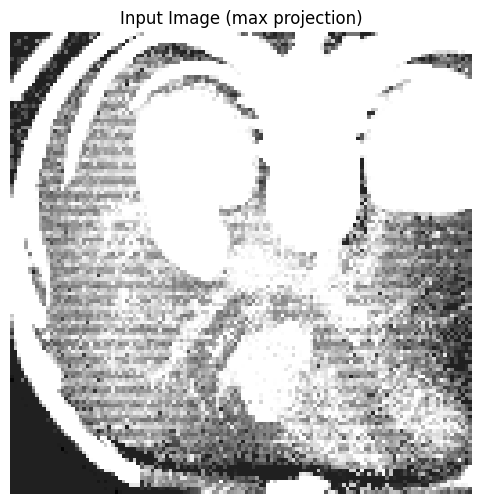

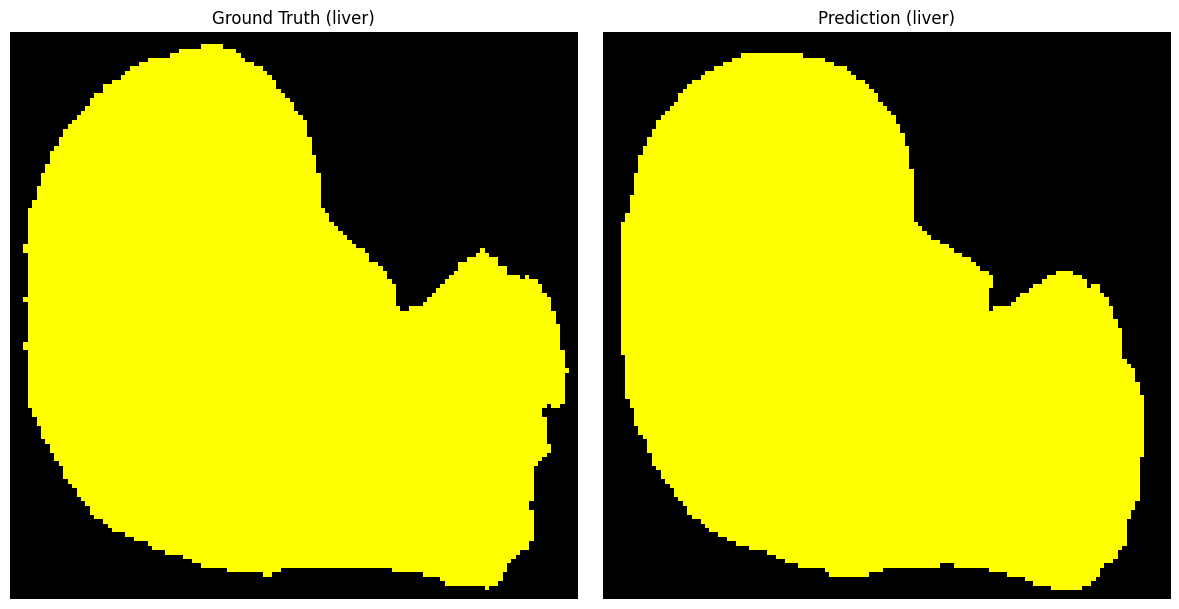

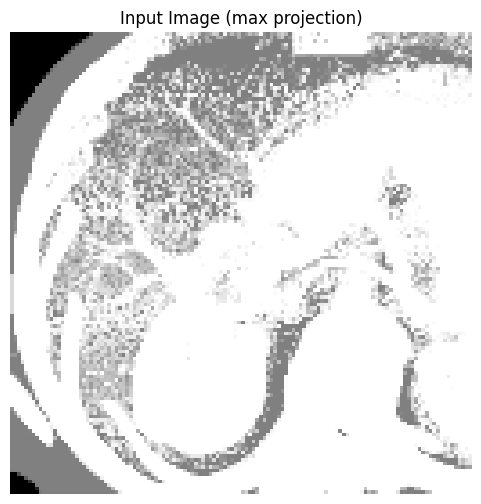

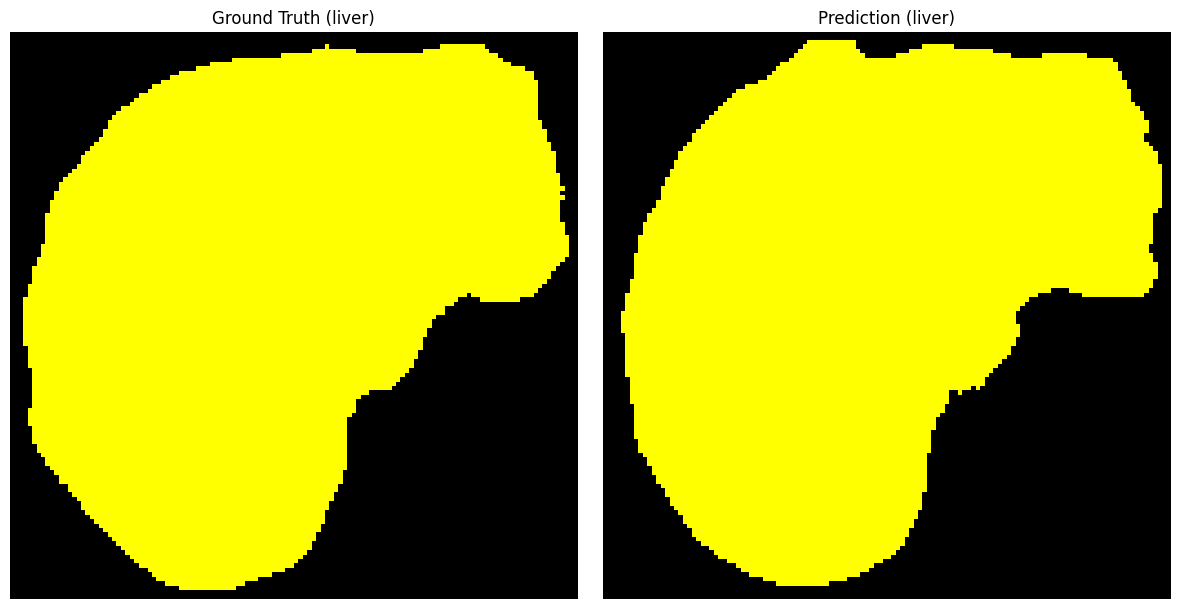

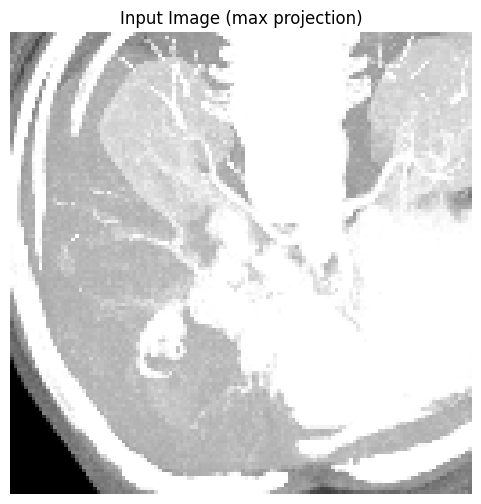

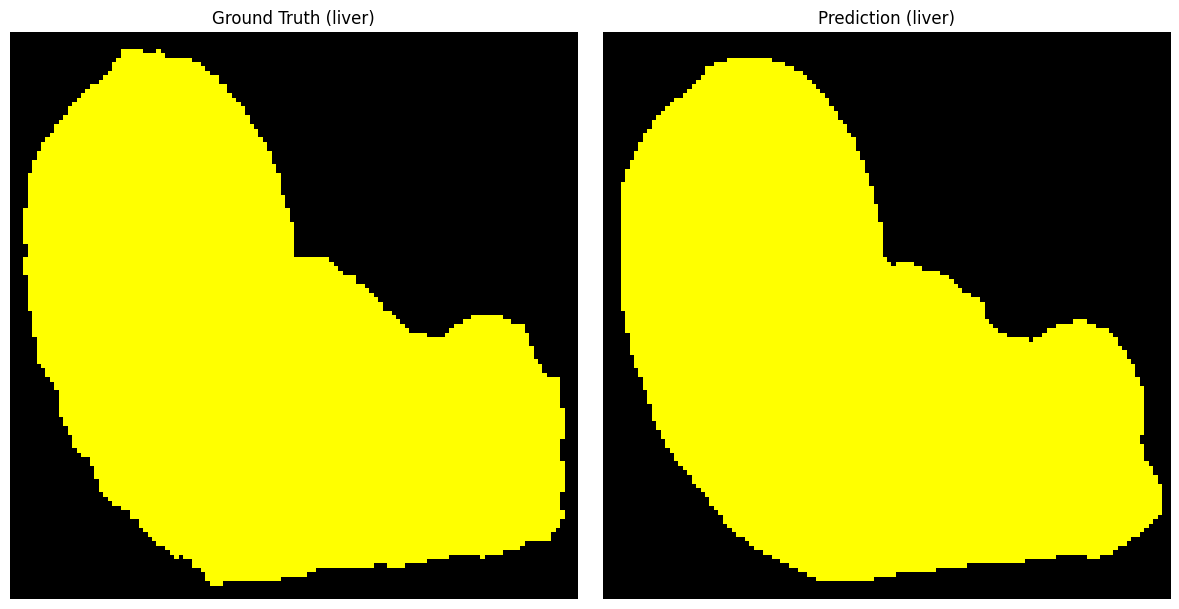

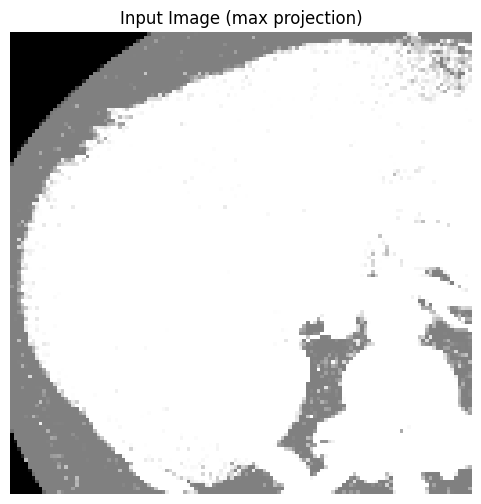

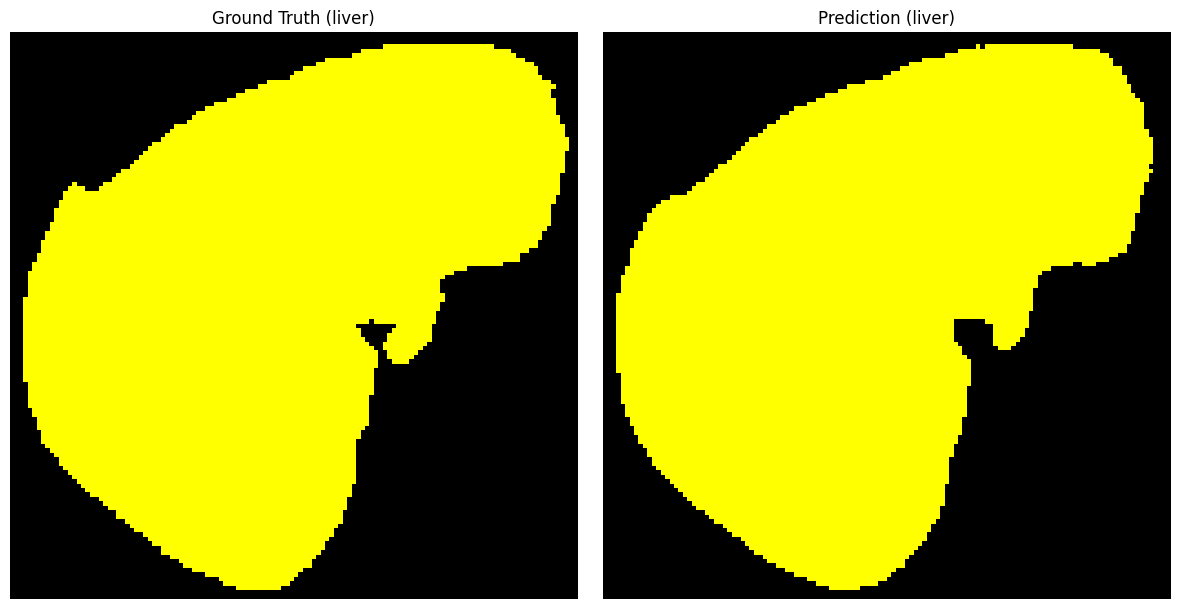

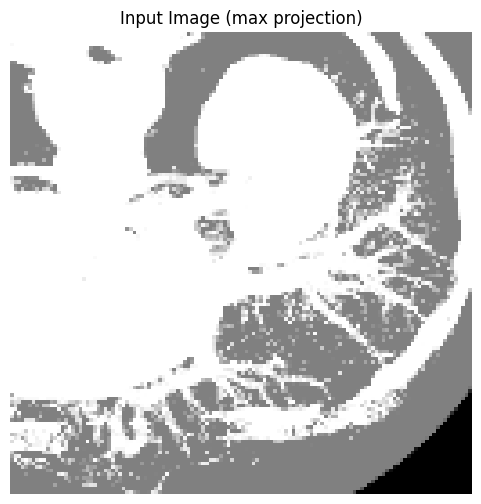

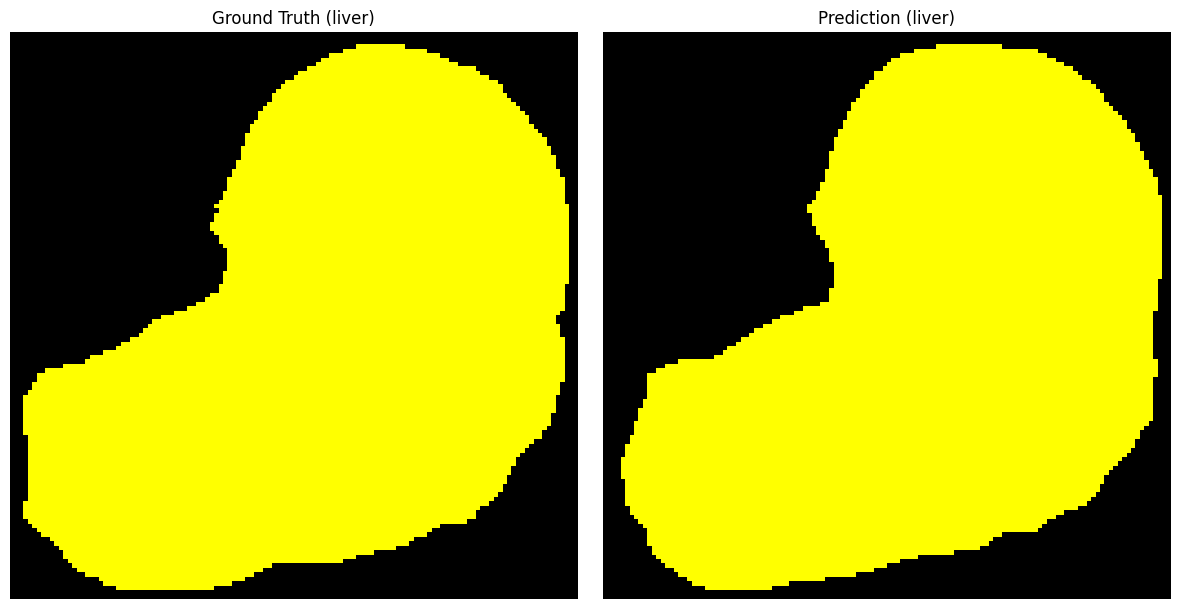

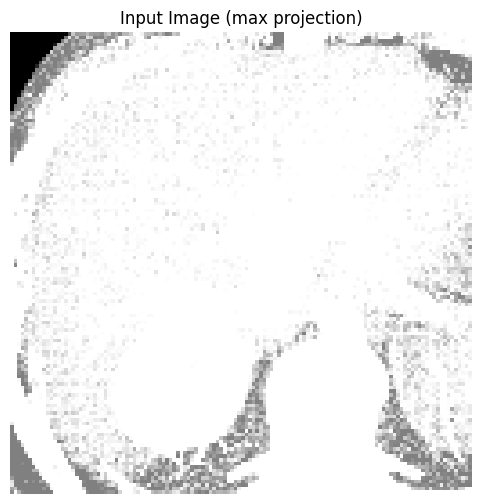

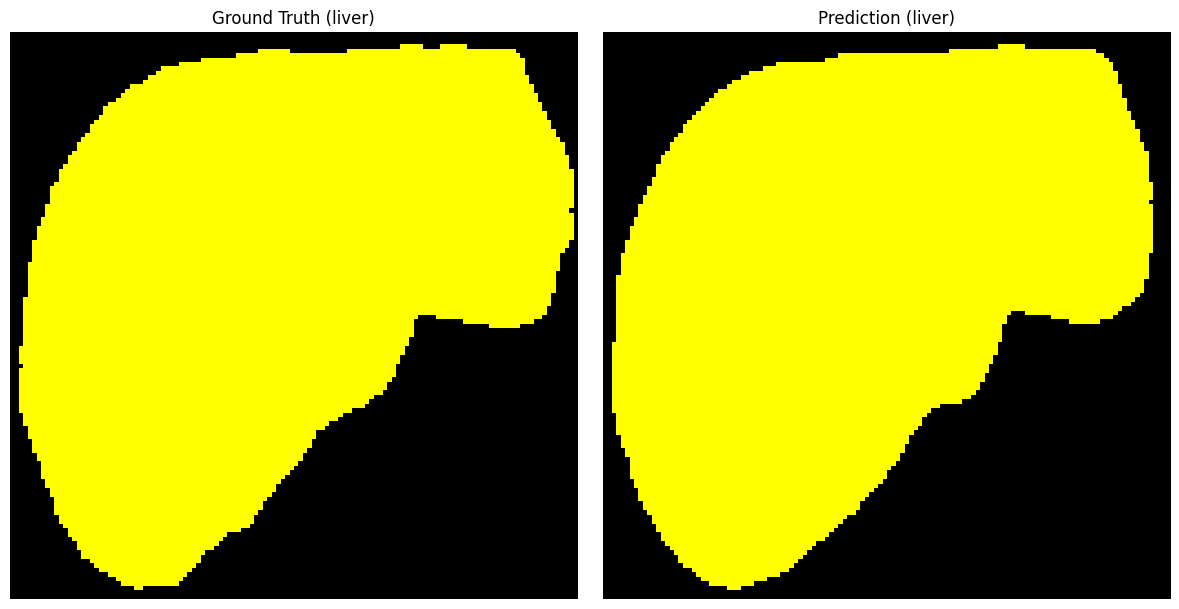

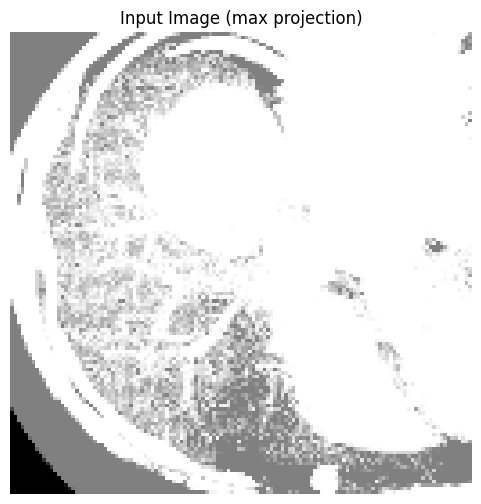

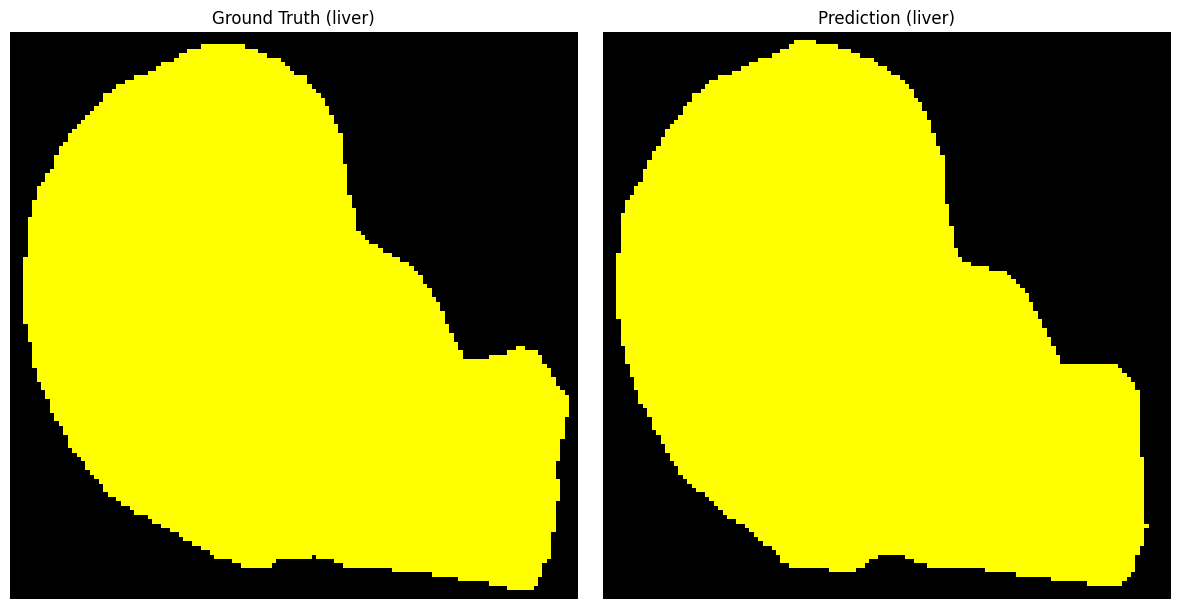

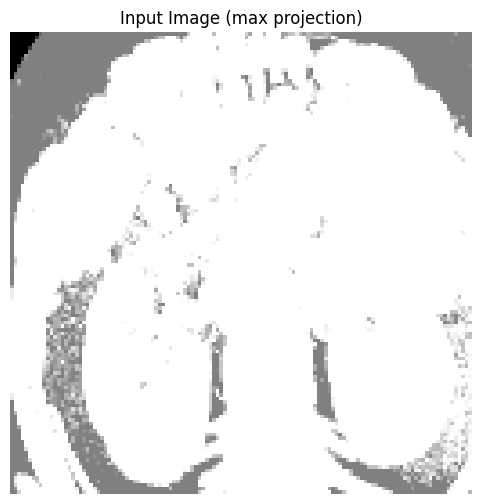

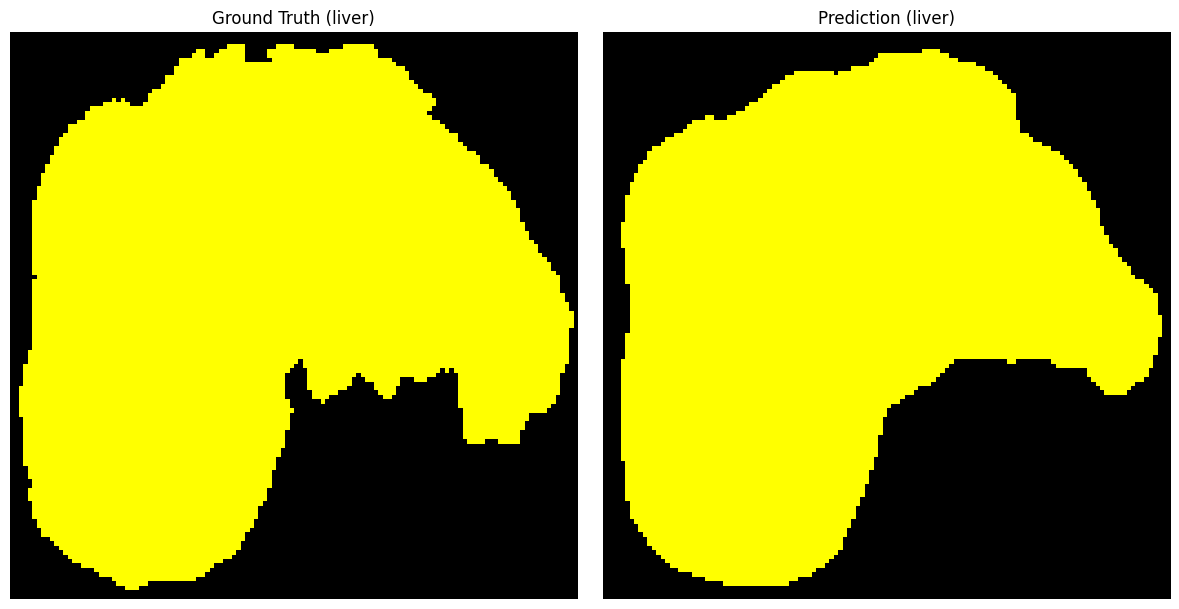

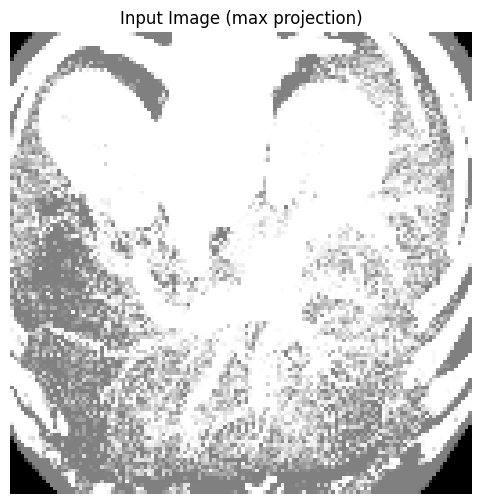

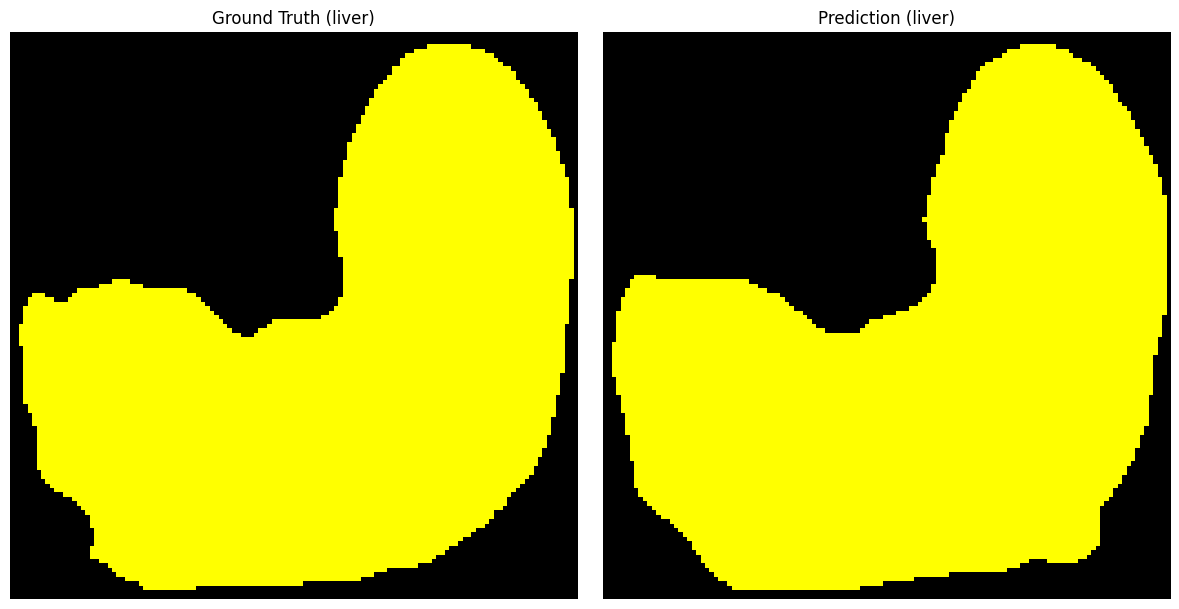

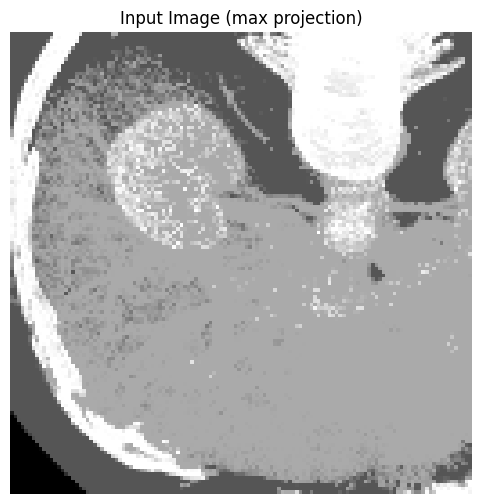

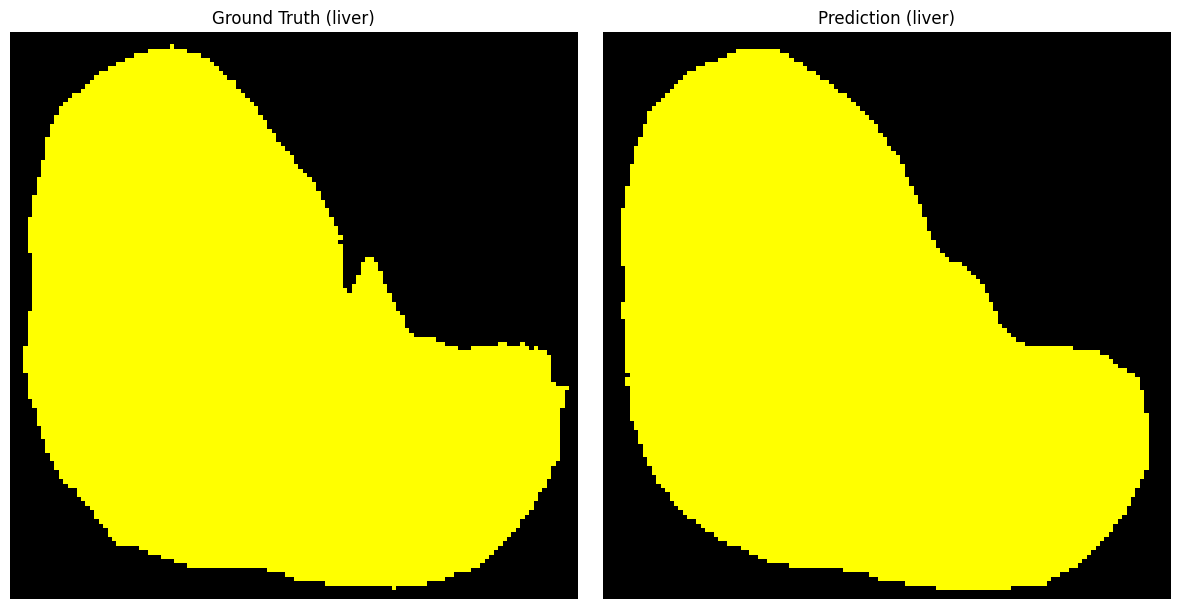

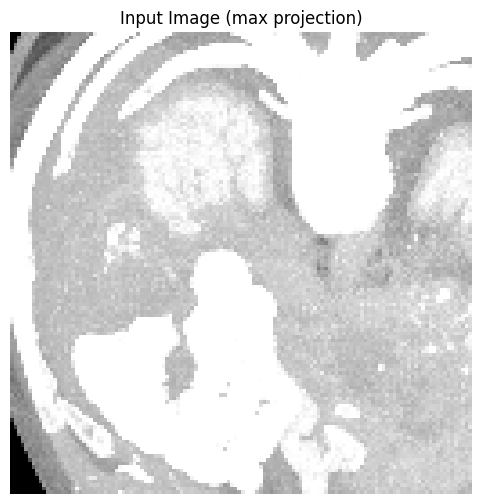

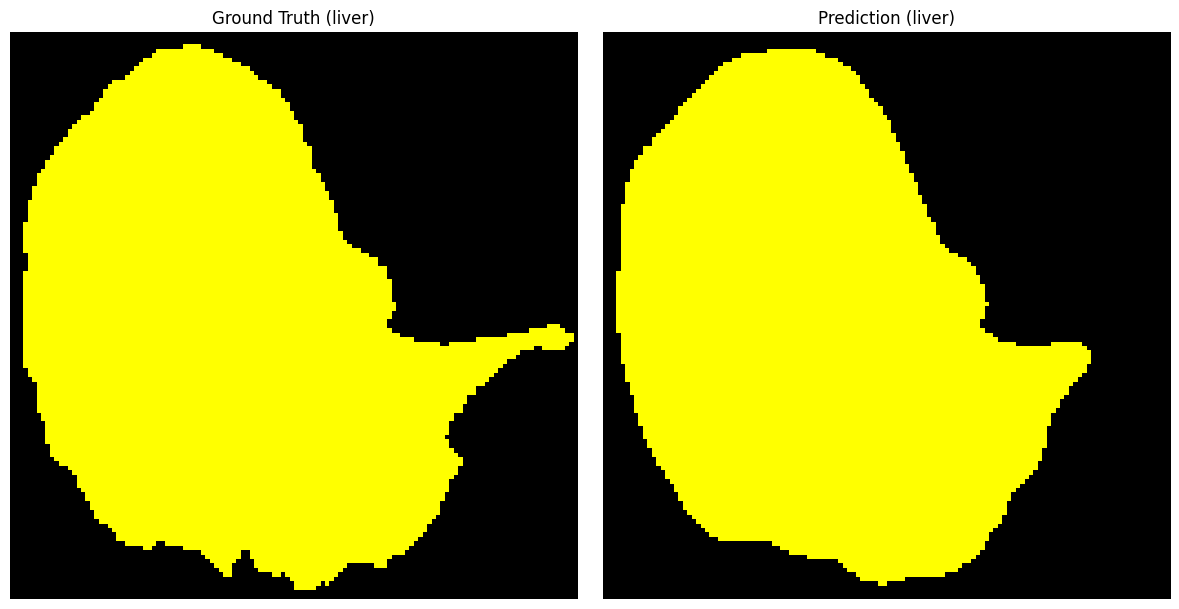

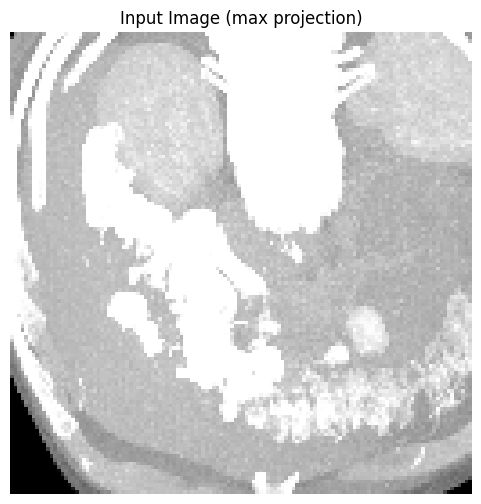

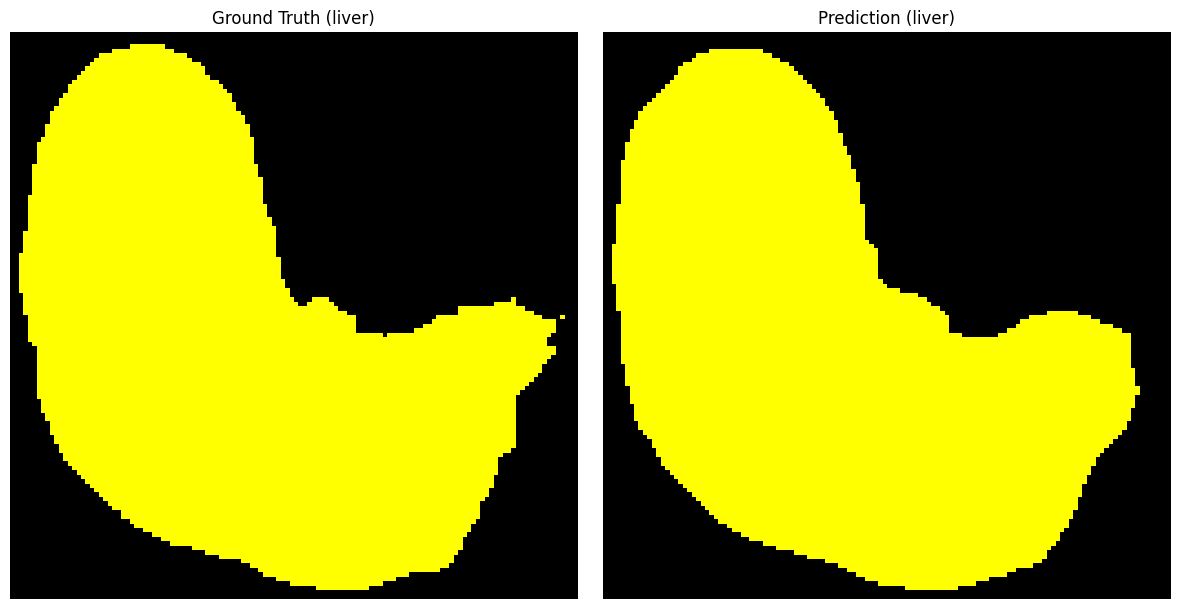

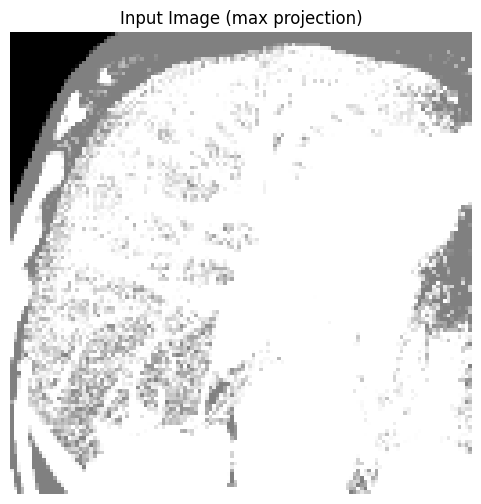

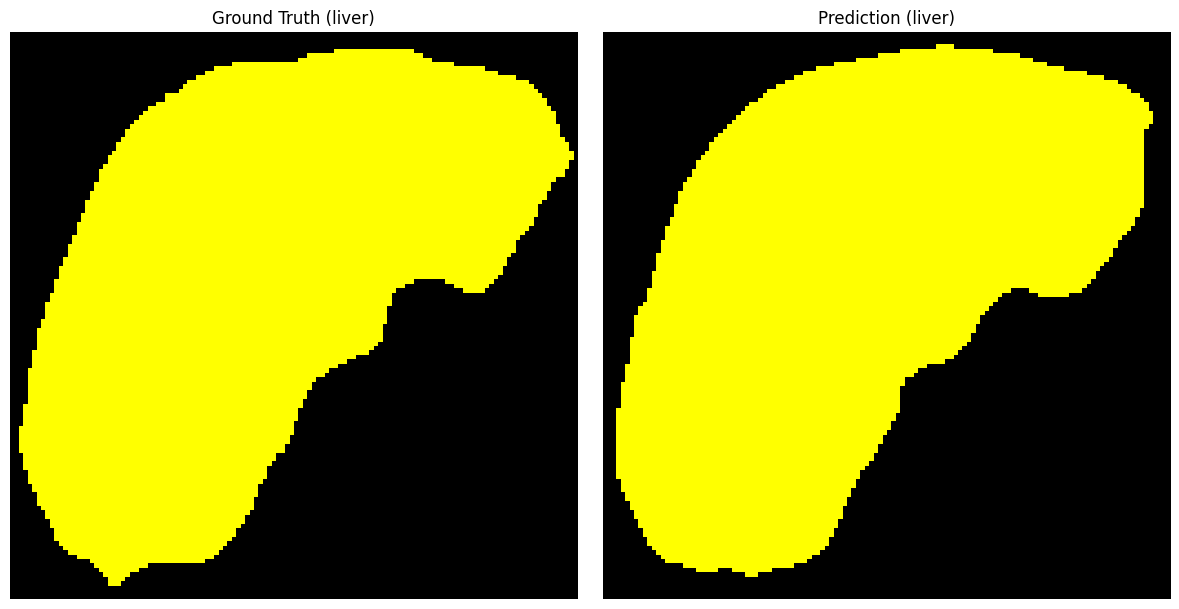

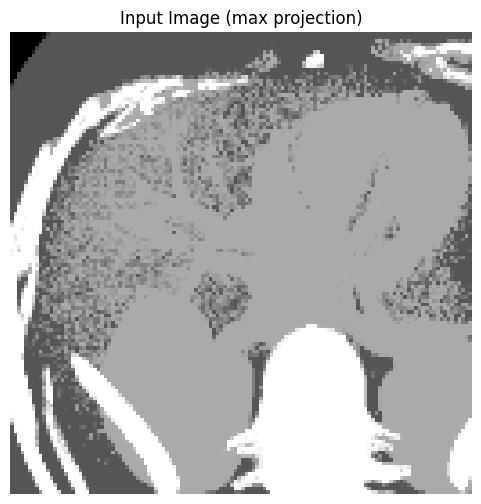

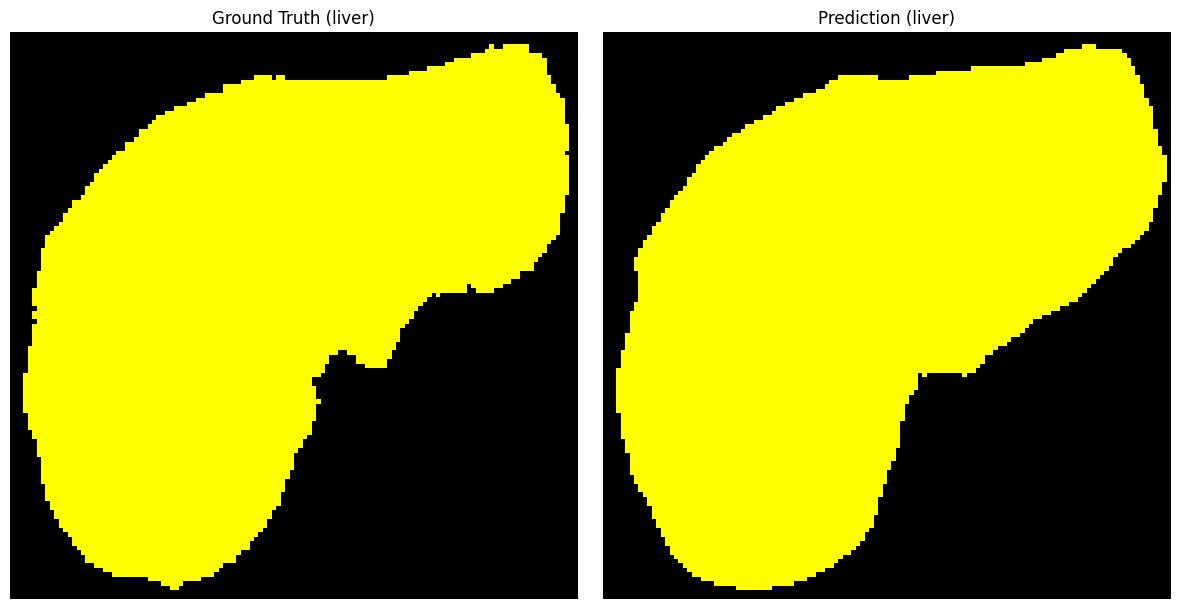

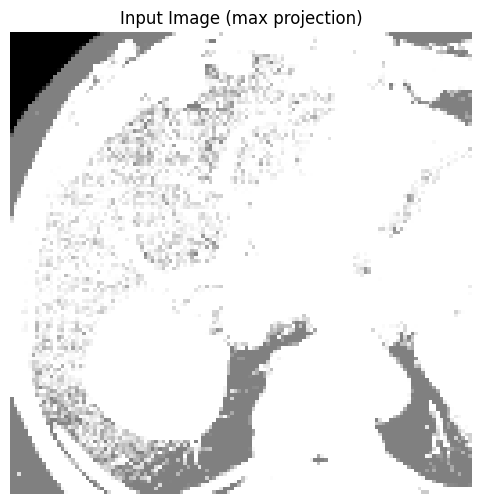

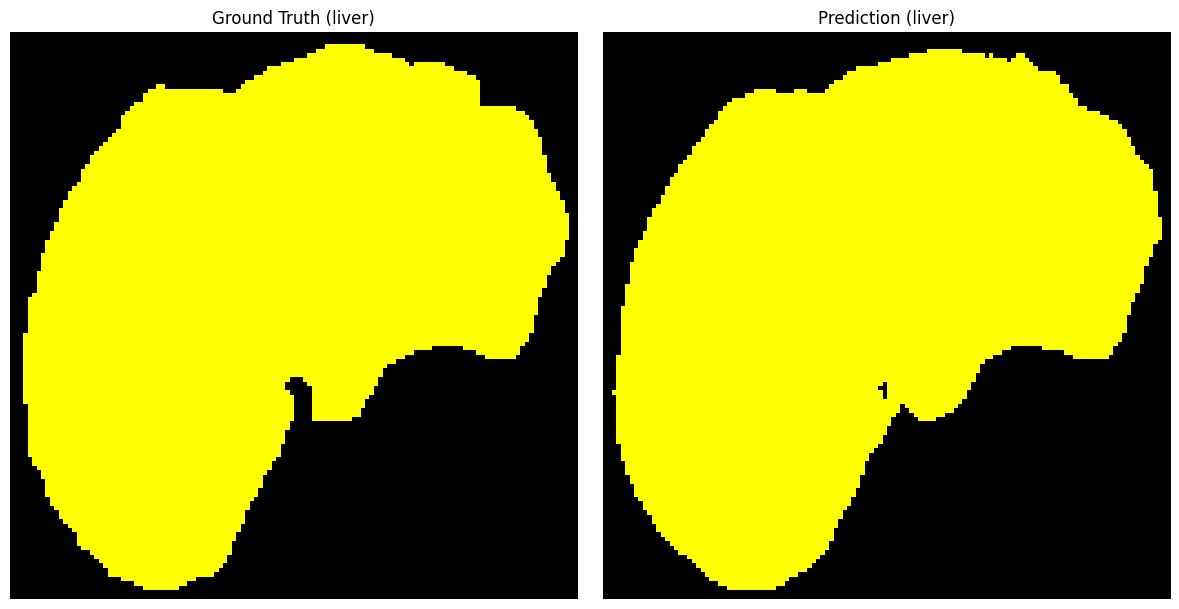

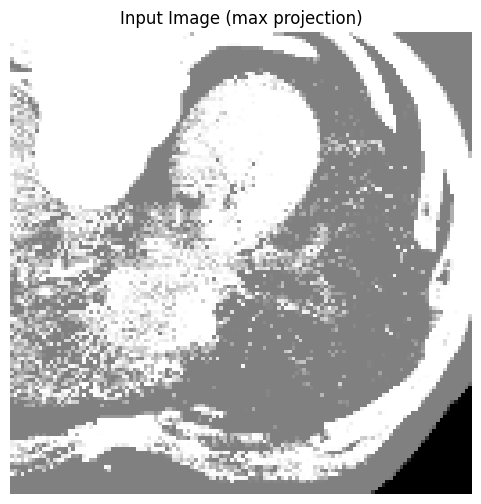

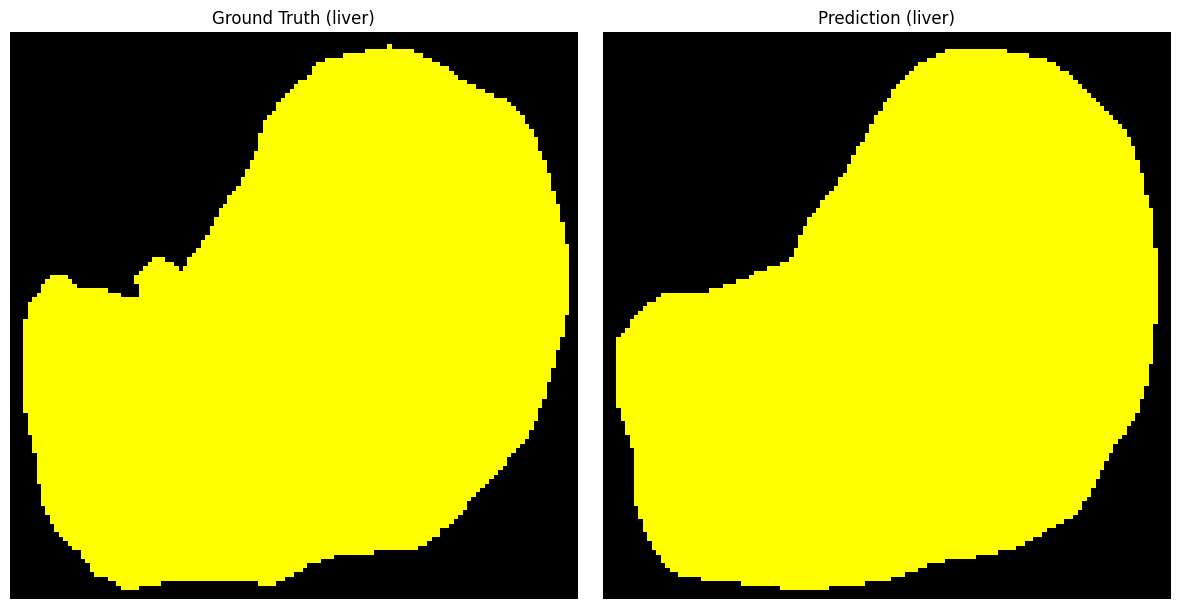

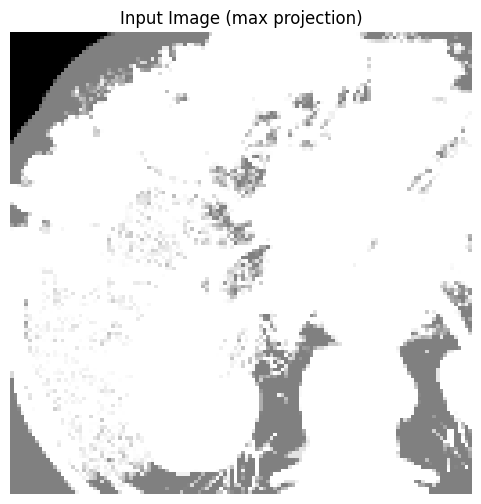

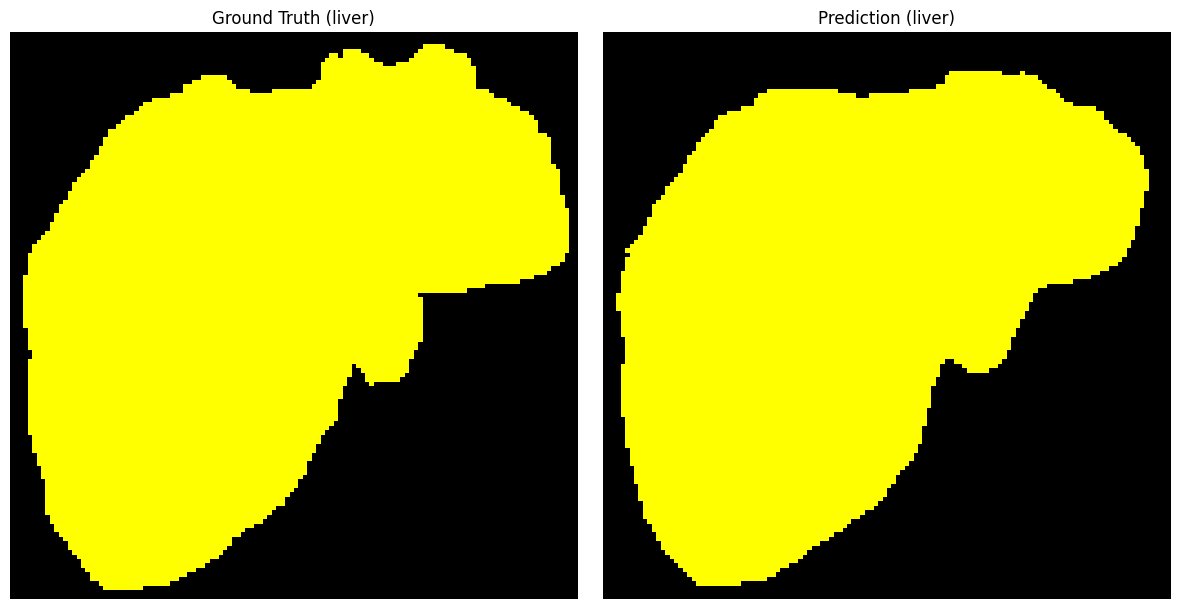

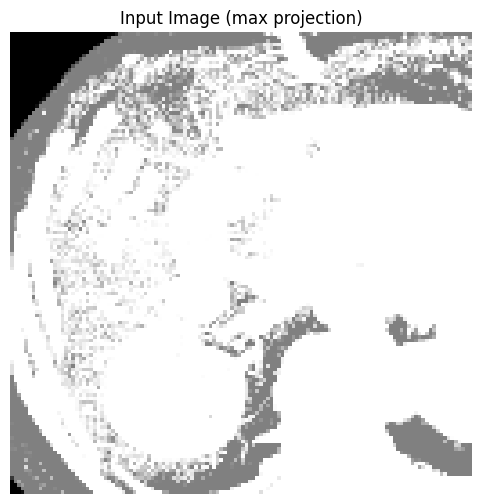

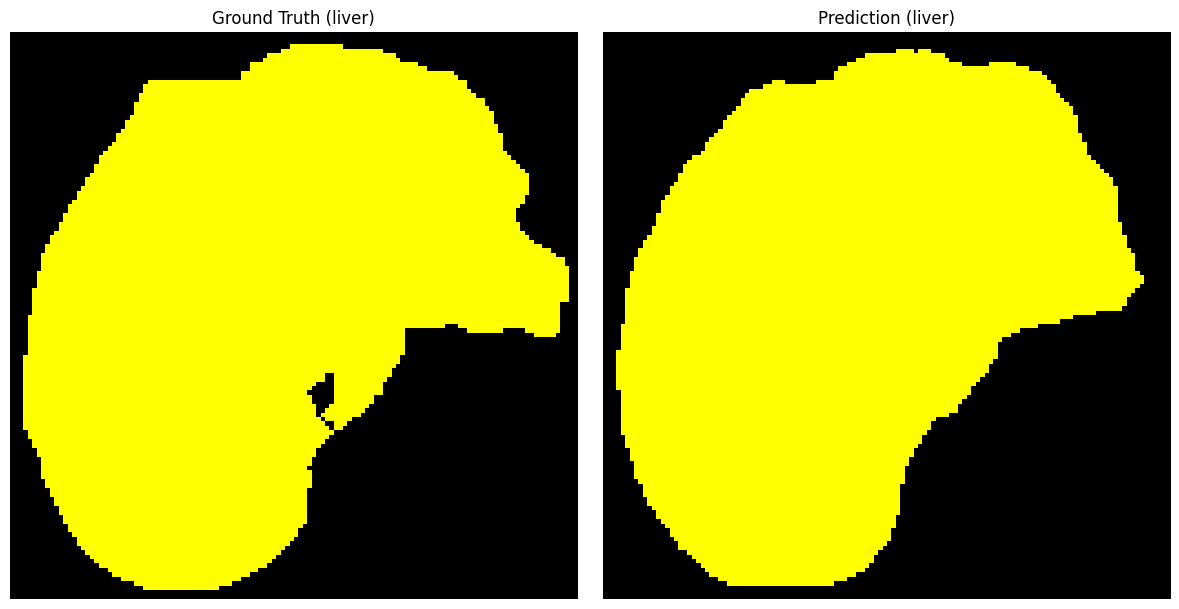

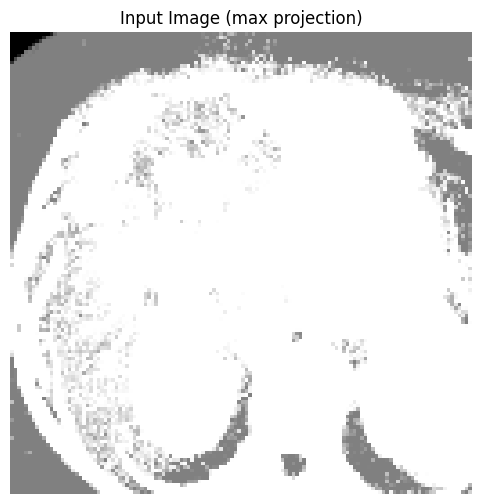

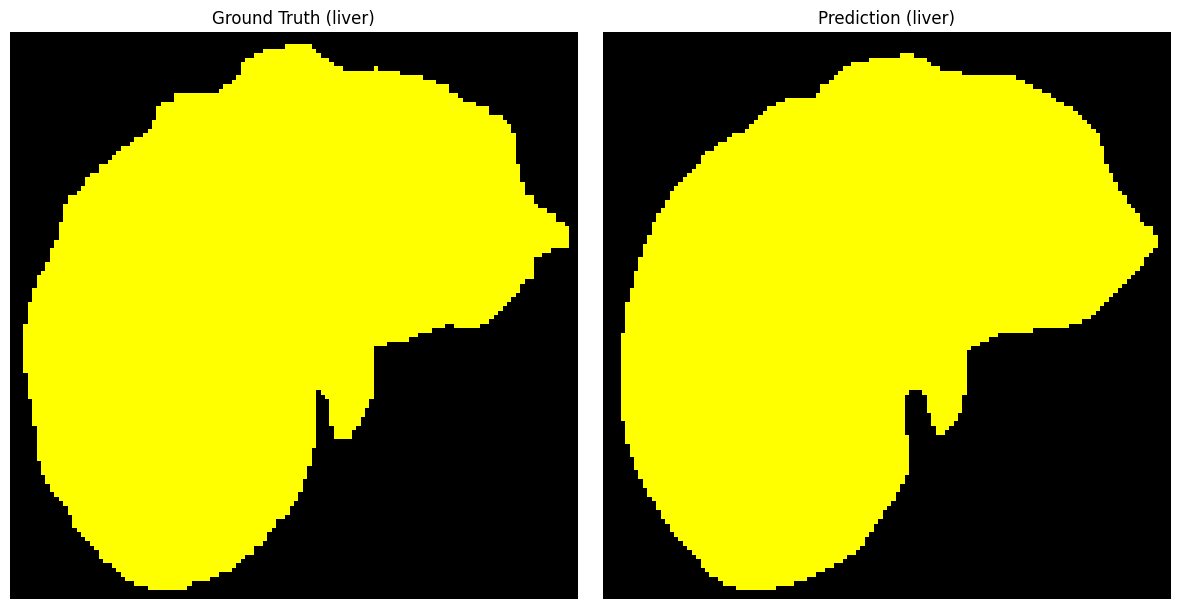

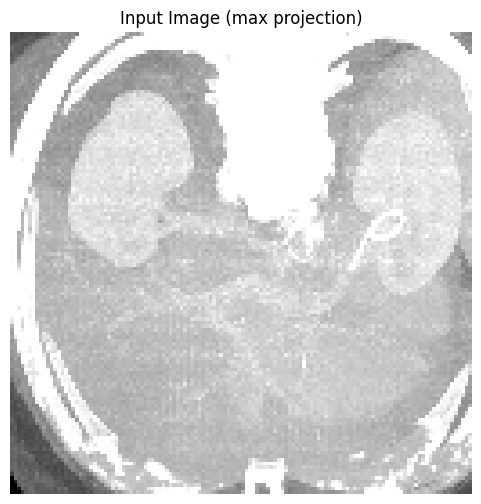

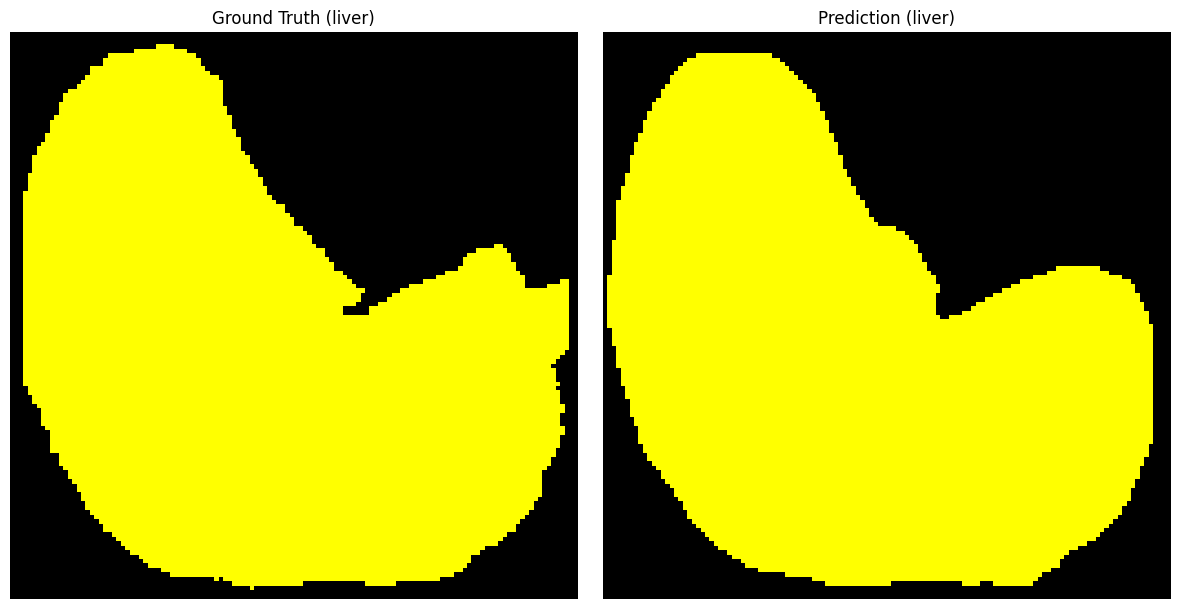

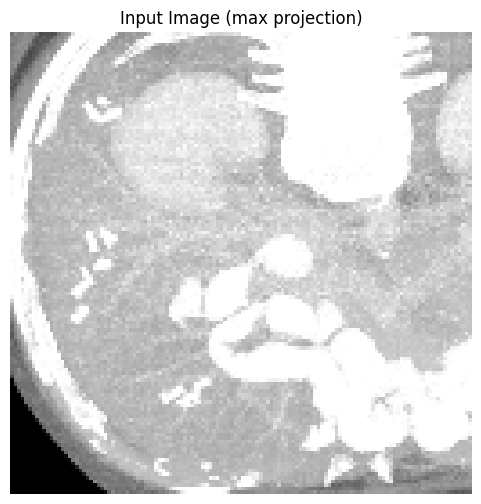

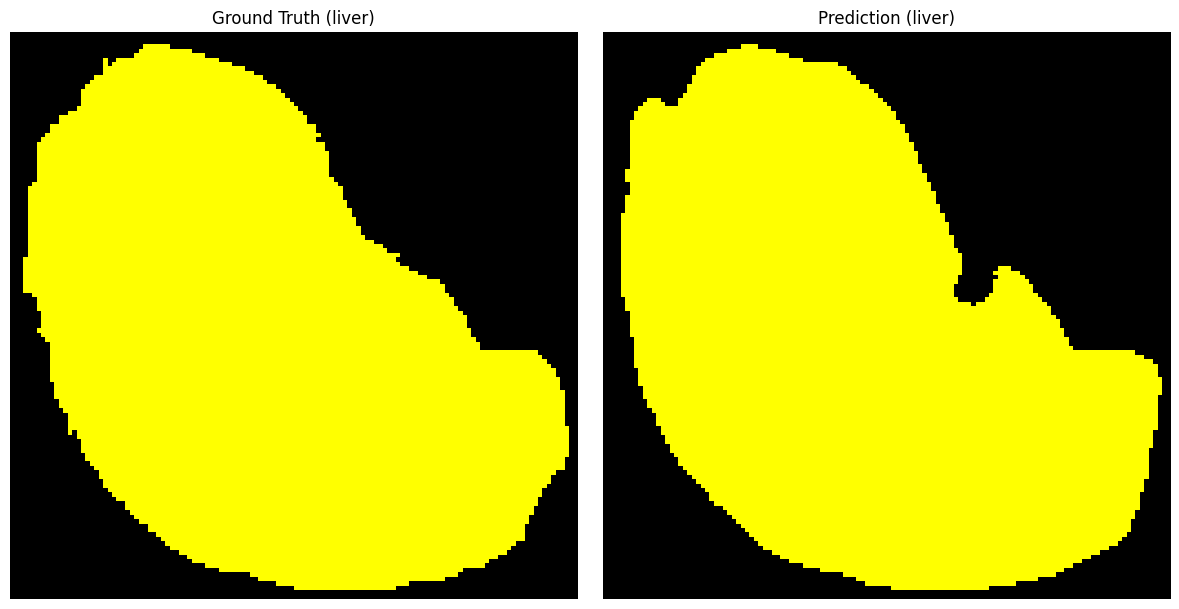

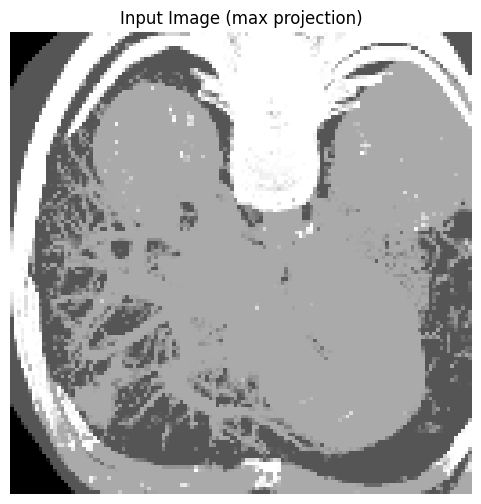

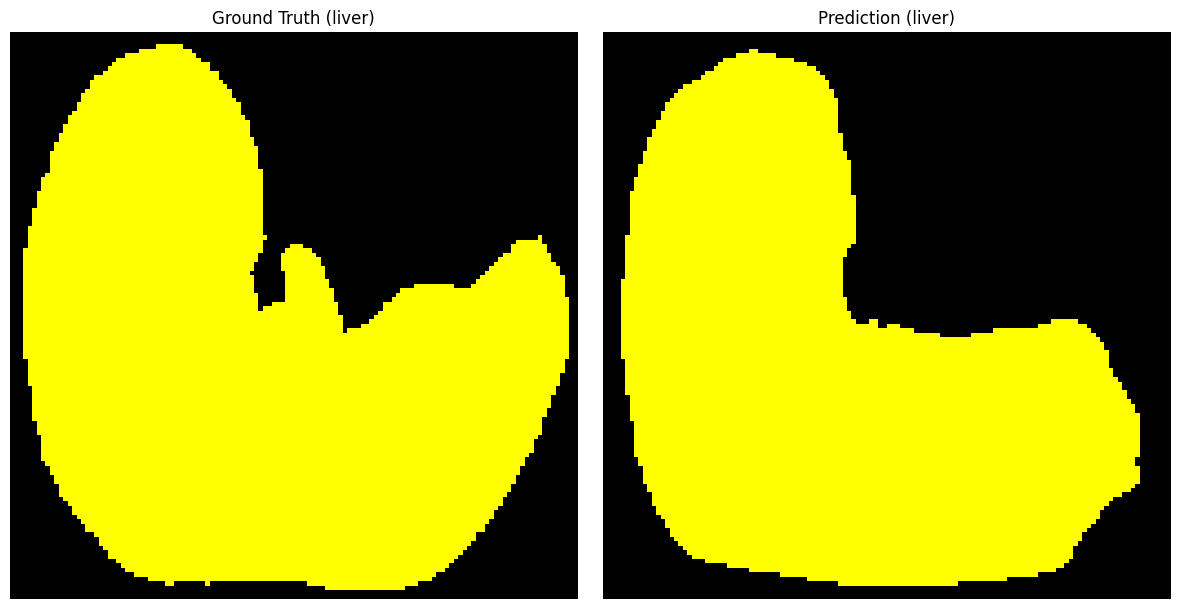

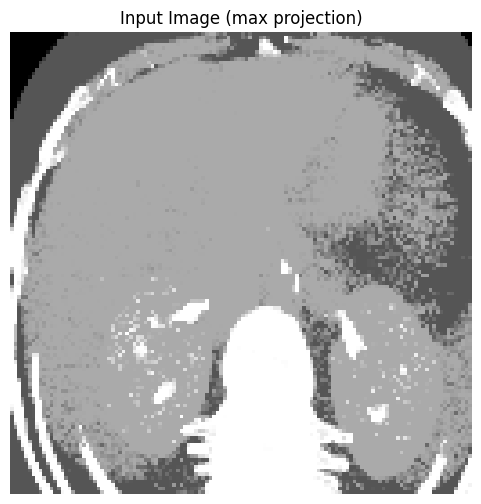

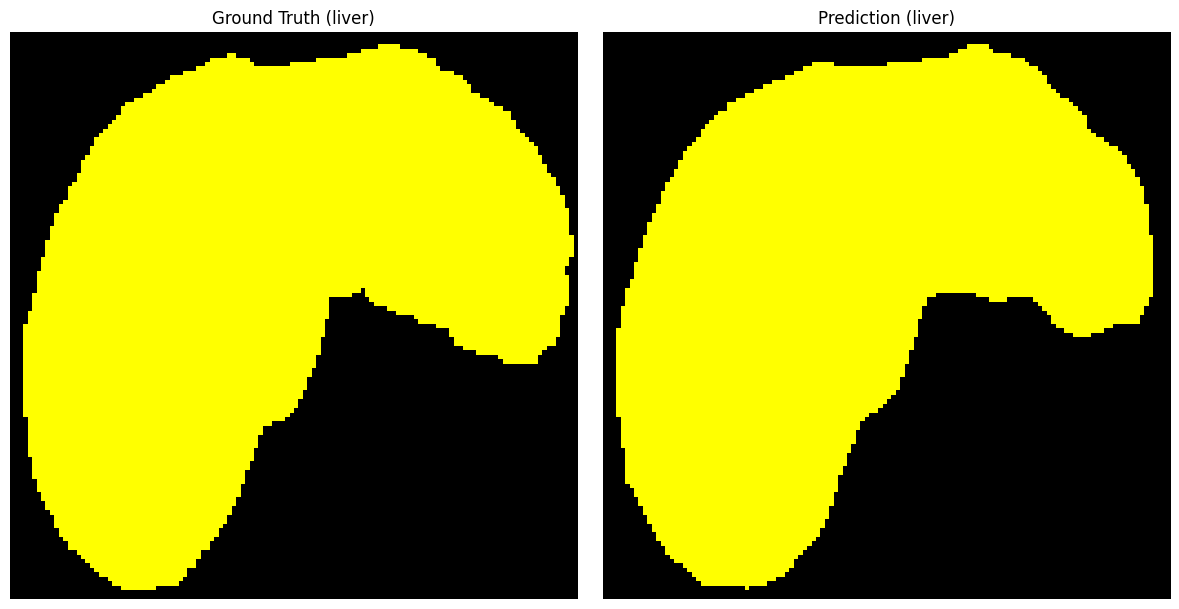

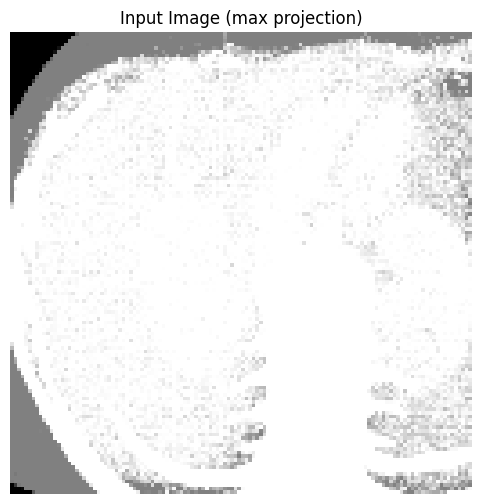

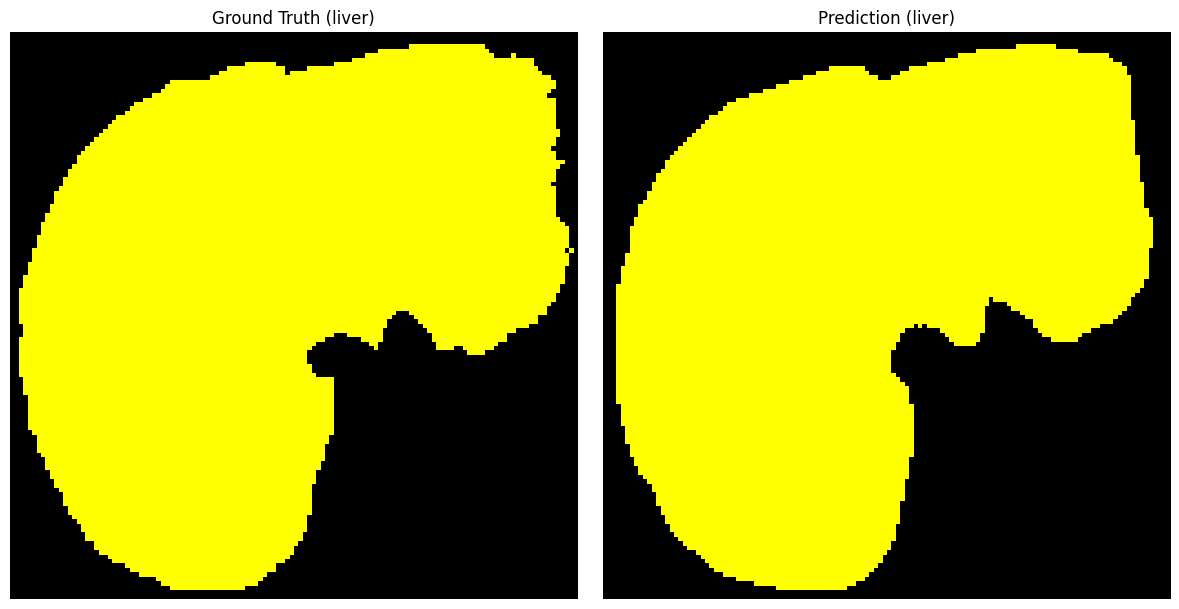

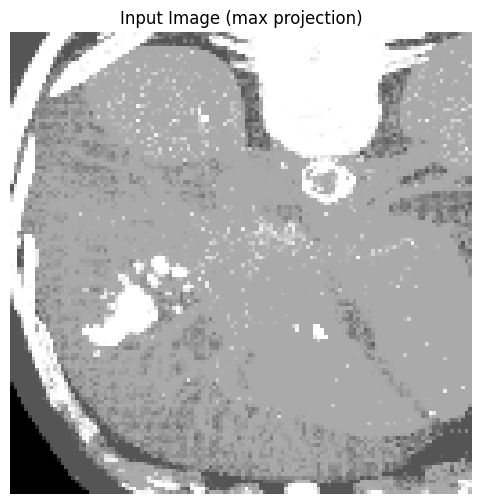

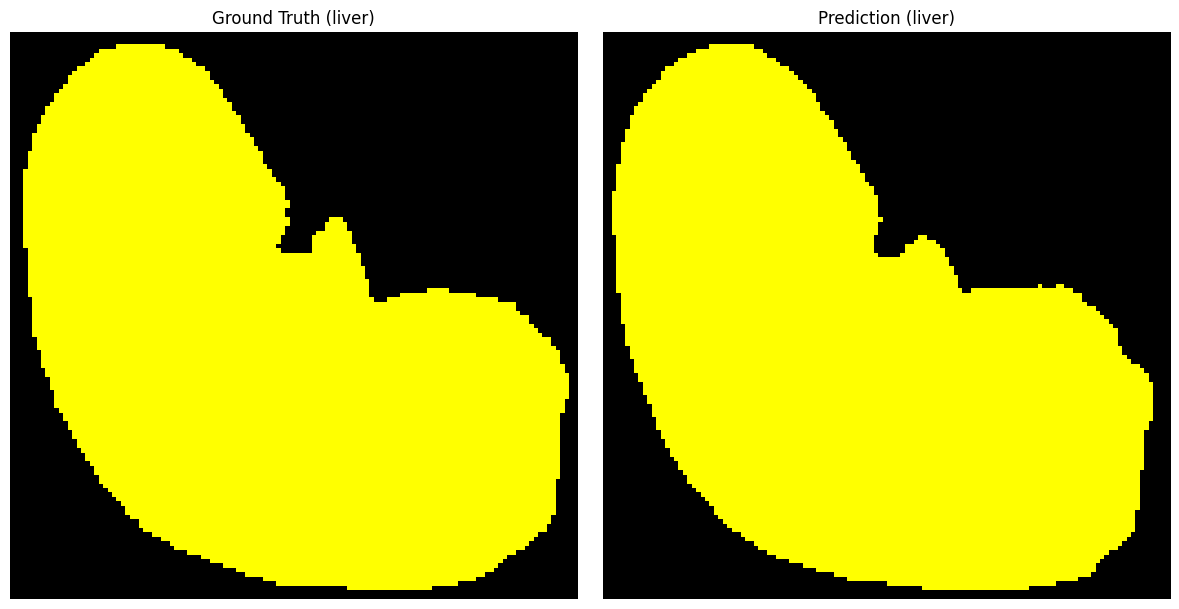

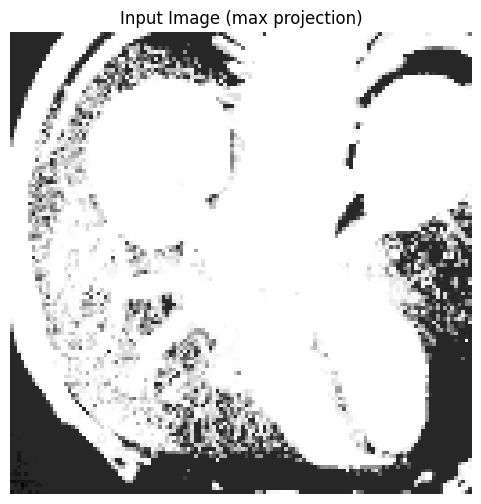

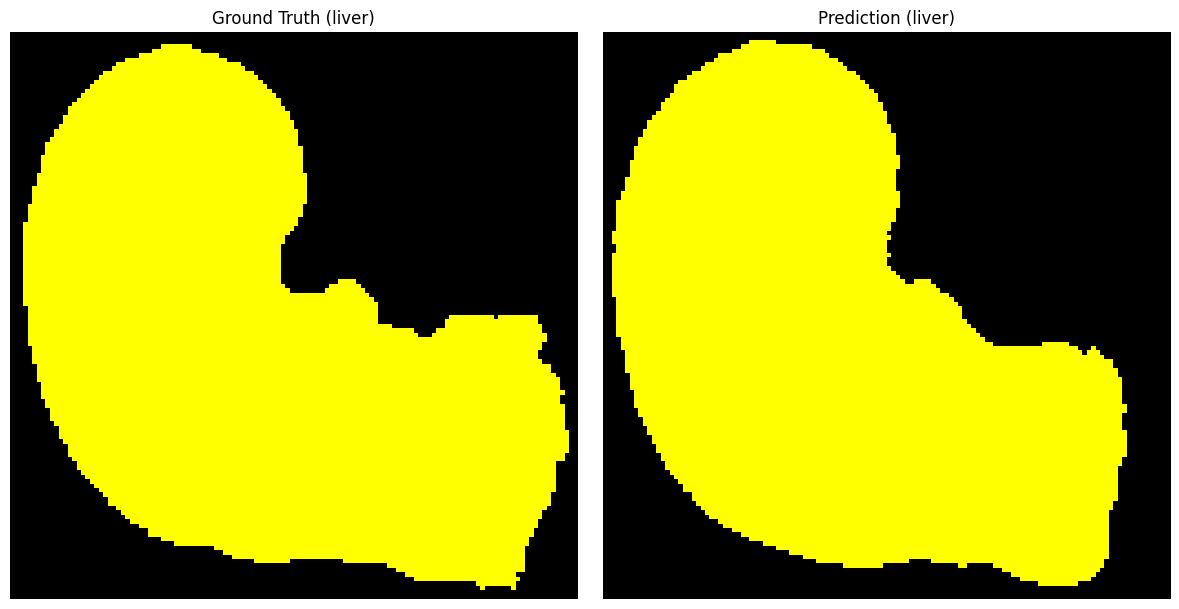

In [12]:
num_images = len(val_loader)
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_1(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [13]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [14]:
import glob
print(glob.glob("/content/drive/MyDrive/KLTN/code/result_model_*.json"))

['/content/drive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


In [15]:
model_results = load_metrics('/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json')

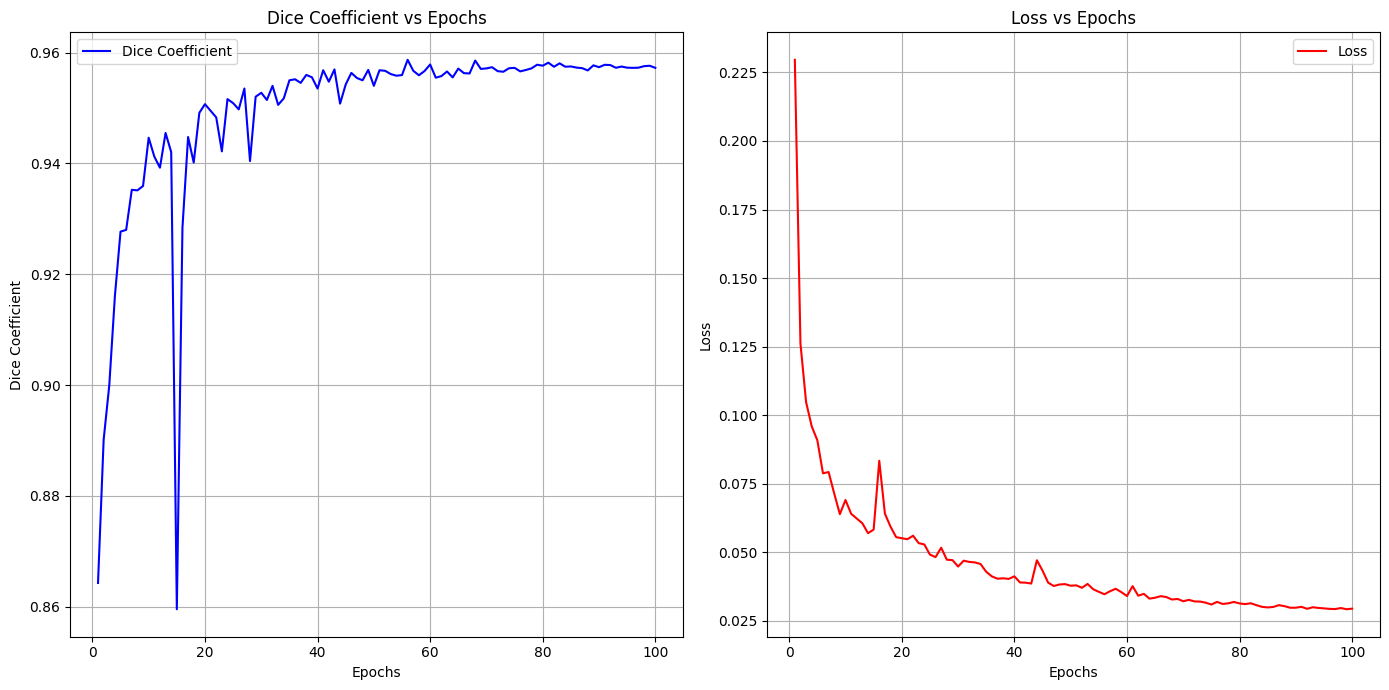

In [16]:
epochs = list(range(1, len(model_results["dice_liver"]) + 1))
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results["dice_liver"], label='Dice Coefficient', color='blue')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_results["loss"], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()